In [1]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import gc

In [2]:
with np.load('data/interim/kmers/kmer_matrix.npz') as data:
    kmers = data['kmers']
    kmer_order = data['kmer_order']
    genome_order = data['genome_order']

In [3]:
micsdf = joblib.load('data/interim/mic_class_dataframe2.pkl')
class_orders = joblib.load('data/interim/mic_class_order_dict2.pkl')

In [4]:
# TIO
tio_labels = class_orders['TIO']
tio_label_index = { k: v for v, k in enumerate(tio_labels) }
y_tio = np.array([ tio_label_index[m] if not pd.isna(m) else m for m in micsdf.loc[genome_order, 'TIO'] ])
labels, counts = np.unique(y_tio, return_counts=True)
ok = labels[counts >= 5]

mask = np.in1d(y_tio, ok) # Since Nan is not a label, this also filters invalid MICs
y_tio = y_tio[mask]
X_tio = kmers[mask,:]
tio_samples = genome_order[mask]
del kmers
del genome_order
del micsdf
del class_orders
gc.collect()
# %xdel kmers
# %xdel genome_order
# %xdel micsdf
# %xdel class_orders

45

In [5]:
# Test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tio, y_tio, test_size=0.2, random_state=36, stratify=y_tio)
del X_tio
del y_tio
gc.collect()

0

In [6]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([1., 2., 3., 4., 5., 6.]), array([ 404, 1046,   66,    6,   78,  205]))
(array([1., 2., 3., 4., 5., 6.]), array([101, 262,  16,   1,  20,  52]))


In [7]:
# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

fsel = SelectKBest(f_classif, k=500)
X_train_fs = fsel.fit_transform(X_train, y_train)
X_test_fs = fsel.transform(X_test)



/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 149082  195348  257056 ... 2008529 2008530 2008531] are constant.
  UserWarning)
/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
import tensorflow
from tensorflow import set_random_seed

from keras.layers.core import Dense, Dropout, Activation

from keras.models import Sequential#, load_model
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


In [13]:
patience = 16
early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=0, min_delta=0.005, mode='auto')
model_save = ModelCheckpoint("best_model.hdf5",monitor='loss', verbose = 0, save_best_only =True, save_weights_only = False, mode ='auto', period =1)
reduce_LR = ReduceLROnPlateau(monitor='loss', factor= 0.1, patience=(patience/2), verbose = 0, min_delta=0.005,mode = 'auto', cooldown=0, min_lr=0)

num_classes=6
n1 = X_test_fs.shape[1]
n2 = int((n1+num_classes)/2)
model = Sequential()
model.add(Dense(n1,activation='relu',input_dim=(n1)))
model.add(Dropout(0.5))
model.add(Dense(n2, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='relu', kernel_initializer='uniform', ))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mae', metrics=['accuracy'], optimizer='adam')

In [14]:
model.fit(X_train_fs, y_train, epochs=100, verbose=1, callbacks=[early_stop, reduce_LR])

Epoch 1/100


  32/1805 [..............................] - ETA: 53s - loss: 2.5879 - acc: 0.0000e+00

  96/1805 [>.............................] - ETA: 18s - loss: 2.2887 - acc: 0.0000e+00

 192/1805 [==>...........................] - ETA: 9s - loss: 2.2620 - acc: 0.0104     

 256/1805 [===>..........................] - ETA: 6s - loss: 2.2257 - acc: 0.0273

 352/1805 [====>.........................] - ETA: 4s - loss: 1.9790 - acc: 0.0824

 480/1805 [======>.......................] - ETA: 3s - loss: 1.7421 - acc: 0.1437

 576/1805 [========>.....................] - ETA: 2s - loss: 1.6084 - acc: 0.1927

 672/1805 [==========>...................] - ETA: 2s - loss: 1.4993 - acc: 0.2128

 736/1805 [===========>..................] - ETA: 2s - loss: 1.4330 - acc: 0.2160

 832/1805 [============>.................] - ETA: 1s - loss: 1.3482 - acc: 0.2428

 896/1805 [=============>................] - ETA: 1s - loss: 1.2922 - acc: 0.2690

1024/1805 [================>.............] - ETA: 1s - loss: 1.2074 - acc: 0.3145

1120/1805 [=================>............] - ETA: 1s - loss: 1.1472 - acc: 0.3402

1248/1805 [===================>..........] - ETA: 0s - loss: 1.0872 - acc: 0.3670

1344/1805 [=====================>........] - ETA: 0s - loss: 1.0548 - acc: 0.3810

1472/1805 [=======================>......] - ETA: 0s - loss: 1.0150 - acc: 0.3947

1536/1805 [========================>.....] - ETA: 0s - loss: 0.9991 - acc: 0.4004

1632/1805 [==========================>...] - ETA: 0s - loss: 0.9748 - acc: 0.4093

1696/1805 [===========================>..] - ETA: 0s - loss: 0.9552 - acc: 0.4169

1792/1805 [============================>.] - ETA: 0s - loss: 0.9364 - acc: 0.4241

1805/1805 [==============================] - 2s 1ms/step - loss: 0.9325 - acc: 0.4266


Epoch 2/100


  32/1805 [..............................] - ETA: 12s - loss: 0.6794 - acc: 0.5625

 128/1805 [=>............................] - ETA: 3s - loss: 0.6290 - acc: 0.5547 

 224/1805 [==>...........................] - ETA: 2s - loss: 0.6007 - acc: 0.5491

 288/1805 [===>..........................] - ETA: 2s - loss: 0.5582 - acc: 0.5868

 384/1805 [=====>........................] - ETA: 1s - loss: 0.5416 - acc: 0.6016

 480/1805 [======>.......................] - ETA: 1s - loss: 0.5338 - acc: 0.6021

 576/1805 [========>.....................] - ETA: 1s - loss: 0.5173 - acc: 0.6215

 672/1805 [==========>...................] - ETA: 1s - loss: 0.5138 - acc: 0.6235

 768/1805 [===========>..................] - ETA: 0s - loss: 0.5172 - acc: 0.6250

 832/1805 [============>.................] - ETA: 0s - loss: 0.5240 - acc: 0.6130

 928/1805 [==============>...............] - ETA: 0s - loss: 0.5267 - acc: 0.6088

1024/1805 [================>.............] - ETA: 0s - loss: 0.5220 - acc: 0.6113

1120/1805 [=================>............] - ETA: 0s - loss: 0.5195 - acc: 0.6170

1216/1805 [===================>..........] - ETA: 0s - loss: 0.5226 - acc: 0.6135

1312/1805 [====================>.........] - ETA: 0s - loss: 0.5158 - acc: 0.6136

1472/1805 [=======================>......] - ETA: 0s - loss: 0.5119 - acc: 0.6155

1568/1805 [=========================>....] - ETA: 0s - loss: 0.5063 - acc: 0.6224

1696/1805 [===========================>..] - ETA: 0s - loss: 0.5138 - acc: 0.6209

1792/1805 [============================>.] - ETA: 0s - loss: 0.5104 - acc: 0.6244

1805/1805 [==============================] - 1s 724us/step - loss: 0.5120 - acc: 0.6244


Epoch 3/100
  32/1805 [..............................] - ETA: 0s - loss: 0.4827 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.4470 - acc: 0.6979

 160/1805 [=>............................] - ETA: 1s - loss: 0.4563 - acc: 0.6875

 256/1805 [===>..........................] - ETA: 1s - loss: 0.4869 - acc: 0.6523

 352/1805 [====>.........................] - ETA: 1s - loss: 0.4831 - acc: 0.6562

 448/1805 [======>.......................] - ETA: 0s - loss: 0.4614 - acc: 0.6719

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4671 - acc: 0.6667

 704/1805 [==========>...................] - ETA: 0s - loss: 0.4619 - acc: 0.6804

 800/1805 [============>.................] - ETA: 0s - loss: 0.4626 - acc: 0.6725

 864/1805 [=============>................] - ETA: 0s - loss: 0.4623 - acc: 0.6701

 928/1805 [==============>...............] - ETA: 0s - loss: 0.4654 - acc: 0.6703

1024/1805 [================>.............] - ETA: 0s - loss: 0.4628 - acc: 0.6709

1152/1805 [==================>...........] - ETA: 0s - loss: 0.4671 - acc: 0.6623

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4670 - acc: 0.6627

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4683 - acc: 0.6577

1472/1805 [=======================>......] - ETA: 0s - loss: 0.4672 - acc: 0.6590

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4649 - acc: 0.6602

1632/1805 [==========================>...] - ETA: 0s - loss: 0.4676 - acc: 0.6624

1728/1805 [===========================>..] - ETA: 0s - loss: 0.4679 - acc: 0.6609

1805/1805 [==============================] - 1s 741us/step - loss: 0.4709 - acc: 0.6593


Epoch 4/100


  32/1805 [..............................] - ETA: 5s - loss: 0.5352 - acc: 0.7500

 128/1805 [=>............................] - ETA: 2s - loss: 0.4351 - acc: 0.7266

 192/1805 [==>...........................] - ETA: 1s - loss: 0.4715 - acc: 0.6875

 288/1805 [===>..........................] - ETA: 1s - loss: 0.5042 - acc: 0.6562

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4762 - acc: 0.6719

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4676 - acc: 0.6625

 576/1805 [========>.....................] - ETA: 1s - loss: 0.4714 - acc: 0.6632

 640/1805 [=========>....................] - ETA: 1s - loss: 0.4700 - acc: 0.6594

 736/1805 [===========>..................] - ETA: 0s - loss: 0.4711 - acc: 0.6576

 832/1805 [============>.................] - ETA: 0s - loss: 0.4692 - acc: 0.6562

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4796 - acc: 0.6438

1120/1805 [=================>............] - ETA: 0s - loss: 0.4856 - acc: 0.6411

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4824 - acc: 0.6453

1280/1805 [====================>.........] - ETA: 0s - loss: 0.4876 - acc: 0.6438

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4848 - acc: 0.6463

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4821 - acc: 0.6484

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4880 - acc: 0.6462

1805/1805 [==============================] - 1s 658us/step - loss: 0.4918 - acc: 0.6410


Epoch 5/100


  32/1805 [..............................] - ETA: 3s - loss: 0.3849 - acc: 0.7188

 128/1805 [=>............................] - ETA: 1s - loss: 0.4150 - acc: 0.7031

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4315 - acc: 0.6875

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4380 - acc: 0.6937

 448/1805 [======>.......................] - ETA: 0s - loss: 0.4471 - acc: 0.6897

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4521 - acc: 0.6736

 672/1805 [==========>...................] - ETA: 0s - loss: 0.4541 - acc: 0.6711

 736/1805 [===========>..................] - ETA: 0s - loss: 0.4586 - acc: 0.6698

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4569 - acc: 0.6706

 896/1805 [=============>................] - ETA: 0s - loss: 0.4605 - acc: 0.6618

 992/1805 [===============>..............] - ETA: 0s - loss: 0.4596 - acc: 0.6603

1088/1805 [=================>............] - ETA: 0s - loss: 0.4632 - acc: 0.6572

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4636 - acc: 0.6554

1312/1805 [====================>.........] - ETA: 0s - loss: 0.4724 - acc: 0.6456

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4744 - acc: 0.6484

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4697 - acc: 0.6543

1632/1805 [==========================>...] - ETA: 0s - loss: 0.4662 - acc: 0.6593

1760/1805 [============================>.] - ETA: 0s - loss: 0.4648 - acc: 0.6580

1792/1805 [============================>.] - ETA: 0s - loss: 0.4660 - acc: 0.6574

1805/1805 [==============================] - 1s 733us/step - loss: 0.4674 - acc: 0.6565


Epoch 6/100


  32/1805 [..............................] - ETA: 3s - loss: 0.5269 - acc: 0.5000

 128/1805 [=>............................] - ETA: 1s - loss: 0.4523 - acc: 0.6250

 256/1805 [===>..........................] - ETA: 1s - loss: 0.4809 - acc: 0.6094

 352/1805 [====>.........................] - ETA: 1s - loss: 0.4774 - acc: 0.6136

 448/1805 [======>.......................] - ETA: 0s - loss: 0.4666 - acc: 0.6250

 544/1805 [========>.....................] - ETA: 0s - loss: 0.4639 - acc: 0.6415

 608/1805 [=========>....................] - ETA: 0s - loss: 0.4578 - acc: 0.6480

 672/1805 [==========>...................] - ETA: 0s - loss: 0.4550 - acc: 0.6503

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4496 - acc: 0.6576

 864/1805 [=============>................] - ETA: 0s - loss: 0.4576 - acc: 0.6528

 992/1805 [===============>..............] - ETA: 0s - loss: 0.4615 - acc: 0.6482

1024/1805 [================>.............] - ETA: 0s - loss: 0.4616 - acc: 0.6465

1088/1805 [=================>............] - ETA: 0s - loss: 0.4561 - acc: 0.6544

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4631 - acc: 0.6503

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4677 - acc: 0.6474

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4646 - acc: 0.6503

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4645 - acc: 0.6491

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4644 - acc: 0.6536

1632/1805 [==========================>...] - ETA: 0s - loss: 0.4604 - acc: 0.6581

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4582 - acc: 0.6621

1792/1805 [============================>.] - ETA: 0s - loss: 0.4608 - acc: 0.6624

1805/1805 [==============================] - 1s 710us/step - loss: 0.4618 - acc: 0.6620


Epoch 7/100


  32/1805 [..............................] - ETA: 11s - loss: 0.3254 - acc: 0.7500

 128/1805 [=>............................] - ETA: 3s - loss: 0.4482 - acc: 0.6797 

 192/1805 [==>...........................] - ETA: 2s - loss: 0.4833 - acc: 0.6406

 288/1805 [===>..........................] - ETA: 2s - loss: 0.4692 - acc: 0.6528

 384/1805 [=====>........................] - ETA: 1s - loss: 0.5160 - acc: 0.6172

 480/1805 [======>.......................] - ETA: 1s - loss: 0.5148 - acc: 0.6125

 544/1805 [========>.....................] - ETA: 1s - loss: 0.5182 - acc: 0.6121

 640/1805 [=========>....................] - ETA: 1s - loss: 0.5216 - acc: 0.6078

 672/1805 [==========>...................] - ETA: 1s - loss: 0.5293 - acc: 0.5982

 768/1805 [===========>..................] - ETA: 1s - loss: 0.5278 - acc: 0.6029

 864/1805 [=============>................] - ETA: 0s - loss: 0.5292 - acc: 0.6053

 960/1805 [==============>...............] - ETA: 0s - loss: 0.5160 - acc: 0.6188

1088/1805 [=================>............] - ETA: 0s - loss: 0.5046 - acc: 0.6296

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4979 - acc: 0.6334

1280/1805 [====================>.........] - ETA: 0s - loss: 0.4955 - acc: 0.6375

1312/1805 [====================>.........] - ETA: 0s - loss: 0.4980 - acc: 0.6349

1376/1805 [=====================>........] - ETA: 0s - loss: 0.4958 - acc: 0.6366

1472/1805 [=======================>......] - ETA: 0s - loss: 0.4998 - acc: 0.6365

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4940 - acc: 0.6419

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4913 - acc: 0.6442

1760/1805 [============================>.] - ETA: 0s - loss: 0.4916 - acc: 0.6443

1805/1805 [==============================] - 2s 841us/step - loss: 0.4899 - acc: 0.6465


Epoch 8/100


  32/1805 [..............................] - ETA: 4s - loss: 0.3671 - acc: 0.6562

 128/1805 [=>............................] - ETA: 1s - loss: 0.4288 - acc: 0.6172

 256/1805 [===>..........................] - ETA: 1s - loss: 0.4255 - acc: 0.6484

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4366 - acc: 0.6719

 480/1805 [======>.......................] - ETA: 0s - loss: 0.4322 - acc: 0.6750

 544/1805 [========>.....................] - ETA: 0s - loss: 0.4296 - acc: 0.6875

 608/1805 [=========>....................] - ETA: 0s - loss: 0.4293 - acc: 0.6826

 704/1805 [==========>...................] - ETA: 0s - loss: 0.4383 - acc: 0.6733

 800/1805 [============>.................] - ETA: 0s - loss: 0.4318 - acc: 0.6787

 832/1805 [============>.................] - ETA: 0s - loss: 0.4387 - acc: 0.6719

 864/1805 [=============>................] - ETA: 0s - loss: 0.4463 - acc: 0.6690

 896/1805 [=============>................] - ETA: 0s - loss: 0.4451 - acc: 0.6674

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4452 - acc: 0.6708

1056/1805 [================>.............] - ETA: 0s - loss: 0.4427 - acc: 0.6733

1152/1805 [==================>...........] - ETA: 0s - loss: 0.4422 - acc: 0.6727

1216/1805 [===================>..........] - ETA: 0s - loss: 0.4390 - acc: 0.6760

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4382 - acc: 0.6755

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4431 - acc: 0.6778

1472/1805 [=======================>......] - ETA: 0s - loss: 0.4359 - acc: 0.6834

1568/1805 [=========================>....] - ETA: 0s - loss: 0.4356 - acc: 0.6849

1632/1805 [==========================>...] - ETA: 0s - loss: 0.4379 - acc: 0.6801

1728/1805 [===========================>..] - ETA: 0s - loss: 0.4393 - acc: 0.6794

1805/1805 [==============================] - 2s 866us/step - loss: 0.4407 - acc: 0.6798


Epoch 9/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4111 - acc: 0.7500

  64/1805 [>.............................] - ETA: 2s - loss: 0.3944 - acc: 0.7656

  96/1805 [>.............................] - ETA: 2s - loss: 0.4366 - acc: 0.6979

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4280 - acc: 0.6786

 288/1805 [===>..........................] - ETA: 1s - loss: 0.4322 - acc: 0.6632

 352/1805 [====>.........................] - ETA: 1s - loss: 0.4209 - acc: 0.6733

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4259 - acc: 0.6750

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4285 - acc: 0.6771

 672/1805 [==========>...................] - ETA: 0s - loss: 0.4218 - acc: 0.6890

 800/1805 [============>.................] - ETA: 0s - loss: 0.4139 - acc: 0.6987

 928/1805 [==============>...............] - ETA: 0s - loss: 0.4116 - acc: 0.6950

1024/1805 [================>.............] - ETA: 0s - loss: 0.4119 - acc: 0.6963

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4124 - acc: 0.6951

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4194 - acc: 0.6890

1440/1805 [======================>.......] - ETA: 0s - loss: 0.4216 - acc: 0.6882

1568/1805 [=========================>....] - ETA: 0s - loss: 0.4253 - acc: 0.6901

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4262 - acc: 0.6863

1792/1805 [============================>.] - ETA: 0s - loss: 0.4257 - acc: 0.6897

1805/1805 [==============================] - 1s 577us/step - loss: 0.4254 - acc: 0.6892


Epoch 10/100
  32/1805 [..............................] - ETA: 0s - loss: 0.3976 - acc: 0.7812

  64/1805 [>.............................] - ETA: 2s - loss: 0.4428 - acc: 0.7031

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3831 - acc: 0.7344

 224/1805 [==>...........................] - ETA: 2s - loss: 0.3965 - acc: 0.7098

 320/1805 [====>.........................] - ETA: 2s - loss: 0.4308 - acc: 0.6844

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4186 - acc: 0.7005

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4213 - acc: 0.6937

 544/1805 [========>.....................] - ETA: 1s - loss: 0.4390 - acc: 0.6783

 608/1805 [=========>....................] - ETA: 1s - loss: 0.4433 - acc: 0.6809

 640/1805 [=========>....................] - ETA: 1s - loss: 0.4595 - acc: 0.6687

 704/1805 [==========>...................] - ETA: 1s - loss: 0.4557 - acc: 0.6705

 768/1805 [===========>..................] - ETA: 1s - loss: 0.4547 - acc: 0.6680

 832/1805 [============>.................] - ETA: 1s - loss: 0.4530 - acc: 0.6719

 928/1805 [==============>...............] - ETA: 0s - loss: 0.4472 - acc: 0.6713

1024/1805 [================>.............] - ETA: 0s - loss: 0.4462 - acc: 0.6748

1152/1805 [==================>...........] - ETA: 0s - loss: 0.4396 - acc: 0.6771

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4429 - acc: 0.6739

1312/1805 [====================>.........] - ETA: 0s - loss: 0.4415 - acc: 0.6753

1376/1805 [=====================>........] - ETA: 0s - loss: 0.4395 - acc: 0.6766

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4395 - acc: 0.6742

1632/1805 [==========================>...] - ETA: 0s - loss: 0.4406 - acc: 0.6752

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4406 - acc: 0.6749

1728/1805 [===========================>..] - ETA: 0s - loss: 0.4403 - acc: 0.6765

1805/1805 [==============================] - 2s 875us/step - loss: 0.4383 - acc: 0.6792


Epoch 11/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4740 - acc: 0.6562

 128/1805 [=>............................] - ETA: 1s - loss: 0.4466 - acc: 0.6719

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4184 - acc: 0.6830

 288/1805 [===>..........................] - ETA: 1s - loss: 0.4148 - acc: 0.6840

 352/1805 [====>.........................] - ETA: 1s - loss: 0.4173 - acc: 0.6818

 448/1805 [======>.......................] - ETA: 1s - loss: 0.4094 - acc: 0.6964

 544/1805 [========>.....................] - ETA: 0s - loss: 0.3978 - acc: 0.7096

 608/1805 [=========>....................] - ETA: 0s - loss: 0.3994 - acc: 0.7039

 704/1805 [==========>...................] - ETA: 0s - loss: 0.4003 - acc: 0.6960

 800/1805 [============>.................] - ETA: 0s - loss: 0.4000 - acc: 0.6900

 928/1805 [==============>...............] - ETA: 0s - loss: 0.4002 - acc: 0.6929

1024/1805 [================>.............] - ETA: 0s - loss: 0.3980 - acc: 0.6982

1056/1805 [================>.............] - ETA: 0s - loss: 0.4016 - acc: 0.6932

1120/1805 [=================>............] - ETA: 0s - loss: 0.4011 - acc: 0.6955

1216/1805 [===================>..........] - ETA: 0s - loss: 0.4029 - acc: 0.6924

1312/1805 [====================>.........] - ETA: 0s - loss: 0.4058 - acc: 0.6875

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4116 - acc: 0.6854

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4202 - acc: 0.6795

1600/1805 [=========================>....] - ETA: 0s - loss: 0.4188 - acc: 0.6831

1728/1805 [===========================>..] - ETA: 0s - loss: 0.4210 - acc: 0.6846

1760/1805 [============================>.] - ETA: 0s - loss: 0.4199 - acc: 0.6864

1805/1805 [==============================] - 1s 793us/step - loss: 0.4192 - acc: 0.6870


Epoch 12/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4362 - acc: 0.7812

 128/1805 [=>............................] - ETA: 1s - loss: 0.4198 - acc: 0.7031

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4038 - acc: 0.7098

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4075 - acc: 0.7125

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4036 - acc: 0.7109

 512/1805 [=======>......................] - ETA: 0s - loss: 0.4147 - acc: 0.6992

 640/1805 [=========>....................] - ETA: 0s - loss: 0.4240 - acc: 0.6937

 736/1805 [===========>..................] - ETA: 0s - loss: 0.4214 - acc: 0.7011

 832/1805 [============>.................] - ETA: 0s - loss: 0.4265 - acc: 0.6923

 928/1805 [==============>...............] - ETA: 0s - loss: 0.4270 - acc: 0.6875

1024/1805 [================>.............] - ETA: 0s - loss: 0.4271 - acc: 0.6855

1120/1805 [=================>............] - ETA: 0s - loss: 0.4260 - acc: 0.6893

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4261 - acc: 0.6875

1280/1805 [====================>.........] - ETA: 0s - loss: 0.4254 - acc: 0.6906

1376/1805 [=====================>........] - ETA: 0s - loss: 0.4311 - acc: 0.6897

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4332 - acc: 0.6855

1568/1805 [=========================>....] - ETA: 0s - loss: 0.4344 - acc: 0.6837

1632/1805 [==========================>...] - ETA: 0s - loss: 0.4335 - acc: 0.6838

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4411 - acc: 0.6769

1792/1805 [============================>.] - ETA: 0s - loss: 0.4380 - acc: 0.6802

1805/1805 [==============================] - 1s 657us/step - loss: 0.4375 - acc: 0.6809


Epoch 13/100
  32/1805 [..............................] - ETA: 1s - loss: 0.4556 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.4781 - acc: 0.6250

 192/1805 [==>...........................] - ETA: 1s - loss: 0.4514 - acc: 0.6823

 288/1805 [===>..........................] - ETA: 1s - loss: 0.4416 - acc: 0.6667

 320/1805 [====>.........................] - ETA: 2s - loss: 0.4449 - acc: 0.6594

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4561 - acc: 0.6615

 416/1805 [=====>........................] - ETA: 1s - loss: 0.4466 - acc: 0.6635

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4508 - acc: 0.6625

 512/1805 [=======>......................] - ETA: 1s - loss: 0.4479 - acc: 0.6621

 608/1805 [=========>....................] - ETA: 1s - loss: 0.4592 - acc: 0.6628

 704/1805 [==========>...................] - ETA: 1s - loss: 0.4639 - acc: 0.6634

 832/1805 [============>.................] - ETA: 1s - loss: 0.4541 - acc: 0.6707

 864/1805 [=============>................] - ETA: 1s - loss: 0.4497 - acc: 0.6736

 928/1805 [==============>...............] - ETA: 1s - loss: 0.4435 - acc: 0.6778

1056/1805 [================>.............] - ETA: 0s - loss: 0.4454 - acc: 0.6733

1088/1805 [=================>............] - ETA: 0s - loss: 0.4453 - acc: 0.6737

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4422 - acc: 0.6774

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4417 - acc: 0.6763

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4380 - acc: 0.6823

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4386 - acc: 0.6839

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4343 - acc: 0.6842

1632/1805 [==========================>...] - ETA: 0s - loss: 0.4316 - acc: 0.6857

1728/1805 [===========================>..] - ETA: 0s - loss: 0.4294 - acc: 0.6887

1805/1805 [==============================] - 2s 912us/step - loss: 0.4313 - acc: 0.6870


Epoch 14/100


  32/1805 [..............................] - ETA: 3s - loss: 0.5153 - acc: 0.6875

 160/1805 [=>............................] - ETA: 1s - loss: 0.4421 - acc: 0.6813

 256/1805 [===>..........................] - ETA: 1s - loss: 0.4431 - acc: 0.6953

 384/1805 [=====>........................] - ETA: 0s - loss: 0.4388 - acc: 0.7005

 480/1805 [======>.......................] - ETA: 0s - loss: 0.4240 - acc: 0.7083

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4260 - acc: 0.7014

 672/1805 [==========>...................] - ETA: 0s - loss: 0.4102 - acc: 0.7083

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4123 - acc: 0.7044

 896/1805 [=============>................] - ETA: 0s - loss: 0.4179 - acc: 0.6987

 992/1805 [===============>..............] - ETA: 0s - loss: 0.4189 - acc: 0.7046

1088/1805 [=================>............] - ETA: 0s - loss: 0.4221 - acc: 0.7013

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4186 - acc: 0.7069

1216/1805 [===================>..........] - ETA: 0s - loss: 0.4181 - acc: 0.7072

1280/1805 [====================>.........] - ETA: 0s - loss: 0.4213 - acc: 0.7023

1376/1805 [=====================>........] - ETA: 0s - loss: 0.4211 - acc: 0.7006

1472/1805 [=======================>......] - ETA: 0s - loss: 0.4220 - acc: 0.6984

1600/1805 [=========================>....] - ETA: 0s - loss: 0.4301 - acc: 0.6881

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4279 - acc: 0.6910

1792/1805 [============================>.] - ETA: 0s - loss: 0.4287 - acc: 0.6897

1805/1805 [==============================] - 1s 730us/step - loss: 0.4282 - acc: 0.6898


Epoch 15/100


  32/1805 [..............................] - ETA: 3s - loss: 0.4490 - acc: 0.6250

  96/1805 [>.............................] - ETA: 2s - loss: 0.4190 - acc: 0.6458

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3866 - acc: 0.6875

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4099 - acc: 0.6969

 352/1805 [====>.........................] - ETA: 1s - loss: 0.4181 - acc: 0.6903

 416/1805 [=====>........................] - ETA: 1s - loss: 0.4343 - acc: 0.6779

 512/1805 [=======>......................] - ETA: 1s - loss: 0.4461 - acc: 0.6641

 576/1805 [========>.....................] - ETA: 1s - loss: 0.4482 - acc: 0.6667

 640/1805 [=========>....................] - ETA: 1s - loss: 0.4456 - acc: 0.6719

 704/1805 [==========>...................] - ETA: 1s - loss: 0.4478 - acc: 0.6690

 768/1805 [===========>..................] - ETA: 1s - loss: 0.4403 - acc: 0.6771

 864/1805 [=============>................] - ETA: 0s - loss: 0.4378 - acc: 0.6771

 992/1805 [===============>..............] - ETA: 0s - loss: 0.4367 - acc: 0.6764

1088/1805 [=================>............] - ETA: 0s - loss: 0.4380 - acc: 0.6710

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4351 - acc: 0.6774

1280/1805 [====================>.........] - ETA: 0s - loss: 0.4393 - acc: 0.6766

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4384 - acc: 0.6786

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4346 - acc: 0.6797

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4317 - acc: 0.6802

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4305 - acc: 0.6810

1568/1805 [=========================>....] - ETA: 0s - loss: 0.4303 - acc: 0.6811

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4306 - acc: 0.6815

1760/1805 [============================>.] - ETA: 0s - loss: 0.4295 - acc: 0.6841

1805/1805 [==============================] - 2s 1ms/step - loss: 0.4274 - acc: 0.6842


Epoch 16/100


  32/1805 [..............................] - ETA: 2s - loss: 0.6079 - acc: 0.4688

  96/1805 [>.............................] - ETA: 1s - loss: 0.4566 - acc: 0.6562

 160/1805 [=>............................] - ETA: 1s - loss: 0.4080 - acc: 0.7188

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4332 - acc: 0.6875

 288/1805 [===>..........................] - ETA: 1s - loss: 0.4352 - acc: 0.6944

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4232 - acc: 0.6927

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4126 - acc: 0.7063

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4081 - acc: 0.7014

 704/1805 [==========>...................] - ETA: 0s - loss: 0.4172 - acc: 0.6946

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4139 - acc: 0.6966

 896/1805 [=============>................] - ETA: 0s - loss: 0.4196 - acc: 0.6953

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4235 - acc: 0.6906

1024/1805 [================>.............] - ETA: 0s - loss: 0.4252 - acc: 0.6924

1088/1805 [=================>............] - ETA: 0s - loss: 0.4251 - acc: 0.6939

1216/1805 [===================>..........] - ETA: 0s - loss: 0.4242 - acc: 0.6933

1312/1805 [====================>.........] - ETA: 0s - loss: 0.4200 - acc: 0.6974

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4189 - acc: 0.6967

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4141 - acc: 0.7008

1600/1805 [=========================>....] - ETA: 0s - loss: 0.4119 - acc: 0.7025

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4147 - acc: 0.6993

1792/1805 [============================>.] - ETA: 0s - loss: 0.4149 - acc: 0.6998

1805/1805 [==============================] - 1s 680us/step - loss: 0.4151 - acc: 0.6992


Epoch 17/100


  32/1805 [..............................] - ETA: 8s - loss: 0.4846 - acc: 0.5938

  96/1805 [>.............................] - ETA: 3s - loss: 0.4487 - acc: 0.6458

 192/1805 [==>...........................] - ETA: 2s - loss: 0.4571 - acc: 0.6458

 288/1805 [===>..........................] - ETA: 1s - loss: 0.4476 - acc: 0.6493

 352/1805 [====>.........................] - ETA: 1s - loss: 0.4391 - acc: 0.6619

 416/1805 [=====>........................] - ETA: 1s - loss: 0.4304 - acc: 0.6683

 512/1805 [=======>......................] - ETA: 1s - loss: 0.4127 - acc: 0.6914

 576/1805 [========>.....................] - ETA: 1s - loss: 0.4130 - acc: 0.7014

 672/1805 [==========>...................] - ETA: 1s - loss: 0.4130 - acc: 0.6979

 768/1805 [===========>..................] - ETA: 1s - loss: 0.4103 - acc: 0.7018

 864/1805 [=============>................] - ETA: 1s - loss: 0.4107 - acc: 0.6956

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4110 - acc: 0.6937

1024/1805 [================>.............] - ETA: 0s - loss: 0.4132 - acc: 0.6914

1088/1805 [=================>............] - ETA: 0s - loss: 0.4138 - acc: 0.6903

1184/1805 [==================>...........] - ETA: 0s - loss: 0.4157 - acc: 0.6926

1312/1805 [====================>.........] - ETA: 0s - loss: 0.4086 - acc: 0.7027

1440/1805 [======================>.......] - ETA: 0s - loss: 0.4112 - acc: 0.7076

1568/1805 [=========================>....] - ETA: 0s - loss: 0.4130 - acc: 0.7041

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4113 - acc: 0.7049

1760/1805 [============================>.] - ETA: 0s - loss: 0.4110 - acc: 0.7034

1805/1805 [==============================] - 2s 849us/step - loss: 0.4115 - acc: 0.7030


Epoch 18/100
  32/1805 [..............................] - ETA: 0s - loss: 0.3749 - acc: 0.7812

 128/1805 [=>............................] - ETA: 0s - loss: 0.3753 - acc: 0.7500

 224/1805 [==>...........................] - ETA: 0s - loss: 0.4012 - acc: 0.7143

 320/1805 [====>.........................] - ETA: 0s - loss: 0.4098 - acc: 0.6969

 384/1805 [=====>........................] - ETA: 0s - loss: 0.4151 - acc: 0.6953

 480/1805 [======>.......................] - ETA: 0s - loss: 0.4226 - acc: 0.6854

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4206 - acc: 0.6875

 640/1805 [=========>....................] - ETA: 0s - loss: 0.4207 - acc: 0.6875

 704/1805 [==========>...................] - ETA: 0s - loss: 0.4153 - acc: 0.6946

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4231 - acc: 0.6914

 832/1805 [============>.................] - ETA: 0s - loss: 0.4250 - acc: 0.6887

 896/1805 [=============>................] - ETA: 0s - loss: 0.4216 - acc: 0.6920

 992/1805 [===============>..............] - ETA: 0s - loss: 0.4215 - acc: 0.6925

1056/1805 [================>.............] - ETA: 0s - loss: 0.4170 - acc: 0.6998

1120/1805 [=================>............] - ETA: 0s - loss: 0.4115 - acc: 0.7027

1216/1805 [===================>..........] - ETA: 0s - loss: 0.4143 - acc: 0.7023

1280/1805 [====================>.........] - ETA: 0s - loss: 0.4129 - acc: 0.7039

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4124 - acc: 0.7039

1440/1805 [======================>.......] - ETA: 0s - loss: 0.4139 - acc: 0.6993

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4117 - acc: 0.7028

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4126 - acc: 0.7005

1600/1805 [=========================>....] - ETA: 0s - loss: 0.4132 - acc: 0.6994

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4129 - acc: 0.7017

1792/1805 [============================>.] - ETA: 0s - loss: 0.4176 - acc: 0.6964

1805/1805 [==============================] - 2s 906us/step - loss: 0.4171 - acc: 0.6970


Epoch 19/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4114 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.4379 - acc: 0.6771

 192/1805 [==>...........................] - ETA: 1s - loss: 0.4430 - acc: 0.6927

 256/1805 [===>..........................] - ETA: 1s - loss: 0.4480 - acc: 0.6914

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4364 - acc: 0.6906

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4320 - acc: 0.6875

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4230 - acc: 0.7063

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4241 - acc: 0.6944

 672/1805 [==========>...................] - ETA: 0s - loss: 0.4208 - acc: 0.6994

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4161 - acc: 0.7044

 864/1805 [=============>................] - ETA: 0s - loss: 0.4225 - acc: 0.6910

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4210 - acc: 0.6885

1056/1805 [================>.............] - ETA: 0s - loss: 0.4283 - acc: 0.6837

1152/1805 [==================>...........] - ETA: 0s - loss: 0.4288 - acc: 0.6832

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4305 - acc: 0.6811

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4314 - acc: 0.6845

1440/1805 [======================>.......] - ETA: 0s - loss: 0.4291 - acc: 0.6882

1504/1805 [=======================>......] - ETA: 0s - loss: 0.4241 - acc: 0.6935

1600/1805 [=========================>....] - ETA: 0s - loss: 0.4201 - acc: 0.6975

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4207 - acc: 0.6971

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4228 - acc: 0.6958

1760/1805 [============================>.] - ETA: 0s - loss: 0.4217 - acc: 0.6960

1805/1805 [==============================] - 1s 758us/step - loss: 0.4253 - acc: 0.6931


Epoch 20/100


  32/1805 [..............................] - ETA: 2s - loss: 0.5650 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.5086 - acc: 0.6146

 160/1805 [=>............................] - ETA: 1s - loss: 0.4507 - acc: 0.6687

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4222 - acc: 0.6964

 256/1805 [===>..........................] - ETA: 2s - loss: 0.4203 - acc: 0.7031

 352/1805 [====>.........................] - ETA: 2s - loss: 0.3968 - acc: 0.7216

 416/1805 [=====>........................] - ETA: 1s - loss: 0.4023 - acc: 0.7188

 512/1805 [=======>......................] - ETA: 1s - loss: 0.4141 - acc: 0.6992

 608/1805 [=========>....................] - ETA: 1s - loss: 0.4122 - acc: 0.6990

 672/1805 [==========>...................] - ETA: 1s - loss: 0.4104 - acc: 0.6994

 768/1805 [===========>..................] - ETA: 1s - loss: 0.4009 - acc: 0.7070

 864/1805 [=============>................] - ETA: 0s - loss: 0.4000 - acc: 0.7072

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3967 - acc: 0.7101

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3928 - acc: 0.7097

1056/1805 [================>.............] - ETA: 0s - loss: 0.3911 - acc: 0.7112

1120/1805 [=================>............] - ETA: 0s - loss: 0.3915 - acc: 0.7080

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3947 - acc: 0.7097

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3916 - acc: 0.7141

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3939 - acc: 0.7121

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3976 - acc: 0.7078

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3946 - acc: 0.7097

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3976 - acc: 0.7070

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3993 - acc: 0.7050

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3965 - acc: 0.7101

1792/1805 [============================>.] - ETA: 0s - loss: 0.3951 - acc: 0.7126

1805/1805 [==============================] - 2s 895us/step - loss: 0.3949 - acc: 0.7119


Epoch 21/100
  32/1805 [..............................] - ETA: 1s - loss: 0.4078 - acc: 0.6875

  64/1805 [>.............................] - ETA: 2s - loss: 0.4363 - acc: 0.6875

 160/1805 [=>............................] - ETA: 1s - loss: 0.3857 - acc: 0.7312

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3970 - acc: 0.7500

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4083 - acc: 0.7344

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4145 - acc: 0.7292

 416/1805 [=====>........................] - ETA: 1s - loss: 0.4109 - acc: 0.7308

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4163 - acc: 0.7167

 544/1805 [========>.....................] - ETA: 1s - loss: 0.4143 - acc: 0.7151

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3972 - acc: 0.7281

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3936 - acc: 0.7344

 832/1805 [============>.................] - ETA: 0s - loss: 0.3936 - acc: 0.7320

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3985 - acc: 0.7241

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3970 - acc: 0.7240

1024/1805 [================>.............] - ETA: 0s - loss: 0.3938 - acc: 0.7246

1120/1805 [=================>............] - ETA: 0s - loss: 0.3915 - acc: 0.7268

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3916 - acc: 0.7262

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3916 - acc: 0.7203

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3918 - acc: 0.7217

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3930 - acc: 0.7230

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3964 - acc: 0.7215

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3953 - acc: 0.7200

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3968 - acc: 0.7175

1728/1805 [===========================>..] - ETA: 0s - loss: 0.4027 - acc: 0.7135

1792/1805 [============================>.] - ETA: 0s - loss: 0.4028 - acc: 0.7137

1805/1805 [==============================] - 2s 932us/step - loss: 0.4034 - acc: 0.7130


Epoch 22/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4494 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.4188 - acc: 0.6875

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3939 - acc: 0.7083

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3984 - acc: 0.7054

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3871 - acc: 0.7049

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3698 - acc: 0.7188

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3749 - acc: 0.7143

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3883 - acc: 0.7059

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3827 - acc: 0.7125

 736/1805 [===========>..................] - ETA: 0s - loss: 0.3875 - acc: 0.7079

 832/1805 [============>.................] - ETA: 0s - loss: 0.3880 - acc: 0.7079

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3915 - acc: 0.7080

1024/1805 [================>.............] - ETA: 0s - loss: 0.3895 - acc: 0.7100

1120/1805 [=================>............] - ETA: 0s - loss: 0.3921 - acc: 0.7054

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3915 - acc: 0.7083

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3912 - acc: 0.7108

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3957 - acc: 0.7081

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3942 - acc: 0.7108

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3973 - acc: 0.7075

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3976 - acc: 0.7070

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3951 - acc: 0.7083

1760/1805 [============================>.] - ETA: 0s - loss: 0.3982 - acc: 0.7063

1805/1805 [==============================] - 2s 847us/step - loss: 0.3969 - acc: 0.7075


Epoch 23/100
  32/1805 [..............................] - ETA: 2s - loss: 0.4676 - acc: 0.5938

  64/1805 [>.............................] - ETA: 2s - loss: 0.5148 - acc: 0.5938

 128/1805 [=>............................] - ETA: 1s - loss: 0.4473 - acc: 0.6641

 192/1805 [==>...........................] - ETA: 1s - loss: 0.4484 - acc: 0.6667

 288/1805 [===>..........................] - ETA: 1s - loss: 0.4146 - acc: 0.6944

 352/1805 [====>.........................] - ETA: 1s - loss: 0.4081 - acc: 0.6960

 448/1805 [======>.......................] - ETA: 1s - loss: 0.4100 - acc: 0.6853

 544/1805 [========>.....................] - ETA: 1s - loss: 0.4123 - acc: 0.6838

 576/1805 [========>.....................] - ETA: 1s - loss: 0.4101 - acc: 0.6875

 672/1805 [==========>...................] - ETA: 0s - loss: 0.4094 - acc: 0.6935

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4098 - acc: 0.6901

 832/1805 [============>.................] - ETA: 0s - loss: 0.4135 - acc: 0.6863

 896/1805 [=============>................] - ETA: 0s - loss: 0.4164 - acc: 0.6842

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4158 - acc: 0.6865

1056/1805 [================>.............] - ETA: 0s - loss: 0.4140 - acc: 0.6932

1152/1805 [==================>...........] - ETA: 0s - loss: 0.4141 - acc: 0.6936

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4124 - acc: 0.6923

1376/1805 [=====================>........] - ETA: 0s - loss: 0.4072 - acc: 0.7006

1472/1805 [=======================>......] - ETA: 0s - loss: 0.4088 - acc: 0.6957

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4100 - acc: 0.6973

1600/1805 [=========================>....] - ETA: 0s - loss: 0.4114 - acc: 0.6975

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4105 - acc: 0.6969

1760/1805 [============================>.] - ETA: 0s - loss: 0.4105 - acc: 0.6972

1805/1805 [==============================] - 1s 797us/step - loss: 0.4104 - acc: 0.6970


Epoch 24/100


  32/1805 [..............................] - ETA: 6s - loss: 0.3986 - acc: 0.6875

  64/1805 [>.............................] - ETA: 4s - loss: 0.4612 - acc: 0.6562

 128/1805 [=>............................] - ETA: 2s - loss: 0.4200 - acc: 0.6953

 192/1805 [==>...........................] - ETA: 2s - loss: 0.3889 - acc: 0.7188

 256/1805 [===>..........................] - ETA: 2s - loss: 0.4062 - acc: 0.6914

 288/1805 [===>..........................] - ETA: 3s - loss: 0.3968 - acc: 0.7014

 384/1805 [=====>........................] - ETA: 2s - loss: 0.3990 - acc: 0.7083

 448/1805 [======>.......................] - ETA: 2s - loss: 0.3997 - acc: 0.7076

 512/1805 [=======>......................] - ETA: 2s - loss: 0.3920 - acc: 0.7168

 576/1805 [========>.....................] - ETA: 1s - loss: 0.4012 - acc: 0.7153

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3965 - acc: 0.7156

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3938 - acc: 0.7131

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3899 - acc: 0.7188

 832/1805 [============>.................] - ETA: 1s - loss: 0.3915 - acc: 0.7163

 896/1805 [=============>................] - ETA: 1s - loss: 0.3922 - acc: 0.7165

 960/1805 [==============>...............] - ETA: 1s - loss: 0.4061 - acc: 0.7094

1024/1805 [================>.............] - ETA: 0s - loss: 0.4024 - acc: 0.7129

1120/1805 [=================>............] - ETA: 0s - loss: 0.4025 - acc: 0.7152

1216/1805 [===================>..........] - ETA: 0s - loss: 0.4055 - acc: 0.7113

1344/1805 [=====================>........] - ETA: 0s - loss: 0.4016 - acc: 0.7143

1472/1805 [=======================>......] - ETA: 0s - loss: 0.4000 - acc: 0.7181

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3972 - acc: 0.7213

1696/1805 [===========================>..] - ETA: 0s - loss: 0.4029 - acc: 0.7158

1805/1805 [==============================] - 2s 934us/step - loss: 0.4027 - acc: 0.7119


Epoch 25/100


  32/1805 [..............................] - ETA: 2s - loss: 0.2399 - acc: 0.9062

 128/1805 [=>............................] - ETA: 1s - loss: 0.3369 - acc: 0.7422

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3689 - acc: 0.7321

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3696 - acc: 0.7312

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3783 - acc: 0.7344

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3887 - acc: 0.7254

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3947 - acc: 0.7207

 608/1805 [=========>....................] - ETA: 0s - loss: 0.3970 - acc: 0.7270

 736/1805 [===========>..................] - ETA: 0s - loss: 0.3972 - acc: 0.7255

 832/1805 [============>.................] - ETA: 0s - loss: 0.3995 - acc: 0.7236

 928/1805 [==============>...............] - ETA: 0s - loss: 0.4022 - acc: 0.7198

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4010 - acc: 0.7219

1056/1805 [================>.............] - ETA: 0s - loss: 0.3988 - acc: 0.7197

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3990 - acc: 0.7205

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3980 - acc: 0.7230

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3958 - acc: 0.7227

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3958 - acc: 0.7202

1440/1805 [======================>.......] - ETA: 0s - loss: 0.4028 - acc: 0.7194

1536/1805 [========================>.....] - ETA: 0s - loss: 0.4029 - acc: 0.7220

1600/1805 [=========================>....] - ETA: 0s - loss: 0.4014 - acc: 0.7225

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4036 - acc: 0.7212

1728/1805 [===========================>..] - ETA: 0s - loss: 0.4029 - acc: 0.7211

1805/1805 [==============================] - 1s 821us/step - loss: 0.4022 - acc: 0.7197


Epoch 26/100


  32/1805 [..............................] - ETA: 4s - loss: 0.3925 - acc: 0.6875

  96/1805 [>.............................] - ETA: 2s - loss: 0.3630 - acc: 0.7500

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3617 - acc: 0.7448

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3601 - acc: 0.7500

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3627 - acc: 0.7469

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3656 - acc: 0.7422

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3707 - acc: 0.7354

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3711 - acc: 0.7344

 672/1805 [==========>...................] - ETA: 0s - loss: 0.3836 - acc: 0.7232

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3741 - acc: 0.7344

 864/1805 [=============>................] - ETA: 0s - loss: 0.3839 - acc: 0.7257

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3863 - acc: 0.7250

1056/1805 [================>.............] - ETA: 0s - loss: 0.3884 - acc: 0.7235

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3893 - acc: 0.7204

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3905 - acc: 0.7220

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3917 - acc: 0.7180

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3928 - acc: 0.7188

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3937 - acc: 0.7207

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3907 - acc: 0.7212

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3943 - acc: 0.7182

1805/1805 [==============================] - 1s 715us/step - loss: 0.3984 - acc: 0.7147


Epoch 27/100


  32/1805 [..............................] - ETA: 4s - loss: 0.3737 - acc: 0.6875

 160/1805 [=>............................] - ETA: 1s - loss: 0.3861 - acc: 0.7250

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3737 - acc: 0.7361

 320/1805 [====>.........................] - ETA: 2s - loss: 0.4006 - acc: 0.7219

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3911 - acc: 0.7236

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3894 - acc: 0.7292

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3846 - acc: 0.7378

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3825 - acc: 0.7426

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3782 - acc: 0.7435

 864/1805 [=============>................] - ETA: 0s - loss: 0.3858 - acc: 0.7350

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3893 - acc: 0.7295

1024/1805 [================>.............] - ETA: 0s - loss: 0.3940 - acc: 0.7227

1120/1805 [=================>............] - ETA: 0s - loss: 0.3941 - acc: 0.7223

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3947 - acc: 0.7229

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3921 - acc: 0.7256

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3914 - acc: 0.7250

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3896 - acc: 0.7277

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3864 - acc: 0.7290

1760/1805 [============================>.] - ETA: 0s - loss: 0.3854 - acc: 0.7290

1805/1805 [==============================] - 1s 769us/step - loss: 0.3868 - acc: 0.7280


Epoch 28/100


  32/1805 [..............................] - ETA: 1s - loss: 0.3294 - acc: 0.7812

  96/1805 [>.............................] - ETA: 1s - loss: 0.4196 - acc: 0.7292

 160/1805 [=>............................] - ETA: 1s - loss: 0.4393 - acc: 0.6875

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4403 - acc: 0.7098

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4547 - acc: 0.6781

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4490 - acc: 0.6693

 448/1805 [======>.......................] - ETA: 1s - loss: 0.4407 - acc: 0.6719

 512/1805 [=======>......................] - ETA: 1s - loss: 0.4385 - acc: 0.6758

 576/1805 [========>.....................] - ETA: 1s - loss: 0.4309 - acc: 0.6806

 672/1805 [==========>...................] - ETA: 0s - loss: 0.4234 - acc: 0.6815

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4198 - acc: 0.6836

 896/1805 [=============>................] - ETA: 0s - loss: 0.4102 - acc: 0.6875

 992/1805 [===============>..............] - ETA: 0s - loss: 0.4133 - acc: 0.6905

1088/1805 [=================>............] - ETA: 0s - loss: 0.4073 - acc: 0.6967

1152/1805 [==================>...........] - ETA: 0s - loss: 0.4046 - acc: 0.7014

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4033 - acc: 0.7019

1280/1805 [====================>.........] - ETA: 0s - loss: 0.4000 - acc: 0.7055

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3988 - acc: 0.7068

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3989 - acc: 0.7057

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3981 - acc: 0.7076

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3956 - acc: 0.7081

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3913 - acc: 0.7130

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3901 - acc: 0.7151

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3905 - acc: 0.7130

1792/1805 [============================>.] - ETA: 0s - loss: 0.3888 - acc: 0.7160

1805/1805 [==============================] - 2s 941us/step - loss: 0.3891 - acc: 0.7152


Epoch 29/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4707 - acc: 0.7812

 128/1805 [=>............................] - ETA: 1s - loss: 0.4829 - acc: 0.6484

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4374 - acc: 0.6964

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4321 - acc: 0.7000

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4380 - acc: 0.6875

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4285 - acc: 0.7021

 576/1805 [========>.....................] - ETA: 0s - loss: 0.4248 - acc: 0.7066

 640/1805 [=========>....................] - ETA: 0s - loss: 0.4233 - acc: 0.7047

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4258 - acc: 0.6992

 864/1805 [=============>................] - ETA: 0s - loss: 0.4256 - acc: 0.6898

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4234 - acc: 0.6906

1056/1805 [================>.............] - ETA: 0s - loss: 0.4186 - acc: 0.6951

1152/1805 [==================>...........] - ETA: 0s - loss: 0.4138 - acc: 0.7005

1248/1805 [===================>..........] - ETA: 0s - loss: 0.4094 - acc: 0.7067

1376/1805 [=====================>........] - ETA: 0s - loss: 0.4052 - acc: 0.7100

1472/1805 [=======================>......] - ETA: 0s - loss: 0.4038 - acc: 0.7126

1568/1805 [=========================>....] - ETA: 0s - loss: 0.4012 - acc: 0.7162

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3997 - acc: 0.7175

1664/1805 [==========================>...] - ETA: 0s - loss: 0.4009 - acc: 0.7194

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3996 - acc: 0.7216

1792/1805 [============================>.] - ETA: 0s - loss: 0.3984 - acc: 0.7238

1805/1805 [==============================] - 1s 714us/step - loss: 0.3990 - acc: 0.7230


Epoch 30/100


  32/1805 [..............................] - ETA: 2s - loss: 0.5059 - acc: 0.5625

  64/1805 [>.............................] - ETA: 6s - loss: 0.4803 - acc: 0.6094

  96/1805 [>.............................] - ETA: 6s - loss: 0.4253 - acc: 0.6562

 192/1805 [==>...........................] - ETA: 3s - loss: 0.4161 - acc: 0.7031

 256/1805 [===>..........................] - ETA: 2s - loss: 0.3888 - acc: 0.7305

 320/1805 [====>.........................] - ETA: 2s - loss: 0.3694 - acc: 0.7469

 384/1805 [=====>........................] - ETA: 2s - loss: 0.3641 - acc: 0.7422

 416/1805 [=====>........................] - ETA: 2s - loss: 0.3741 - acc: 0.7284

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3813 - acc: 0.7229

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3755 - acc: 0.7326

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3774 - acc: 0.7381

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3737 - acc: 0.7409

 832/1805 [============>.................] - ETA: 1s - loss: 0.3813 - acc: 0.7308

 864/1805 [=============>................] - ETA: 1s - loss: 0.3798 - acc: 0.7303

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3805 - acc: 0.7274

1024/1805 [================>.............] - ETA: 0s - loss: 0.3796 - acc: 0.7285

1088/1805 [=================>............] - ETA: 0s - loss: 0.3746 - acc: 0.7325

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3720 - acc: 0.7344

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3762 - acc: 0.7303

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3818 - acc: 0.7264

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3839 - acc: 0.7240

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3785 - acc: 0.7285

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3792 - acc: 0.7292

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3798 - acc: 0.7288

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3842 - acc: 0.7242

1760/1805 [============================>.] - ETA: 0s - loss: 0.3849 - acc: 0.7250

1792/1805 [============================>.] - ETA: 0s - loss: 0.3849 - acc: 0.7243

1805/1805 [==============================] - 2s 996us/step - loss: 0.3848 - acc: 0.7247


Epoch 31/100
  32/1805 [..............................] - ETA: 1s - loss: 0.3572 - acc: 0.7188

  64/1805 [>.............................] - ETA: 2s - loss: 0.3425 - acc: 0.7344

 160/1805 [=>............................] - ETA: 1s - loss: 0.3621 - acc: 0.7312

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3708 - acc: 0.7266

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3865 - acc: 0.7273

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3874 - acc: 0.7299

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3876 - acc: 0.7305

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3955 - acc: 0.7316

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3928 - acc: 0.7326

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3888 - acc: 0.7301

 800/1805 [============>.................] - ETA: 1s - loss: 0.3947 - acc: 0.7225

 896/1805 [=============>................] - ETA: 0s - loss: 0.3935 - acc: 0.7210

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3962 - acc: 0.7208

1088/1805 [=================>............] - ETA: 0s - loss: 0.3976 - acc: 0.7178

1120/1805 [=================>............] - ETA: 0s - loss: 0.3977 - acc: 0.7179

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3990 - acc: 0.7171

1312/1805 [====================>.........] - ETA: 0s - loss: 0.4002 - acc: 0.7172

1408/1805 [======================>.......] - ETA: 0s - loss: 0.4003 - acc: 0.7173

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3985 - acc: 0.7214

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3975 - acc: 0.7206

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3947 - acc: 0.7230

1760/1805 [============================>.] - ETA: 0s - loss: 0.3967 - acc: 0.7199

1805/1805 [==============================] - 1s 808us/step - loss: 0.3944 - acc: 0.7213


Epoch 32/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4707 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.3978 - acc: 0.6771

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3522 - acc: 0.7396

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3346 - acc: 0.7431

 416/1805 [=====>........................] - ETA: 0s - loss: 0.3460 - acc: 0.7404

 480/1805 [======>.......................] - ETA: 0s - loss: 0.3450 - acc: 0.7479

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3626 - acc: 0.7413

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3641 - acc: 0.7406

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3670 - acc: 0.7386

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3660 - acc: 0.7422

 864/1805 [=============>................] - ETA: 0s - loss: 0.3639 - acc: 0.7431

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3688 - acc: 0.7375

1056/1805 [================>.............] - ETA: 0s - loss: 0.3752 - acc: 0.7348

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3721 - acc: 0.7361

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3726 - acc: 0.7373

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3679 - acc: 0.7431

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3683 - acc: 0.7422

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3699 - acc: 0.7398

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3751 - acc: 0.7350

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3740 - acc: 0.7359

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3763 - acc: 0.7350

1792/1805 [============================>.] - ETA: 0s - loss: 0.3772 - acc: 0.7355

1805/1805 [==============================] - 1s 816us/step - loss: 0.3764 - acc: 0.7368


Epoch 33/100
  32/1805 [..............................] - ETA: 1s - loss: 0.3730 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.4241 - acc: 0.7031

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4480 - acc: 0.6920

 320/1805 [====>.........................] - ETA: 0s - loss: 0.4302 - acc: 0.7063

 448/1805 [======>.......................] - ETA: 0s - loss: 0.4124 - acc: 0.7165

 544/1805 [========>.....................] - ETA: 0s - loss: 0.4075 - acc: 0.7132

 640/1805 [=========>....................] - ETA: 0s - loss: 0.4139 - acc: 0.7016

 704/1805 [==========>...................] - ETA: 0s - loss: 0.4047 - acc: 0.7131

 768/1805 [===========>..................] - ETA: 0s - loss: 0.4056 - acc: 0.7135

 864/1805 [=============>................] - ETA: 0s - loss: 0.4018 - acc: 0.7176

 960/1805 [==============>...............] - ETA: 0s - loss: 0.4058 - acc: 0.7115

1024/1805 [================>.............] - ETA: 0s - loss: 0.4005 - acc: 0.7148

1056/1805 [================>.............] - ETA: 0s - loss: 0.4000 - acc: 0.7140

1088/1805 [=================>............] - ETA: 0s - loss: 0.3997 - acc: 0.7169

1120/1805 [=================>............] - ETA: 0s - loss: 0.3986 - acc: 0.7188

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3943 - acc: 0.7255

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3914 - acc: 0.7292

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3900 - acc: 0.7284

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3897 - acc: 0.7278

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3904 - acc: 0.7254

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3875 - acc: 0.7270

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3896 - acc: 0.7273

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3890 - acc: 0.7276

1792/1805 [============================>.] - ETA: 0s - loss: 0.3904 - acc: 0.7249

1805/1805 [==============================] - 2s 860us/step - loss: 0.3942 - acc: 0.7230


Epoch 34/100
  32/1805 [..............................] - ETA: 0s - loss: 0.3067 - acc: 0.7812

 128/1805 [=>............................] - ETA: 1s - loss: 0.3516 - acc: 0.7344

 224/1805 [==>...........................] - ETA: 0s - loss: 0.3694 - acc: 0.7232

 384/1805 [=====>........................] - ETA: 0s - loss: 0.3870 - acc: 0.7188

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3837 - acc: 0.7167

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3844 - acc: 0.7188

 672/1805 [==========>...................] - ETA: 0s - loss: 0.3761 - acc: 0.7277

 800/1805 [============>.................] - ETA: 0s - loss: 0.3734 - acc: 0.7375

 896/1805 [=============>................] - ETA: 0s - loss: 0.3778 - acc: 0.7355

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3813 - acc: 0.7323

1056/1805 [================>.............] - ETA: 0s - loss: 0.3813 - acc: 0.7348

1120/1805 [=================>............] - ETA: 0s - loss: 0.3832 - acc: 0.7366

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3812 - acc: 0.7401

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3825 - acc: 0.7375

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3840 - acc: 0.7333

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3881 - acc: 0.7269

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3872 - acc: 0.7279

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3866 - acc: 0.7288

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3858 - acc: 0.7294

1792/1805 [============================>.] - ETA: 0s - loss: 0.3886 - acc: 0.7271

1805/1805 [==============================] - 1s 744us/step - loss: 0.3883 - acc: 0.7269


Epoch 35/100


  32/1805 [..............................] - ETA: 3s - loss: 0.4989 - acc: 0.7188

 128/1805 [=>............................] - ETA: 1s - loss: 0.4231 - acc: 0.6953

 192/1805 [==>...........................] - ETA: 1s - loss: 0.4209 - acc: 0.7031

 288/1805 [===>..........................] - ETA: 1s - loss: 0.4094 - acc: 0.7222

 384/1805 [=====>........................] - ETA: 1s - loss: 0.4093 - acc: 0.7109

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3939 - acc: 0.7254

 544/1805 [========>.....................] - ETA: 0s - loss: 0.3738 - acc: 0.7390

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3690 - acc: 0.7422

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3664 - acc: 0.7401

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3729 - acc: 0.7331

 832/1805 [============>.................] - ETA: 0s - loss: 0.3732 - acc: 0.7308

 896/1805 [=============>................] - ETA: 0s - loss: 0.3754 - acc: 0.7266

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3777 - acc: 0.7281

1056/1805 [================>.............] - ETA: 0s - loss: 0.3756 - acc: 0.7282

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3778 - acc: 0.7221

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3797 - acc: 0.7219

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3791 - acc: 0.7231

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3781 - acc: 0.7234

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3788 - acc: 0.7238

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3780 - acc: 0.7254

1760/1805 [============================>.] - ETA: 0s - loss: 0.3797 - acc: 0.7244

1805/1805 [==============================] - 1s 813us/step - loss: 0.3788 - acc: 0.7252


Epoch 36/100
  32/1805 [..............................] - ETA: 2s - loss: 0.3730 - acc: 0.7188

  64/1805 [>.............................] - ETA: 2s - loss: 0.3261 - acc: 0.8125

  96/1805 [>.............................] - ETA: 3s - loss: 0.3623 - acc: 0.7812

 160/1805 [=>............................] - ETA: 3s - loss: 0.3544 - acc: 0.7562

 224/1805 [==>...........................] - ETA: 2s - loss: 0.3623 - acc: 0.7366

 288/1805 [===>..........................] - ETA: 2s - loss: 0.3648 - acc: 0.7292

 352/1805 [====>.........................] - ETA: 2s - loss: 0.3787 - acc: 0.7045

 416/1805 [=====>........................] - ETA: 2s - loss: 0.3776 - acc: 0.7067

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3747 - acc: 0.7146

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3876 - acc: 0.7114

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3945 - acc: 0.7023

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3972 - acc: 0.7016

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3945 - acc: 0.7017

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3927 - acc: 0.7024

 800/1805 [============>.................] - ETA: 1s - loss: 0.3885 - acc: 0.7075

 832/1805 [============>.................] - ETA: 1s - loss: 0.3888 - acc: 0.7079

 864/1805 [=============>................] - ETA: 1s - loss: 0.3956 - acc: 0.7037

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3920 - acc: 0.7091

1024/1805 [================>.............] - ETA: 1s - loss: 0.3901 - acc: 0.7119

1088/1805 [=================>............] - ETA: 0s - loss: 0.3880 - acc: 0.7151

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3859 - acc: 0.7170

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3855 - acc: 0.7188

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3852 - acc: 0.7172

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3834 - acc: 0.7188

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3831 - acc: 0.7208

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3826 - acc: 0.7215

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3822 - acc: 0.7240

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3859 - acc: 0.7194

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3848 - acc: 0.7200

1760/1805 [============================>.] - ETA: 0s - loss: 0.3833 - acc: 0.7222

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3835 - acc: 0.7241


Epoch 37/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4101 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.3558 - acc: 0.7708

 160/1805 [=>............................] - ETA: 1s - loss: 0.3806 - acc: 0.7562

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3896 - acc: 0.7383

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3867 - acc: 0.7386

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3903 - acc: 0.7308

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3898 - acc: 0.7292

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3801 - acc: 0.7383

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3823 - acc: 0.7361

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3840 - acc: 0.7375

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3777 - acc: 0.7457

 800/1805 [============>.................] - ETA: 0s - loss: 0.3697 - acc: 0.7500

 832/1805 [============>.................] - ETA: 0s - loss: 0.3726 - acc: 0.7464

 896/1805 [=============>................] - ETA: 0s - loss: 0.3750 - acc: 0.7422

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3731 - acc: 0.7365

1056/1805 [================>.............] - ETA: 0s - loss: 0.3716 - acc: 0.7396

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3701 - acc: 0.7373

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3605 - acc: 0.7447

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3595 - acc: 0.7444

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3580 - acc: 0.7455

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3597 - acc: 0.7431

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3629 - acc: 0.7422

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3666 - acc: 0.7396

1805/1805 [==============================] - 1s 784us/step - loss: 0.3709 - acc: 0.7363


Epoch 38/100


  32/1805 [..............................] - ETA: 2s - loss: 0.3776 - acc: 0.7188

 128/1805 [=>............................] - ETA: 1s - loss: 0.3307 - acc: 0.7656

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3522 - acc: 0.7411

 256/1805 [===>..........................] - ETA: 2s - loss: 0.3467 - acc: 0.7500

 320/1805 [====>.........................] - ETA: 2s - loss: 0.3298 - acc: 0.7750

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3318 - acc: 0.7708

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3319 - acc: 0.7679

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3389 - acc: 0.7617

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3393 - acc: 0.7592

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3486 - acc: 0.7599

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3518 - acc: 0.7619

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3572 - acc: 0.7568

 832/1805 [============>.................] - ETA: 1s - loss: 0.3600 - acc: 0.7524

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3639 - acc: 0.7468

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3605 - acc: 0.7470

1088/1805 [=================>............] - ETA: 0s - loss: 0.3620 - acc: 0.7445

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3602 - acc: 0.7441

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3611 - acc: 0.7477

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3666 - acc: 0.7449

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3672 - acc: 0.7443

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3664 - acc: 0.7440

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3662 - acc: 0.7449

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3679 - acc: 0.7426

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3701 - acc: 0.7413

1792/1805 [============================>.] - ETA: 0s - loss: 0.3690 - acc: 0.7422

1805/1805 [==============================] - 2s 972us/step - loss: 0.3684 - acc: 0.7424


Epoch 39/100


  32/1805 [..............................] - ETA: 3s - loss: 0.2773 - acc: 0.7812

  96/1805 [>.............................] - ETA: 1s - loss: 0.3048 - acc: 0.7500

 160/1805 [=>............................] - ETA: 1s - loss: 0.3372 - acc: 0.7625

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3630 - acc: 0.7461

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3553 - acc: 0.7594

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3426 - acc: 0.7708

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3472 - acc: 0.7583

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3461 - acc: 0.7610

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3539 - acc: 0.7599

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3558 - acc: 0.7560

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3580 - acc: 0.7528

 800/1805 [============>.................] - ETA: 1s - loss: 0.3647 - acc: 0.7438

 864/1805 [=============>................] - ETA: 1s - loss: 0.3689 - acc: 0.7373

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3719 - acc: 0.7333

1024/1805 [================>.............] - ETA: 0s - loss: 0.3720 - acc: 0.7314

1056/1805 [================>.............] - ETA: 0s - loss: 0.3735 - acc: 0.7320

1088/1805 [=================>............] - ETA: 0s - loss: 0.3720 - acc: 0.7325

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3746 - acc: 0.7318

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3737 - acc: 0.7323

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3729 - acc: 0.7319

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3753 - acc: 0.7284

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3711 - acc: 0.7329

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3691 - acc: 0.7365

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3682 - acc: 0.7361

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3679 - acc: 0.7347

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3700 - acc: 0.7359

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3668 - acc: 0.7407

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3715 - acc: 0.7368


Epoch 40/100


  32/1805 [..............................] - ETA: 1s - loss: 0.3594 - acc: 0.7500

  96/1805 [>.............................] - ETA: 1s - loss: 0.3589 - acc: 0.7292

 160/1805 [=>............................] - ETA: 1s - loss: 0.3605 - acc: 0.7312

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3694 - acc: 0.7222

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3622 - acc: 0.7244

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3640 - acc: 0.7284

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3789 - acc: 0.7250

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3755 - acc: 0.7309

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3736 - acc: 0.7319

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3760 - acc: 0.7262

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3776 - acc: 0.7244

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3823 - acc: 0.7214

 832/1805 [============>.................] - ETA: 0s - loss: 0.3828 - acc: 0.7200

 896/1805 [=============>................] - ETA: 1s - loss: 0.3859 - acc: 0.7165

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3928 - acc: 0.7107

1088/1805 [=================>............] - ETA: 0s - loss: 0.3944 - acc: 0.7086

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3905 - acc: 0.7179

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3893 - acc: 0.7196

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3909 - acc: 0.7195

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3903 - acc: 0.7210

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3903 - acc: 0.7202

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3934 - acc: 0.7194

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3941 - acc: 0.7141

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3927 - acc: 0.7142

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3949 - acc: 0.7137

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3901 - acc: 0.7169

1760/1805 [============================>.] - ETA: 0s - loss: 0.3896 - acc: 0.7170

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3870 - acc: 0.7191


Epoch 41/100


  32/1805 [..............................] - ETA: 2s - loss: 0.1951 - acc: 0.9062

 128/1805 [=>............................] - ETA: 1s - loss: 0.3145 - acc: 0.7969

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3443 - acc: 0.7634

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3699 - acc: 0.7422

 288/1805 [===>..........................] - ETA: 2s - loss: 0.3895 - acc: 0.7188

 320/1805 [====>.........................] - ETA: 2s - loss: 0.3738 - acc: 0.7312

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3797 - acc: 0.7188

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3704 - acc: 0.7312

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3725 - acc: 0.7292

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3674 - acc: 0.7344

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3591 - acc: 0.7446

 832/1805 [============>.................] - ETA: 0s - loss: 0.3607 - acc: 0.7428

 864/1805 [=============>................] - ETA: 1s - loss: 0.3616 - acc: 0.7419

 896/1805 [=============>................] - ETA: 1s - loss: 0.3685 - acc: 0.7366

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3698 - acc: 0.7349

 992/1805 [===============>..............] - ETA: 1s - loss: 0.3725 - acc: 0.7359

1056/1805 [================>.............] - ETA: 0s - loss: 0.3756 - acc: 0.7348

1088/1805 [=================>............] - ETA: 0s - loss: 0.3753 - acc: 0.7344

1120/1805 [=================>............] - ETA: 0s - loss: 0.3743 - acc: 0.7357

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3732 - acc: 0.7387

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3736 - acc: 0.7352

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3780 - acc: 0.7336

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3768 - acc: 0.7355

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3737 - acc: 0.7362

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3743 - acc: 0.7344

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3741 - acc: 0.7337

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3715 - acc: 0.7357

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3760 - acc: 0.7300

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3759 - acc: 0.7296

1760/1805 [============================>.] - ETA: 0s - loss: 0.3739 - acc: 0.7318

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3805 - acc: 0.7291


Epoch 42/100


  32/1805 [..............................] - ETA: 4s - loss: 0.3243 - acc: 0.7812

  96/1805 [>.............................] - ETA: 2s - loss: 0.3974 - acc: 0.7083

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3610 - acc: 0.7448

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3955 - acc: 0.7266

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3888 - acc: 0.7156

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3945 - acc: 0.7057

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3969 - acc: 0.7031

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3865 - acc: 0.7109

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3817 - acc: 0.7188

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3821 - acc: 0.7220

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3847 - acc: 0.7156

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3881 - acc: 0.7128

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3885 - acc: 0.7116

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3834 - acc: 0.7161

 800/1805 [============>.................] - ETA: 1s - loss: 0.3811 - acc: 0.7200

 864/1805 [=============>................] - ETA: 1s - loss: 0.3772 - acc: 0.7234

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3785 - acc: 0.7220

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3819 - acc: 0.7198

1024/1805 [================>.............] - ETA: 1s - loss: 0.3819 - acc: 0.7178

1088/1805 [=================>............] - ETA: 1s - loss: 0.3764 - acc: 0.7224

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3753 - acc: 0.7231

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3677 - acc: 0.7348

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3692 - acc: 0.7328

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3728 - acc: 0.7314

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3730 - acc: 0.7326

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3758 - acc: 0.7296

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3755 - acc: 0.7294

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3773 - acc: 0.7305

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3773 - acc: 0.7325

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3743 - acc: 0.7374

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3737 - acc: 0.7378

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3752 - acc: 0.7374


Epoch 43/100
  32/1805 [..............................] - ETA: 1s - loss: 0.4026 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.4192 - acc: 0.7188

 256/1805 [===>..........................] - ETA: 0s - loss: 0.4015 - acc: 0.7500

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4019 - acc: 0.7438

 416/1805 [=====>........................] - ETA: 0s - loss: 0.3932 - acc: 0.7356

 544/1805 [========>.....................] - ETA: 0s - loss: 0.3928 - acc: 0.7335

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3896 - acc: 0.7344

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3855 - acc: 0.7368

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3803 - acc: 0.7366

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3815 - acc: 0.7405

 832/1805 [============>.................] - ETA: 0s - loss: 0.3811 - acc: 0.7392

 896/1805 [=============>................] - ETA: 0s - loss: 0.3839 - acc: 0.7344

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3850 - acc: 0.7333

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3821 - acc: 0.7349

1024/1805 [================>.............] - ETA: 0s - loss: 0.3823 - acc: 0.7334

1088/1805 [=================>............] - ETA: 0s - loss: 0.3825 - acc: 0.7307

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3841 - acc: 0.7274

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3824 - acc: 0.7297

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3829 - acc: 0.7278

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3827 - acc: 0.7276

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3749 - acc: 0.7366

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3735 - acc: 0.7365

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3805 - acc: 0.7289

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3823 - acc: 0.7261

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3788 - acc: 0.7275

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3787 - acc: 0.7296

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3787 - acc: 0.7288

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3798 - acc: 0.7263

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3828 - acc: 0.7263


Epoch 44/100


  32/1805 [..............................] - ETA: 1s - loss: 0.5036 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.4025 - acc: 0.7083

 160/1805 [=>............................] - ETA: 1s - loss: 0.4124 - acc: 0.6813

 256/1805 [===>..........................] - ETA: 1s - loss: 0.4066 - acc: 0.7031

 320/1805 [====>.........................] - ETA: 1s - loss: 0.4040 - acc: 0.7000

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3930 - acc: 0.7163

 480/1805 [======>.......................] - ETA: 1s - loss: 0.4117 - acc: 0.7083

 576/1805 [========>.....................] - ETA: 1s - loss: 0.4071 - acc: 0.7083

 640/1805 [=========>....................] - ETA: 0s - loss: 0.4046 - acc: 0.7063

 672/1805 [==========>...................] - ETA: 1s - loss: 0.4041 - acc: 0.7054

 768/1805 [===========>..................] - ETA: 1s - loss: 0.4011 - acc: 0.7031

 864/1805 [=============>................] - ETA: 0s - loss: 0.4050 - acc: 0.7037

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3959 - acc: 0.7094

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3956 - acc: 0.7097

1056/1805 [================>.............] - ETA: 0s - loss: 0.3913 - acc: 0.7140

1088/1805 [=================>............] - ETA: 0s - loss: 0.3896 - acc: 0.7142

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3874 - acc: 0.7196

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3857 - acc: 0.7204

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3816 - acc: 0.7258

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3817 - acc: 0.7256

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3823 - acc: 0.7254

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3823 - acc: 0.7253

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3820 - acc: 0.7257

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3798 - acc: 0.7261

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3788 - acc: 0.7270

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3753 - acc: 0.7304

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3768 - acc: 0.7311

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3762 - acc: 0.7309

1760/1805 [============================>.] - ETA: 0s - loss: 0.3784 - acc: 0.7278

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3771 - acc: 0.7296


Epoch 45/100


  32/1805 [..............................] - ETA: 1s - loss: 0.3863 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.3458 - acc: 0.7656

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3939 - acc: 0.7135

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3688 - acc: 0.7366

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3625 - acc: 0.7361

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3641 - acc: 0.7375

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3792 - acc: 0.7448

 416/1805 [=====>........................] - ETA: 2s - loss: 0.3823 - acc: 0.7452

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3805 - acc: 0.7344

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3727 - acc: 0.7413

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3827 - acc: 0.7321

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3856 - acc: 0.7240

 864/1805 [=============>................] - ETA: 1s - loss: 0.3809 - acc: 0.7292

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3841 - acc: 0.7252

1024/1805 [================>.............] - ETA: 0s - loss: 0.3899 - acc: 0.7236

1088/1805 [=================>............] - ETA: 0s - loss: 0.3863 - acc: 0.7270

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3833 - acc: 0.7297

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3818 - acc: 0.7297

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3811 - acc: 0.7299

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3824 - acc: 0.7301

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3825 - acc: 0.7292

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3809 - acc: 0.7305

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3797 - acc: 0.7309

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3769 - acc: 0.7335

1792/1805 [============================>.] - ETA: 0s - loss: 0.3796 - acc: 0.7299

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3794 - acc: 0.7296


Epoch 46/100


  32/1805 [..............................] - ETA: 1s - loss: 0.2956 - acc: 0.8125

 128/1805 [=>............................] - ETA: 1s - loss: 0.3311 - acc: 0.7578

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3585 - acc: 0.7344

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3617 - acc: 0.7344

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3628 - acc: 0.7358

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3658 - acc: 0.7266

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3669 - acc: 0.7188

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3685 - acc: 0.7148

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3722 - acc: 0.7101

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3652 - acc: 0.7230

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3620 - acc: 0.7269

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3662 - acc: 0.7240

 800/1805 [============>.................] - ETA: 1s - loss: 0.3682 - acc: 0.7188

 896/1805 [=============>................] - ETA: 1s - loss: 0.3675 - acc: 0.7154

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3614 - acc: 0.7208

1024/1805 [================>.............] - ETA: 0s - loss: 0.3583 - acc: 0.7256

1088/1805 [=================>............] - ETA: 0s - loss: 0.3631 - acc: 0.7243

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3559 - acc: 0.7292

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3604 - acc: 0.7286

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3624 - acc: 0.7307

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3705 - acc: 0.7229

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3678 - acc: 0.7262

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3682 - acc: 0.7246

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3676 - acc: 0.7245

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3670 - acc: 0.7260

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3663 - acc: 0.7276

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3661 - acc: 0.7286

1792/1805 [============================>.] - ETA: 0s - loss: 0.3648 - acc: 0.7294

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3650 - acc: 0.7296


Epoch 47/100


  32/1805 [..............................] - ETA: 2s - loss: 0.3700 - acc: 0.6562

 128/1805 [=>............................] - ETA: 1s - loss: 0.3518 - acc: 0.7188

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3799 - acc: 0.7143

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3770 - acc: 0.7070

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3661 - acc: 0.7188

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3793 - acc: 0.7161

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3746 - acc: 0.7232

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3764 - acc: 0.7243

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3762 - acc: 0.7205

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3752 - acc: 0.7253

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3680 - acc: 0.7312

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3714 - acc: 0.7315

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3702 - acc: 0.7296

 832/1805 [============>.................] - ETA: 0s - loss: 0.3692 - acc: 0.7272

 864/1805 [=============>................] - ETA: 0s - loss: 0.3678 - acc: 0.7292

 896/1805 [=============>................] - ETA: 1s - loss: 0.3642 - acc: 0.7333

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3627 - acc: 0.7375

1024/1805 [================>.............] - ETA: 0s - loss: 0.3617 - acc: 0.7383

1056/1805 [================>.............] - ETA: 0s - loss: 0.3623 - acc: 0.7377

1088/1805 [=================>............] - ETA: 0s - loss: 0.3633 - acc: 0.7353

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3609 - acc: 0.7396

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3601 - acc: 0.7410

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3569 - acc: 0.7436

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3562 - acc: 0.7453

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3581 - acc: 0.7409

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3575 - acc: 0.7418

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3570 - acc: 0.7429

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3571 - acc: 0.7424

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3580 - acc: 0.7453

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3562 - acc: 0.7467

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3562 - acc: 0.7455

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3550 - acc: 0.7469

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3547 - acc: 0.7471

1760/1805 [============================>.] - ETA: 0s - loss: 0.3580 - acc: 0.7432

1792/1805 [============================>.] - ETA: 0s - loss: 0.3573 - acc: 0.7439

1805/1805 [==============================] - 3s 1ms/step - loss: 0.3572 - acc: 0.7446


Epoch 48/100


  32/1805 [..............................] - ETA: 4s - loss: 0.3204 - acc: 0.7812

  64/1805 [>.............................] - ETA: 3s - loss: 0.3698 - acc: 0.7344

 128/1805 [=>............................] - ETA: 2s - loss: 0.3701 - acc: 0.7344

 192/1805 [==>...........................] - ETA: 2s - loss: 0.3670 - acc: 0.7500

 224/1805 [==>...........................] - ETA: 2s - loss: 0.3524 - acc: 0.7679

 288/1805 [===>..........................] - ETA: 2s - loss: 0.3600 - acc: 0.7569

 320/1805 [====>.........................] - ETA: 3s - loss: 0.3617 - acc: 0.7469

 384/1805 [=====>........................] - ETA: 2s - loss: 0.3535 - acc: 0.7552

 480/1805 [======>.......................] - ETA: 2s - loss: 0.3470 - acc: 0.7562

 544/1805 [========>.....................] - ETA: 2s - loss: 0.3428 - acc: 0.7555

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3459 - acc: 0.7533

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3541 - acc: 0.7470

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3610 - acc: 0.7405

 832/1805 [============>.................] - ETA: 1s - loss: 0.3586 - acc: 0.7428

 864/1805 [=============>................] - ETA: 1s - loss: 0.3593 - acc: 0.7407

 896/1805 [=============>................] - ETA: 1s - loss: 0.3576 - acc: 0.7433

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3615 - acc: 0.7406

1024/1805 [================>.............] - ETA: 1s - loss: 0.3605 - acc: 0.7441

1120/1805 [=================>............] - ETA: 0s - loss: 0.3620 - acc: 0.7411

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3629 - acc: 0.7385

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3632 - acc: 0.7372

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3629 - acc: 0.7374

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3598 - acc: 0.7413

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3589 - acc: 0.7422

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3599 - acc: 0.7405

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3587 - acc: 0.7402

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3589 - acc: 0.7392

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3579 - acc: 0.7410

1760/1805 [============================>.] - ETA: 0s - loss: 0.3565 - acc: 0.7409

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3577 - acc: 0.7418


Epoch 49/100


  32/1805 [..............................] - ETA: 1s - loss: 0.2748 - acc: 0.7812

 128/1805 [=>............................] - ETA: 1s - loss: 0.3576 - acc: 0.7188

 256/1805 [===>..........................] - ETA: 0s - loss: 0.3521 - acc: 0.7227

 320/1805 [====>.........................] - ETA: 0s - loss: 0.3576 - acc: 0.7281

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3489 - acc: 0.7370

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3597 - acc: 0.7299

 512/1805 [=======>......................] - ETA: 0s - loss: 0.3693 - acc: 0.7266

 608/1805 [=========>....................] - ETA: 0s - loss: 0.3668 - acc: 0.7237

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3656 - acc: 0.7232

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3619 - acc: 0.7292

 832/1805 [============>.................] - ETA: 0s - loss: 0.3649 - acc: 0.7272

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3610 - acc: 0.7349

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3598 - acc: 0.7349

1088/1805 [=================>............] - ETA: 0s - loss: 0.3591 - acc: 0.7344

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3610 - acc: 0.7352

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3613 - acc: 0.7336

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3574 - acc: 0.7396

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3560 - acc: 0.7415

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3539 - acc: 0.7412

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3512 - acc: 0.7454

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3493 - acc: 0.7494

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3531 - acc: 0.7471

1760/1805 [============================>.] - ETA: 0s - loss: 0.3529 - acc: 0.7466

1805/1805 [==============================] - 2s 931us/step - loss: 0.3532 - acc: 0.7468


Epoch 50/100


  32/1805 [..............................] - ETA: 4s - loss: 0.2918 - acc: 0.7500

 128/1805 [=>............................] - ETA: 1s - loss: 0.3584 - acc: 0.7891

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3737 - acc: 0.7500

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3727 - acc: 0.7257

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3742 - acc: 0.7214

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3677 - acc: 0.7292

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3704 - acc: 0.7309

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3728 - acc: 0.7352

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3722 - acc: 0.7359

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3778 - acc: 0.7301

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3798 - acc: 0.7266

 832/1805 [============>.................] - ETA: 0s - loss: 0.3775 - acc: 0.7284

 896/1805 [=============>................] - ETA: 0s - loss: 0.3736 - acc: 0.7333

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3724 - acc: 0.7312

1024/1805 [================>.............] - ETA: 0s - loss: 0.3684 - acc: 0.7363

1056/1805 [================>.............] - ETA: 0s - loss: 0.3651 - acc: 0.7377

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3618 - acc: 0.7378

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3620 - acc: 0.7377

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3561 - acc: 0.7462

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3537 - acc: 0.7485

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3529 - acc: 0.7479

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3561 - acc: 0.7447

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3546 - acc: 0.7462

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3532 - acc: 0.7458

1760/1805 [============================>.] - ETA: 0s - loss: 0.3558 - acc: 0.7432

1805/1805 [==============================] - 2s 979us/step - loss: 0.3576 - acc: 0.7413


Epoch 51/100
  32/1805 [..............................] - ETA: 1s - loss: 0.3537 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.3571 - acc: 0.7604

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3570 - acc: 0.7455

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3628 - acc: 0.7465

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3553 - acc: 0.7443

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3533 - acc: 0.7552

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3387 - acc: 0.7754

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3359 - acc: 0.7730

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3331 - acc: 0.7741

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3346 - acc: 0.7734

 800/1805 [============>.................] - ETA: 0s - loss: 0.3398 - acc: 0.7662

 896/1805 [=============>................] - ETA: 0s - loss: 0.3364 - acc: 0.7701

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3381 - acc: 0.7672

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3385 - acc: 0.7651

1088/1805 [=================>............] - ETA: 0s - loss: 0.3389 - acc: 0.7619

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3436 - acc: 0.7578

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3439 - acc: 0.7582

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3430 - acc: 0.7561

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3444 - acc: 0.7530

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3497 - acc: 0.7486

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3503 - acc: 0.7459

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3529 - acc: 0.7414

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3527 - acc: 0.7423

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3548 - acc: 0.7390

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3562 - acc: 0.7374

1760/1805 [============================>.] - ETA: 0s - loss: 0.3525 - acc: 0.7392

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3531 - acc: 0.7380


Epoch 52/100
  32/1805 [..............................] - ETA: 1s - loss: 0.2873 - acc: 0.8125

 128/1805 [=>............................] - ETA: 1s - loss: 0.3341 - acc: 0.7812

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3536 - acc: 0.7552

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3603 - acc: 0.7461

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3669 - acc: 0.7396

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3790 - acc: 0.7415

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3691 - acc: 0.7474

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3682 - acc: 0.7433

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3702 - acc: 0.7408

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3772 - acc: 0.7328

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3845 - acc: 0.7228

 800/1805 [============>.................] - ETA: 0s - loss: 0.3756 - acc: 0.7325

 896/1805 [=============>................] - ETA: 0s - loss: 0.3668 - acc: 0.7388

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3644 - acc: 0.7375

1024/1805 [================>.............] - ETA: 0s - loss: 0.3647 - acc: 0.7402

1120/1805 [=================>............] - ETA: 0s - loss: 0.3596 - acc: 0.7420

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3629 - acc: 0.7360

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3609 - acc: 0.7363

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3608 - acc: 0.7376

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3604 - acc: 0.7391

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3599 - acc: 0.7409

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3595 - acc: 0.7400

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3591 - acc: 0.7414

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3569 - acc: 0.7429

1792/1805 [============================>.] - ETA: 0s - loss: 0.3550 - acc: 0.7444

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3549 - acc: 0.7446


Epoch 53/100
  32/1805 [..............................] - ETA: 1s - loss: 0.4333 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.3981 - acc: 0.7344

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3941 - acc: 0.7292

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3901 - acc: 0.7277

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3748 - acc: 0.7219

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3607 - acc: 0.7358

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3611 - acc: 0.7332

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3530 - acc: 0.7375

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3544 - acc: 0.7371

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3509 - acc: 0.7396

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3499 - acc: 0.7440

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3495 - acc: 0.7446

 832/1805 [============>.................] - ETA: 0s - loss: 0.3486 - acc: 0.7440

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3515 - acc: 0.7414

1056/1805 [================>.............] - ETA: 0s - loss: 0.3462 - acc: 0.7472

1088/1805 [=================>............] - ETA: 0s - loss: 0.3446 - acc: 0.7491

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3468 - acc: 0.7465

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3487 - acc: 0.7436

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3457 - acc: 0.7478

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3484 - acc: 0.7424

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3513 - acc: 0.7422

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3464 - acc: 0.7463

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3450 - acc: 0.7488

1760/1805 [============================>.] - ETA: 0s - loss: 0.3435 - acc: 0.7494

1792/1805 [============================>.] - ETA: 0s - loss: 0.3446 - acc: 0.7494

1805/1805 [==============================] - 2s 851us/step - loss: 0.3443 - acc: 0.7490


Epoch 54/100
  32/1805 [..............................] - ETA: 1s - loss: 0.2595 - acc: 0.8125

 160/1805 [=>............................] - ETA: 0s - loss: 0.3469 - acc: 0.7312

 256/1805 [===>..........................] - ETA: 0s - loss: 0.3668 - acc: 0.7227

 352/1805 [====>.........................] - ETA: 0s - loss: 0.3590 - acc: 0.7386

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3495 - acc: 0.7474

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3491 - acc: 0.7452

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3424 - acc: 0.7479

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3328 - acc: 0.7592

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3249 - acc: 0.7697

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3329 - acc: 0.7664

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3392 - acc: 0.7628

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3420 - acc: 0.7591

 800/1805 [============>.................] - ETA: 1s - loss: 0.3381 - acc: 0.7625

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3337 - acc: 0.7651

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3321 - acc: 0.7631

1088/1805 [=================>............] - ETA: 0s - loss: 0.3417 - acc: 0.7528

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3457 - acc: 0.7500

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3404 - acc: 0.7566

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3418 - acc: 0.7547

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3439 - acc: 0.7523

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3442 - acc: 0.7529

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3465 - acc: 0.7493

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3523 - acc: 0.7443

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3548 - acc: 0.7426

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3542 - acc: 0.7434

1760/1805 [============================>.] - ETA: 0s - loss: 0.3540 - acc: 0.7443

1792/1805 [============================>.] - ETA: 0s - loss: 0.3518 - acc: 0.7461

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3519 - acc: 0.7457


Epoch 55/100
  32/1805 [..............................] - ETA: 0s - loss: 0.4278 - acc: 0.7188

 128/1805 [=>............................] - ETA: 0s - loss: 0.3964 - acc: 0.6953

 288/1805 [===>..........................] - ETA: 0s - loss: 0.3868 - acc: 0.7049

 384/1805 [=====>........................] - ETA: 0s - loss: 0.3716 - acc: 0.7135

 448/1805 [======>.......................] - ETA: 0s - loss: 0.3694 - acc: 0.7299

 544/1805 [========>.....................] - ETA: 0s - loss: 0.3846 - acc: 0.7206

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3757 - acc: 0.7309

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3635 - acc: 0.7422

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3592 - acc: 0.7470

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3517 - acc: 0.7513

 832/1805 [============>.................] - ETA: 0s - loss: 0.3534 - acc: 0.7488

 896/1805 [=============>................] - ETA: 0s - loss: 0.3486 - acc: 0.7522

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3506 - acc: 0.7500

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3519 - acc: 0.7470

1056/1805 [================>.............] - ETA: 0s - loss: 0.3495 - acc: 0.7462

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3488 - acc: 0.7483

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3473 - acc: 0.7475

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3470 - acc: 0.7469

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3483 - acc: 0.7454

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3487 - acc: 0.7456

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3501 - acc: 0.7444

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3477 - acc: 0.7466

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3504 - acc: 0.7474

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3474 - acc: 0.7494

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3471 - acc: 0.7518

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3478 - acc: 0.7500

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3510 - acc: 0.7477

1792/1805 [============================>.] - ETA: 0s - loss: 0.3553 - acc: 0.7427

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3546 - acc: 0.7440


Epoch 56/100
  32/1805 [..............................] - ETA: 1s - loss: 0.4128 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.3352 - acc: 0.7396

 160/1805 [=>............................] - ETA: 1s - loss: 0.3628 - acc: 0.7250

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3966 - acc: 0.7054

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3911 - acc: 0.6944

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3736 - acc: 0.7214

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3653 - acc: 0.7208

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3671 - acc: 0.7222

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3619 - acc: 0.7281

 736/1805 [===========>..................] - ETA: 0s - loss: 0.3642 - acc: 0.7323

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3644 - acc: 0.7318

 832/1805 [============>.................] - ETA: 1s - loss: 0.3685 - acc: 0.7332

 896/1805 [=============>................] - ETA: 0s - loss: 0.3637 - acc: 0.7377

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3618 - acc: 0.7450

1056/1805 [================>.............] - ETA: 0s - loss: 0.3628 - acc: 0.7415

1120/1805 [=================>............] - ETA: 0s - loss: 0.3669 - acc: 0.7366

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3677 - acc: 0.7356

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3630 - acc: 0.7412

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3610 - acc: 0.7424

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3587 - acc: 0.7443

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3572 - acc: 0.7467

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3548 - acc: 0.7500

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3495 - acc: 0.7554

1760/1805 [============================>.] - ETA: 0s - loss: 0.3497 - acc: 0.7540

1792/1805 [============================>.] - ETA: 0s - loss: 0.3501 - acc: 0.7533

1805/1805 [==============================] - 2s 974us/step - loss: 0.3512 - acc: 0.7512


Epoch 57/100


  32/1805 [..............................] - ETA: 2s - loss: 0.3783 - acc: 0.7812

  96/1805 [>.............................] - ETA: 2s - loss: 0.4456 - acc: 0.7396

 160/1805 [=>............................] - ETA: 2s - loss: 0.3878 - acc: 0.7688

 192/1805 [==>...........................] - ETA: 2s - loss: 0.3786 - acc: 0.7760

 224/1805 [==>...........................] - ETA: 2s - loss: 0.3696 - acc: 0.7723

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3598 - acc: 0.7781

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3528 - acc: 0.7760

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3462 - acc: 0.7790

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3484 - acc: 0.7734

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3501 - acc: 0.7726

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3529 - acc: 0.7750

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3511 - acc: 0.7738

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3515 - acc: 0.7741

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3587 - acc: 0.7630

 864/1805 [=============>................] - ETA: 1s - loss: 0.3566 - acc: 0.7639

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3551 - acc: 0.7615

 992/1805 [===============>..............] - ETA: 1s - loss: 0.3508 - acc: 0.7661

1024/1805 [================>.............] - ETA: 0s - loss: 0.3509 - acc: 0.7646

1088/1805 [=================>............] - ETA: 0s - loss: 0.3501 - acc: 0.7647

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3469 - acc: 0.7660

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3480 - acc: 0.7640

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3471 - acc: 0.7633

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3489 - acc: 0.7612

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3468 - acc: 0.7621

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3470 - acc: 0.7625

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3473 - acc: 0.7620

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3467 - acc: 0.7617

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3489 - acc: 0.7581

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3492 - acc: 0.7554

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3501 - acc: 0.7529

1792/1805 [============================>.] - ETA: 0s - loss: 0.3494 - acc: 0.7539

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3503 - acc: 0.7529


Epoch 58/100
  32/1805 [..............................] - ETA: 2s - loss: 0.3292 - acc: 0.8125

  96/1805 [>.............................] - ETA: 1s - loss: 0.3013 - acc: 0.8021

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3420 - acc: 0.7604

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3435 - acc: 0.7500

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3504 - acc: 0.7500

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3592 - acc: 0.7428

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3560 - acc: 0.7478

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3534 - acc: 0.7539

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3498 - acc: 0.7500

 672/1805 [==========>...................] - ETA: 0s - loss: 0.3443 - acc: 0.7530

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3344 - acc: 0.7591

 832/1805 [============>.................] - ETA: 0s - loss: 0.3333 - acc: 0.7560

 864/1805 [=============>................] - ETA: 0s - loss: 0.3325 - acc: 0.7558

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3339 - acc: 0.7543

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3333 - acc: 0.7562

1024/1805 [================>.............] - ETA: 0s - loss: 0.3351 - acc: 0.7568

1056/1805 [================>.............] - ETA: 0s - loss: 0.3358 - acc: 0.7547

1120/1805 [=================>............] - ETA: 0s - loss: 0.3381 - acc: 0.7527

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3372 - acc: 0.7535

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3396 - acc: 0.7517

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3359 - acc: 0.7569

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3407 - acc: 0.7567

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3420 - acc: 0.7576

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3428 - acc: 0.7561

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3435 - acc: 0.7533

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3441 - acc: 0.7526

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3469 - acc: 0.7488

1792/1805 [============================>.] - ETA: 0s - loss: 0.3469 - acc: 0.7506

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3474 - acc: 0.7490


Epoch 59/100


  32/1805 [..............................] - ETA: 0s - loss: 0.4544 - acc: 0.6875

 160/1805 [=>............................] - ETA: 0s - loss: 0.3951 - acc: 0.7500

 288/1805 [===>..........................] - ETA: 0s - loss: 0.3750 - acc: 0.7361

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3697 - acc: 0.7344

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3661 - acc: 0.7422

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3697 - acc: 0.7366

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3688 - acc: 0.7375

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3670 - acc: 0.7408

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3625 - acc: 0.7448

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3630 - acc: 0.7418

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3522 - acc: 0.7528

 800/1805 [============>.................] - ETA: 0s - loss: 0.3492 - acc: 0.7525

 864/1805 [=============>................] - ETA: 0s - loss: 0.3521 - acc: 0.7477

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3475 - acc: 0.7543

1024/1805 [================>.............] - ETA: 0s - loss: 0.3561 - acc: 0.7500

1088/1805 [=================>............] - ETA: 0s - loss: 0.3514 - acc: 0.7555

1120/1805 [=================>............] - ETA: 0s - loss: 0.3520 - acc: 0.7518

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3492 - acc: 0.7517

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3489 - acc: 0.7508

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3475 - acc: 0.7531

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3503 - acc: 0.7500

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3507 - acc: 0.7493

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3497 - acc: 0.7507

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3490 - acc: 0.7500

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3497 - acc: 0.7488

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3476 - acc: 0.7488

1792/1805 [============================>.] - ETA: 0s - loss: 0.3471 - acc: 0.7461

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3462 - acc: 0.7474


Epoch 60/100


  32/1805 [..............................] - ETA: 4s - loss: 0.4201 - acc: 0.7812

 128/1805 [=>............................] - ETA: 2s - loss: 0.3439 - acc: 0.7734

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3439 - acc: 0.7539

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3405 - acc: 0.7528

 480/1805 [======>.......................] - ETA: 0s - loss: 0.3356 - acc: 0.7583

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3425 - acc: 0.7569

 608/1805 [=========>....................] - ETA: 0s - loss: 0.3430 - acc: 0.7566

 736/1805 [===========>..................] - ETA: 0s - loss: 0.3310 - acc: 0.7690

 800/1805 [============>.................] - ETA: 0s - loss: 0.3337 - acc: 0.7675

 864/1805 [=============>................] - ETA: 0s - loss: 0.3360 - acc: 0.7662

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3317 - acc: 0.7694

1024/1805 [================>.............] - ETA: 0s - loss: 0.3319 - acc: 0.7686

1120/1805 [=================>............] - ETA: 0s - loss: 0.3317 - acc: 0.7661

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3348 - acc: 0.7618

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3422 - acc: 0.7548

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3430 - acc: 0.7545

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3431 - acc: 0.7536

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3428 - acc: 0.7561

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3447 - acc: 0.7546

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3492 - acc: 0.7506

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3480 - acc: 0.7524

1760/1805 [============================>.] - ETA: 0s - loss: 0.3489 - acc: 0.7528

1792/1805 [============================>.] - ETA: 0s - loss: 0.3511 - acc: 0.7494

1805/1805 [==============================] - 2s 958us/step - loss: 0.3500 - acc: 0.7507


Epoch 61/100
  32/1805 [..............................] - ETA: 1s - loss: 0.2936 - acc: 0.8125

  64/1805 [>.............................] - ETA: 3s - loss: 0.2956 - acc: 0.8281

  96/1805 [>.............................] - ETA: 3s - loss: 0.3888 - acc: 0.7500

 160/1805 [=>............................] - ETA: 2s - loss: 0.3451 - acc: 0.7688

 224/1805 [==>...........................] - ETA: 2s - loss: 0.3525 - acc: 0.7411

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3932 - acc: 0.7045

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3665 - acc: 0.7321

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3531 - acc: 0.7422

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3526 - acc: 0.7401

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3507 - acc: 0.7406

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3450 - acc: 0.7443

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3467 - acc: 0.7418

 800/1805 [============>.................] - ETA: 1s - loss: 0.3487 - acc: 0.7400

 896/1805 [=============>................] - ETA: 0s - loss: 0.3525 - acc: 0.7388

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3513 - acc: 0.7403

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3524 - acc: 0.7379

1088/1805 [=================>............] - ETA: 0s - loss: 0.3490 - acc: 0.7399

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3495 - acc: 0.7416

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3461 - acc: 0.7462

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3440 - acc: 0.7464

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3461 - acc: 0.7458

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3446 - acc: 0.7473

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3423 - acc: 0.7469

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3430 - acc: 0.7446

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3424 - acc: 0.7442

1792/1805 [============================>.] - ETA: 0s - loss: 0.3443 - acc: 0.7433

1805/1805 [==============================] - 2s 913us/step - loss: 0.3440 - acc: 0.7440


Epoch 62/100


  32/1805 [..............................] - ETA: 2s - loss: 0.3084 - acc: 0.7812

  96/1805 [>.............................] - ETA: 1s - loss: 0.3189 - acc: 0.7604

 160/1805 [=>............................] - ETA: 1s - loss: 0.3333 - acc: 0.7500

 192/1805 [==>...........................] - ETA: 3s - loss: 0.3300 - acc: 0.7604

 256/1805 [===>..........................] - ETA: 3s - loss: 0.3344 - acc: 0.7539

 288/1805 [===>..........................] - ETA: 2s - loss: 0.3384 - acc: 0.7500

 320/1805 [====>.........................] - ETA: 2s - loss: 0.3450 - acc: 0.7531

 416/1805 [=====>........................] - ETA: 2s - loss: 0.3381 - acc: 0.7524

 480/1805 [======>.......................] - ETA: 2s - loss: 0.3321 - acc: 0.7542

 512/1805 [=======>......................] - ETA: 2s - loss: 0.3286 - acc: 0.7559

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3291 - acc: 0.7500

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3315 - acc: 0.7484

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3288 - acc: 0.7530

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3278 - acc: 0.7568

 832/1805 [============>.................] - ETA: 1s - loss: 0.3354 - acc: 0.7500

 896/1805 [=============>................] - ETA: 1s - loss: 0.3346 - acc: 0.7500

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3395 - acc: 0.7458

1024/1805 [================>.............] - ETA: 1s - loss: 0.3397 - acc: 0.7500

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3486 - acc: 0.7422

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3472 - acc: 0.7428

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3476 - acc: 0.7464

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3454 - acc: 0.7479

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3474 - acc: 0.7446

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3461 - acc: 0.7447

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3450 - acc: 0.7468

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3475 - acc: 0.7446

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3454 - acc: 0.7459

1792/1805 [============================>.] - ETA: 0s - loss: 0.3446 - acc: 0.7472

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3437 - acc: 0.7485


Epoch 63/100


  32/1805 [..............................] - ETA: 2s - loss: 0.2824 - acc: 0.7812

 128/1805 [=>............................] - ETA: 1s - loss: 0.4111 - acc: 0.7188

 224/1805 [==>...........................] - ETA: 1s - loss: 0.4072 - acc: 0.7188

 256/1805 [===>..........................] - ETA: 2s - loss: 0.4044 - acc: 0.7188

 320/1805 [====>.........................] - ETA: 2s - loss: 0.3853 - acc: 0.7312

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3743 - acc: 0.7308

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3662 - acc: 0.7312

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3582 - acc: 0.7390

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3530 - acc: 0.7451

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3545 - acc: 0.7440

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3524 - acc: 0.7418

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3492 - acc: 0.7461

 832/1805 [============>.................] - ETA: 1s - loss: 0.3509 - acc: 0.7440

 864/1805 [=============>................] - ETA: 1s - loss: 0.3478 - acc: 0.7477

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3446 - acc: 0.7500

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3443 - acc: 0.7510

1056/1805 [================>.............] - ETA: 0s - loss: 0.3398 - acc: 0.7557

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3409 - acc: 0.7543

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3376 - acc: 0.7566

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3387 - acc: 0.7572

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3384 - acc: 0.7574

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3368 - acc: 0.7594

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3380 - acc: 0.7542

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3377 - acc: 0.7559

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3398 - acc: 0.7543

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3381 - acc: 0.7564

1760/1805 [============================>.] - ETA: 0s - loss: 0.3381 - acc: 0.7551

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3390 - acc: 0.7562


Epoch 64/100


  32/1805 [..............................] - ETA: 2s - loss: 0.4468 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.4205 - acc: 0.6458

 160/1805 [=>............................] - ETA: 1s - loss: 0.3647 - acc: 0.7125

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3531 - acc: 0.7232

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3245 - acc: 0.7562

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3230 - acc: 0.7604

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3304 - acc: 0.7522

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3408 - acc: 0.7458

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3338 - acc: 0.7500

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3350 - acc: 0.7500

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3279 - acc: 0.7636

 800/1805 [============>.................] - ETA: 1s - loss: 0.3315 - acc: 0.7575

 864/1805 [=============>................] - ETA: 1s - loss: 0.3362 - acc: 0.7558

 896/1805 [=============>................] - ETA: 1s - loss: 0.3351 - acc: 0.7578

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3332 - acc: 0.7594

1056/1805 [================>.............] - ETA: 0s - loss: 0.3262 - acc: 0.7680

1120/1805 [=================>............] - ETA: 0s - loss: 0.3252 - acc: 0.7688

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3347 - acc: 0.7640

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3340 - acc: 0.7648

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3327 - acc: 0.7653

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3375 - acc: 0.7590

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3368 - acc: 0.7593

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3385 - acc: 0.7544

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3388 - acc: 0.7548

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3377 - acc: 0.7558

1792/1805 [============================>.] - ETA: 0s - loss: 0.3410 - acc: 0.7533

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3412 - acc: 0.7529


Epoch 65/100
  32/1805 [..............................] - ETA: 1s - loss: 0.3490 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.3042 - acc: 0.7604

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3465 - acc: 0.7552

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3482 - acc: 0.7539

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3448 - acc: 0.7500

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3410 - acc: 0.7476

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3393 - acc: 0.7458

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3331 - acc: 0.7555

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3275 - acc: 0.7582

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3251 - acc: 0.7609

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3330 - acc: 0.7571

 800/1805 [============>.................] - ETA: 1s - loss: 0.3354 - acc: 0.7538

 864/1805 [=============>................] - ETA: 1s - loss: 0.3294 - acc: 0.7616

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3355 - acc: 0.7575

1056/1805 [================>.............] - ETA: 0s - loss: 0.3329 - acc: 0.7652

1120/1805 [=================>............] - ETA: 0s - loss: 0.3370 - acc: 0.7598

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3432 - acc: 0.7508

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3420 - acc: 0.7515

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3406 - acc: 0.7544

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3432 - acc: 0.7507

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3450 - acc: 0.7487

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3424 - acc: 0.7531

1760/1805 [============================>.] - ETA: 0s - loss: 0.3413 - acc: 0.7562

1792/1805 [============================>.] - ETA: 0s - loss: 0.3416 - acc: 0.7550

1805/1805 [==============================] - 2s 967us/step - loss: 0.3409 - acc: 0.7562


Epoch 66/100
  32/1805 [..............................] - ETA: 2s - loss: 0.4543 - acc: 0.6250

 160/1805 [=>............................] - ETA: 1s - loss: 0.3540 - acc: 0.7375

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3489 - acc: 0.7634

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3363 - acc: 0.7778

 416/1805 [=====>........................] - ETA: 0s - loss: 0.3571 - acc: 0.7524

 480/1805 [======>.......................] - ETA: 0s - loss: 0.3521 - acc: 0.7562

 544/1805 [========>.....................] - ETA: 0s - loss: 0.3515 - acc: 0.7574

 608/1805 [=========>....................] - ETA: 0s - loss: 0.3458 - acc: 0.7599

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3528 - acc: 0.7562

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3553 - acc: 0.7557

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3469 - acc: 0.7630

 832/1805 [============>.................] - ETA: 0s - loss: 0.3495 - acc: 0.7572

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3477 - acc: 0.7597

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3442 - acc: 0.7635

1024/1805 [================>.............] - ETA: 0s - loss: 0.3454 - acc: 0.7627

1056/1805 [================>.............] - ETA: 0s - loss: 0.3430 - acc: 0.7642

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3454 - acc: 0.7656

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3441 - acc: 0.7632

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3431 - acc: 0.7609

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3384 - acc: 0.7656

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3361 - acc: 0.7682

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3376 - acc: 0.7663

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3396 - acc: 0.7633

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3411 - acc: 0.7602

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3392 - acc: 0.7612

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3406 - acc: 0.7596

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3406 - acc: 0.7581

1792/1805 [============================>.] - ETA: 0s - loss: 0.3400 - acc: 0.7573

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3399 - acc: 0.7573


Epoch 67/100


  32/1805 [..............................] - ETA: 1s - loss: 0.3958 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.3459 - acc: 0.7604

 160/1805 [=>............................] - ETA: 1s - loss: 0.3255 - acc: 0.7562

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3345 - acc: 0.7455

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3314 - acc: 0.7469

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3330 - acc: 0.7472

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3324 - acc: 0.7500

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3339 - acc: 0.7458

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3343 - acc: 0.7483

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3291 - acc: 0.7547

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3302 - acc: 0.7543

 800/1805 [============>.................] - ETA: 0s - loss: 0.3292 - acc: 0.7562

 864/1805 [=============>................] - ETA: 0s - loss: 0.3337 - acc: 0.7581

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3353 - acc: 0.7554

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3354 - acc: 0.7560

1024/1805 [================>.............] - ETA: 0s - loss: 0.3337 - acc: 0.7568

1088/1805 [=================>............] - ETA: 0s - loss: 0.3348 - acc: 0.7555

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3389 - acc: 0.7526

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3377 - acc: 0.7542

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3402 - acc: 0.7516

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3395 - acc: 0.7523

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3364 - acc: 0.7567

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3359 - acc: 0.7564

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3344 - acc: 0.7583

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3402 - acc: 0.7527

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3405 - acc: 0.7539

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3380 - acc: 0.7557

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3424 - acc: 0.7531

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3407 - acc: 0.7547

1760/1805 [============================>.] - ETA: 0s - loss: 0.3420 - acc: 0.7557

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3415 - acc: 0.7557


Epoch 68/100


  32/1805 [..............................] - ETA: 2s - loss: 0.3132 - acc: 0.7500

 128/1805 [=>............................] - ETA: 1s - loss: 0.3157 - acc: 0.7812

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3685 - acc: 0.7344

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3687 - acc: 0.7232

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3713 - acc: 0.7118

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3695 - acc: 0.7125

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3458 - acc: 0.7380

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3532 - acc: 0.7312

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3484 - acc: 0.7426

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3432 - acc: 0.7484

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3443 - acc: 0.7426

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3509 - acc: 0.7461

 800/1805 [============>.................] - ETA: 1s - loss: 0.3518 - acc: 0.7412

 864/1805 [=============>................] - ETA: 0s - loss: 0.3559 - acc: 0.7407

 896/1805 [=============>................] - ETA: 0s - loss: 0.3561 - acc: 0.7411

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3557 - acc: 0.7385

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3545 - acc: 0.7379

1024/1805 [================>.............] - ETA: 1s - loss: 0.3514 - acc: 0.7412

1088/1805 [=================>............] - ETA: 0s - loss: 0.3531 - acc: 0.7408

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3546 - acc: 0.7399

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3537 - acc: 0.7396

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3518 - acc: 0.7401

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3500 - acc: 0.7442

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3487 - acc: 0.7443

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3480 - acc: 0.7444

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3462 - acc: 0.7453

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3444 - acc: 0.7469

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3421 - acc: 0.7488

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3447 - acc: 0.7459

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3467 - acc: 0.7440


Epoch 69/100


  32/1805 [..............................] - ETA: 1s - loss: 0.3064 - acc: 0.7812

  64/1805 [>.............................] - ETA: 2s - loss: 0.3224 - acc: 0.7812

 128/1805 [=>............................] - ETA: 1s - loss: 0.3009 - acc: 0.7812

 160/1805 [=>............................] - ETA: 2s - loss: 0.3091 - acc: 0.7625

 224/1805 [==>...........................] - ETA: 2s - loss: 0.3274 - acc: 0.7500

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3382 - acc: 0.7361

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3351 - acc: 0.7358

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3307 - acc: 0.7422

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3322 - acc: 0.7433

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3303 - acc: 0.7480

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3330 - acc: 0.7465

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3318 - acc: 0.7453

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3289 - acc: 0.7486

 800/1805 [============>.................] - ETA: 1s - loss: 0.3330 - acc: 0.7412

 832/1805 [============>.................] - ETA: 1s - loss: 0.3293 - acc: 0.7464

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3310 - acc: 0.7417

1024/1805 [================>.............] - ETA: 1s - loss: 0.3324 - acc: 0.7402

1120/1805 [=================>............] - ETA: 0s - loss: 0.3366 - acc: 0.7420

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3350 - acc: 0.7449

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3353 - acc: 0.7460

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3358 - acc: 0.7461

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3385 - acc: 0.7433

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3369 - acc: 0.7464

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3376 - acc: 0.7473

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3384 - acc: 0.7467

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3418 - acc: 0.7444

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3390 - acc: 0.7476

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3376 - acc: 0.7500

1792/1805 [============================>.] - ETA: 0s - loss: 0.3363 - acc: 0.7494

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3361 - acc: 0.7501


Epoch 70/100
  32/1805 [..............................] - ETA: 1s - loss: 0.4145 - acc: 0.7188

  96/1805 [>.............................] - ETA: 2s - loss: 0.3579 - acc: 0.7812

 160/1805 [=>............................] - ETA: 2s - loss: 0.3503 - acc: 0.7562

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3139 - acc: 0.7930

 288/1805 [===>..........................] - ETA: 2s - loss: 0.3148 - acc: 0.7882

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3195 - acc: 0.7812

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3178 - acc: 0.7839

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3100 - acc: 0.7957

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3125 - acc: 0.7902

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3183 - acc: 0.7792

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3159 - acc: 0.7830

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3147 - acc: 0.7827

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3220 - acc: 0.7727

 800/1805 [============>.................] - ETA: 1s - loss: 0.3228 - acc: 0.7725

 864/1805 [=============>................] - ETA: 1s - loss: 0.3253 - acc: 0.7685

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3279 - acc: 0.7651

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3270 - acc: 0.7667

1024/1805 [================>.............] - ETA: 1s - loss: 0.3298 - acc: 0.7637

1088/1805 [=================>............] - ETA: 0s - loss: 0.3322 - acc: 0.7610

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3316 - acc: 0.7613

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3341 - acc: 0.7601

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3289 - acc: 0.7644

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3364 - acc: 0.7591

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3372 - acc: 0.7597

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3347 - acc: 0.7635

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3340 - acc: 0.7625

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3367 - acc: 0.7566

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3355 - acc: 0.7596

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3382 - acc: 0.7586

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3346 - acc: 0.7618

1760/1805 [============================>.] - ETA: 0s - loss: 0.3372 - acc: 0.7591

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3404 - acc: 0.7568


Epoch 71/100
  32/1805 [..............................] - ETA: 1s - loss: 0.3654 - acc: 0.7188

 128/1805 [=>............................] - ETA: 1s - loss: 0.3595 - acc: 0.7031

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3683 - acc: 0.7135

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3657 - acc: 0.7188

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3578 - acc: 0.7257

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3563 - acc: 0.7216

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3432 - acc: 0.7366

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3370 - acc: 0.7465

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3303 - acc: 0.7531

 672/1805 [==========>...................] - ETA: 0s - loss: 0.3360 - acc: 0.7470

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3353 - acc: 0.7500

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3348 - acc: 0.7513

 832/1805 [============>.................] - ETA: 0s - loss: 0.3358 - acc: 0.7524

 864/1805 [=============>................] - ETA: 0s - loss: 0.3374 - acc: 0.7488

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3457 - acc: 0.7457

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3431 - acc: 0.7479

1024/1805 [================>.............] - ETA: 0s - loss: 0.3437 - acc: 0.7490

1120/1805 [=================>............] - ETA: 0s - loss: 0.3493 - acc: 0.7446

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3496 - acc: 0.7416

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3530 - acc: 0.7383

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3508 - acc: 0.7403

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3519 - acc: 0.7415

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3524 - acc: 0.7432

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3530 - acc: 0.7436

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3488 - acc: 0.7482

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3498 - acc: 0.7446

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3468 - acc: 0.7483

1792/1805 [============================>.] - ETA: 0s - loss: 0.3464 - acc: 0.7489

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3456 - acc: 0.7496


Epoch 72/100
  32/1805 [..............................] - ETA: 1s - loss: 0.3590 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.3808 - acc: 0.7266

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3474 - acc: 0.7545

 320/1805 [====>.........................] - ETA: 0s - loss: 0.3316 - acc: 0.7688

 384/1805 [=====>........................] - ETA: 1s - loss: 0.3305 - acc: 0.7630

 448/1805 [======>.......................] - ETA: 0s - loss: 0.3386 - acc: 0.7589

 512/1805 [=======>......................] - ETA: 0s - loss: 0.3372 - acc: 0.7637

 608/1805 [=========>....................] - ETA: 0s - loss: 0.3245 - acc: 0.7747

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3253 - acc: 0.7770

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3336 - acc: 0.7669

 800/1805 [============>.................] - ETA: 0s - loss: 0.3316 - acc: 0.7675

 832/1805 [============>.................] - ETA: 0s - loss: 0.3327 - acc: 0.7632

 896/1805 [=============>................] - ETA: 0s - loss: 0.3342 - acc: 0.7612

 960/1805 [==============>...............] - ETA: 0s - loss: 0.3320 - acc: 0.7635

1056/1805 [================>.............] - ETA: 0s - loss: 0.3324 - acc: 0.7633

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3345 - acc: 0.7604

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3333 - acc: 0.7612

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3335 - acc: 0.7622

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3347 - acc: 0.7589

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3356 - acc: 0.7585

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3341 - acc: 0.7591

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3369 - acc: 0.7561

1760/1805 [============================>.] - ETA: 0s - loss: 0.3403 - acc: 0.7551

1805/1805 [==============================] - 2s 920us/step - loss: 0.3395 - acc: 0.7568


Epoch 73/100


  32/1805 [..............................] - ETA: 1s - loss: 0.2900 - acc: 0.8438

 128/1805 [=>............................] - ETA: 1s - loss: 0.2874 - acc: 0.8125

 192/1805 [==>...........................] - ETA: 1s - loss: 0.2942 - acc: 0.8177

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3016 - acc: 0.8021

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3141 - acc: 0.7898

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3336 - acc: 0.7679

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3371 - acc: 0.7695

 608/1805 [=========>....................] - ETA: 0s - loss: 0.3447 - acc: 0.7566

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3412 - acc: 0.7557

 768/1805 [===========>..................] - ETA: 0s - loss: 0.3432 - acc: 0.7565

 864/1805 [=============>................] - ETA: 0s - loss: 0.3413 - acc: 0.7593

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3425 - acc: 0.7543

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3487 - acc: 0.7460

1056/1805 [================>.............] - ETA: 0s - loss: 0.3484 - acc: 0.7472

1120/1805 [=================>............] - ETA: 0s - loss: 0.3471 - acc: 0.7473

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3505 - acc: 0.7466

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3522 - acc: 0.7431

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3488 - acc: 0.7500

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3513 - acc: 0.7460

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3523 - acc: 0.7443

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3494 - acc: 0.7488

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3465 - acc: 0.7517

1805/1805 [==============================] - 1s 778us/step - loss: 0.3474 - acc: 0.7501


Epoch 74/100
  32/1805 [..............................] - ETA: 0s - loss: 0.3838 - acc: 0.6562

 160/1805 [=>............................] - ETA: 0s - loss: 0.3336 - acc: 0.7438

 192/1805 [==>...........................] - ETA: 1s - loss: 0.3367 - acc: 0.7448

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3448 - acc: 0.7266

 288/1805 [===>..........................] - ETA: 2s - loss: 0.3433 - acc: 0.7257

 320/1805 [====>.........................] - ETA: 2s - loss: 0.3434 - acc: 0.7250

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3455 - acc: 0.7356

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3362 - acc: 0.7539

 576/1805 [========>.....................] - ETA: 1s - loss: 0.3410 - acc: 0.7587

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3425 - acc: 0.7578

 704/1805 [==========>...................] - ETA: 1s - loss: 0.3499 - acc: 0.7500

 768/1805 [===========>..................] - ETA: 1s - loss: 0.3448 - acc: 0.7552

 800/1805 [============>.................] - ETA: 1s - loss: 0.3464 - acc: 0.7525

 864/1805 [=============>................] - ETA: 1s - loss: 0.3425 - acc: 0.7581

 928/1805 [==============>...............] - ETA: 0s - loss: 0.3414 - acc: 0.7586

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3391 - acc: 0.7671

1088/1805 [=================>............] - ETA: 0s - loss: 0.3406 - acc: 0.7638

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3377 - acc: 0.7660

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3376 - acc: 0.7664

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3376 - acc: 0.7671

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3395 - acc: 0.7642

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3412 - acc: 0.7629

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3418 - acc: 0.7598



1600/1805 [=========================>....] - ETA: 0s - loss: 0.3415 - acc: 0.7588

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3421 - acc: 0.7614

1760/1805 [============================>.] - ETA: 0s - loss: 0.3412 - acc: 0.7619

1805/1805 [==============================] - 2s 992us/step - loss: 0.3416 - acc: 0.7601


Epoch 75/100
  32/1805 [..............................] - ETA: 0s - loss: 0.3640 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.2917 - acc: 0.8021

 224/1805 [==>...........................] - ETA: 0s - loss: 0.3277 - acc: 0.7634

 288/1805 [===>..........................] - ETA: 0s - loss: 0.3343 - acc: 0.7535

 352/1805 [====>.........................] - ETA: 0s - loss: 0.3373 - acc: 0.7557

 416/1805 [=====>........................] - ETA: 0s - loss: 0.3357 - acc: 0.7620

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3284 - acc: 0.7708

 576/1805 [========>.....................] - ETA: 0s - loss: 0.3334 - acc: 0.7708

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3321 - acc: 0.7750

 736/1805 [===========>..................] - ETA: 0s - loss: 0.3345 - acc: 0.7731

 800/1805 [============>.................] - ETA: 0s - loss: 0.3332 - acc: 0.7738

 832/1805 [============>.................] - ETA: 1s - loss: 0.3386 - acc: 0.7680

 896/1805 [=============>................] - ETA: 0s - loss: 0.3382 - acc: 0.7667

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3385 - acc: 0.7611

1056/1805 [================>.............] - ETA: 0s - loss: 0.3405 - acc: 0.7642

1088/1805 [=================>............] - ETA: 0s - loss: 0.3383 - acc: 0.7656

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3413 - acc: 0.7622

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3429 - acc: 0.7590

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3481 - acc: 0.7539

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3466 - acc: 0.7530

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3467 - acc: 0.7528

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3466 - acc: 0.7514

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3457 - acc: 0.7532

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3443 - acc: 0.7548

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3419 - acc: 0.7575

1792/1805 [============================>.] - ETA: 0s - loss: 0.3415 - acc: 0.7567

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3411 - acc: 0.7568


Epoch 76/100


  32/1805 [..............................] - ETA: 2s - loss: 0.3362 - acc: 0.8125

  96/1805 [>.............................] - ETA: 1s - loss: 0.3554 - acc: 0.7812

 160/1805 [=>............................] - ETA: 1s - loss: 0.3345 - acc: 0.7875

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3430 - acc: 0.7812

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3467 - acc: 0.7639

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3557 - acc: 0.7500

 448/1805 [======>.......................] - ETA: 1s - loss: 0.3587 - acc: 0.7411

 512/1805 [=======>......................] - ETA: 1s - loss: 0.3442 - acc: 0.7539

 608/1805 [=========>....................] - ETA: 1s - loss: 0.3398 - acc: 0.7681

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3483 - acc: 0.7664

 736/1805 [===========>..................] - ETA: 0s - loss: 0.3473 - acc: 0.7690

 800/1805 [============>.................] - ETA: 0s - loss: 0.3434 - acc: 0.7712

 832/1805 [============>.................] - ETA: 0s - loss: 0.3433 - acc: 0.7692

 896/1805 [=============>................] - ETA: 0s - loss: 0.3501 - acc: 0.7623

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3489 - acc: 0.7619

 960/1805 [==============>...............] - ETA: 1s - loss: 0.3482 - acc: 0.7615

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3449 - acc: 0.7651

1024/1805 [================>.............] - ETA: 1s - loss: 0.3436 - acc: 0.7666

1088/1805 [=================>............] - ETA: 0s - loss: 0.3425 - acc: 0.7656

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3473 - acc: 0.7584

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3499 - acc: 0.7562

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3488 - acc: 0.7560

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3487 - acc: 0.7544

1440/1805 [======================>.......] - ETA: 0s - loss: 0.3463 - acc: 0.7562

1504/1805 [=======================>......] - ETA: 0s - loss: 0.3461 - acc: 0.7547

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3466 - acc: 0.7546

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3457 - acc: 0.7575

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3452 - acc: 0.7574

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3441 - acc: 0.7584

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3433 - acc: 0.7593

1760/1805 [============================>.] - ETA: 0s - loss: 0.3420 - acc: 0.7602

1792/1805 [============================>.] - ETA: 0s - loss: 0.3417 - acc: 0.7595

1805/1805 [==============================] - 3s 1ms/step - loss: 0.3415 - acc: 0.7596


Epoch 77/100
  32/1805 [..............................] - ETA: 0s - loss: 0.3435 - acc: 0.7188

 128/1805 [=>............................] - ETA: 0s - loss: 0.3382 - acc: 0.7266

 224/1805 [==>...........................] - ETA: 1s - loss: 0.3428 - acc: 0.7411

 320/1805 [====>.........................] - ETA: 0s - loss: 0.3345 - acc: 0.7531

 416/1805 [=====>........................] - ETA: 0s - loss: 0.3447 - acc: 0.7380

 480/1805 [======>.......................] - ETA: 0s - loss: 0.3426 - acc: 0.7438

 544/1805 [========>.....................] - ETA: 0s - loss: 0.3486 - acc: 0.7371

 640/1805 [=========>....................] - ETA: 0s - loss: 0.3527 - acc: 0.7406

 704/1805 [==========>...................] - ETA: 0s - loss: 0.3551 - acc: 0.7372

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3560 - acc: 0.7337

 800/1805 [============>.................] - ETA: 1s - loss: 0.3537 - acc: 0.7425

 832/1805 [============>.................] - ETA: 1s - loss: 0.3544 - acc: 0.7392

 896/1805 [=============>................] - ETA: 0s - loss: 0.3535 - acc: 0.7411

 992/1805 [===============>..............] - ETA: 0s - loss: 0.3578 - acc: 0.7349

1056/1805 [================>.............] - ETA: 0s - loss: 0.3592 - acc: 0.7320

1088/1805 [=================>............] - ETA: 0s - loss: 0.3584 - acc: 0.7307

1120/1805 [=================>............] - ETA: 0s - loss: 0.3562 - acc: 0.7312

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3560 - acc: 0.7326

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3539 - acc: 0.7340

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3526 - acc: 0.7348

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3520 - acc: 0.7351

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3515 - acc: 0.7378

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3489 - acc: 0.7389

1600/1805 [=========================>....] - ETA: 0s - loss: 0.3475 - acc: 0.7394

1664/1805 [==========================>...] - ETA: 0s - loss: 0.3516 - acc: 0.7374

1728/1805 [===========================>..] - ETA: 0s - loss: 0.3495 - acc: 0.7402

1792/1805 [============================>.] - ETA: 0s - loss: 0.3470 - acc: 0.7439

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3480 - acc: 0.7435


Epoch 78/100


  32/1805 [..............................] - ETA: 3s - loss: 0.2686 - acc: 0.8438

  64/1805 [>.............................] - ETA: 3s - loss: 0.3609 - acc: 0.7656

  96/1805 [>.............................] - ETA: 3s - loss: 0.3455 - acc: 0.7708

 160/1805 [=>............................] - ETA: 2s - loss: 0.3466 - acc: 0.7688

 224/1805 [==>...........................] - ETA: 2s - loss: 0.3403 - acc: 0.7679

 288/1805 [===>..........................] - ETA: 2s - loss: 0.3420 - acc: 0.7465

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3425 - acc: 0.7443

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3316 - acc: 0.7548

 480/1805 [======>.......................] - ETA: 1s - loss: 0.3312 - acc: 0.7562

 544/1805 [========>.....................] - ETA: 1s - loss: 0.3280 - acc: 0.7629

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3297 - acc: 0.7625

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3318 - acc: 0.7634

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3354 - acc: 0.7595

 800/1805 [============>.................] - ETA: 1s - loss: 0.3361 - acc: 0.7612

 864/1805 [=============>................] - ETA: 1s - loss: 0.3308 - acc: 0.7650

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3323 - acc: 0.7651

 992/1805 [===============>..............] - ETA: 1s - loss: 0.3371 - acc: 0.7591

1056/1805 [================>.............] - ETA: 1s - loss: 0.3351 - acc: 0.7614

1120/1805 [=================>............] - ETA: 0s - loss: 0.3376 - acc: 0.7607

1152/1805 [==================>...........] - ETA: 0s - loss: 0.3374 - acc: 0.7613

1216/1805 [===================>..........] - ETA: 0s - loss: 0.3405 - acc: 0.7558

1312/1805 [====================>.........] - ETA: 0s - loss: 0.3411 - acc: 0.7530

1376/1805 [=====================>........] - ETA: 0s - loss: 0.3442 - acc: 0.7515

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3433 - acc: 0.7543

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3424 - acc: 0.7582

1536/1805 [========================>.....] - ETA: 0s - loss: 0.3407 - acc: 0.7604

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3393 - acc: 0.7621

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3392 - acc: 0.7610

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3373 - acc: 0.7630

1760/1805 [============================>.] - ETA: 0s - loss: 0.3370 - acc: 0.7614

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3392 - acc: 0.7590


Epoch 79/100
  32/1805 [..............................] - ETA: 1s - loss: 0.2735 - acc: 0.8125

  96/1805 [>.............................] - ETA: 2s - loss: 0.3270 - acc: 0.7812

 160/1805 [=>............................] - ETA: 2s - loss: 0.3214 - acc: 0.7625

 256/1805 [===>..........................] - ETA: 1s - loss: 0.3245 - acc: 0.7656

 288/1805 [===>..........................] - ETA: 1s - loss: 0.3343 - acc: 0.7535

 320/1805 [====>.........................] - ETA: 1s - loss: 0.3328 - acc: 0.7562

 352/1805 [====>.........................] - ETA: 1s - loss: 0.3346 - acc: 0.7585

 416/1805 [=====>........................] - ETA: 1s - loss: 0.3296 - acc: 0.7596

 448/1805 [======>.......................] - ETA: 2s - loss: 0.3298 - acc: 0.7589

 480/1805 [======>.......................] - ETA: 2s - loss: 0.3353 - acc: 0.7583

 512/1805 [=======>......................] - ETA: 2s - loss: 0.3404 - acc: 0.7539

 576/1805 [========>.....................] - ETA: 2s - loss: 0.3412 - acc: 0.7500

 640/1805 [=========>....................] - ETA: 1s - loss: 0.3508 - acc: 0.7453

 672/1805 [==========>...................] - ETA: 1s - loss: 0.3504 - acc: 0.7440

 736/1805 [===========>..................] - ETA: 1s - loss: 0.3483 - acc: 0.7459

 832/1805 [============>.................] - ETA: 1s - loss: 0.3420 - acc: 0.7560

 928/1805 [==============>...............] - ETA: 1s - loss: 0.3460 - acc: 0.7543

1024/1805 [================>.............] - ETA: 1s - loss: 0.3404 - acc: 0.7598

1056/1805 [================>.............] - ETA: 1s - loss: 0.3421 - acc: 0.7566

1120/1805 [=================>............] - ETA: 0s - loss: 0.3415 - acc: 0.7562

1184/1805 [==================>...........] - ETA: 0s - loss: 0.3430 - acc: 0.7534

1248/1805 [===================>..........] - ETA: 0s - loss: 0.3409 - acc: 0.7556

1280/1805 [====================>.........] - ETA: 0s - loss: 0.3403 - acc: 0.7547

1344/1805 [=====================>........] - ETA: 0s - loss: 0.3400 - acc: 0.7552

1408/1805 [======================>.......] - ETA: 0s - loss: 0.3409 - acc: 0.7543

1472/1805 [=======================>......] - ETA: 0s - loss: 0.3464 - acc: 0.7520

1568/1805 [=========================>....] - ETA: 0s - loss: 0.3428 - acc: 0.7551

1632/1805 [==========================>...] - ETA: 0s - loss: 0.3433 - acc: 0.7549

1696/1805 [===========================>..] - ETA: 0s - loss: 0.3440 - acc: 0.7553

1792/1805 [============================>.] - ETA: 0s - loss: 0.3451 - acc: 0.7545

1805/1805 [==============================] - 2s 1ms/step - loss: 0.3450 - acc: 0.7546


In [20]:
score = model.evaluate(X_test_fs, y_test, verbose=0)
print(score)
y_pred = model.predict(X_test_fs)

[0.33762644771981026, 0.7190265486725663]


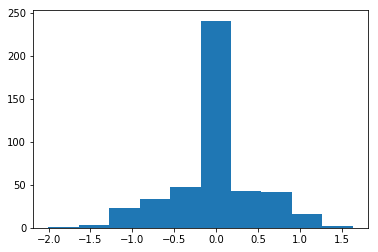

In [40]:
import matplotlib.pyplot as plt
plt.hist(y_pred[:,0]-y_test)
plt.show()

In [59]:
import keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
q=0.05
model.compile(loss=lambda y,f: tilted_loss(q,y,f),  metrics=['accuracy'], optimizer='adadelta')
model.fit(X_train_fs, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


  32/1805 [..............................] - ETA: 43s - loss: 0.3723 - acc: 0.6875

  96/1805 [>.............................] - ETA: 15s - loss: 0.2854 - acc: 0.6979

 192/1805 [==>...........................] - ETA: 7s - loss: 0.2810 - acc: 0.6562 

 256/1805 [===>..........................] - ETA: 5s - loss: 0.2635 - acc: 0.6445

 320/1805 [====>.........................] - ETA: 5s - loss: 0.2568 - acc: 0.6500

 416/1805 [=====>........................] - ETA: 4s - loss: 0.2568 - acc: 0.6226

 480/1805 [======>.......................] - ETA: 3s - loss: 0.2449 - acc: 0.6271

 544/1805 [========>.....................] - ETA: 3s - loss: 0.2382 - acc: 0.6195

 640/1805 [=========>....................] - ETA: 2s - loss: 0.2206 - acc: 0.6250

 768/1805 [===========>..................] - ETA: 2s - loss: 0.2113 - acc: 0.6263

 864/1805 [=============>................] - ETA: 1s - loss: 0.2007 - acc: 0.6285

 896/1805 [=============>................] - ETA: 1s - loss: 0.1970 - acc: 0.6250

 992/1805 [===============>..............] - ETA: 1s - loss: 0.1866 - acc: 0.5998

1088/1805 [=================>............] - ETA: 1s - loss: 0.1760 - acc: 0.5680

1184/1805 [==================>...........] - ETA: 0s - loss: 0.1687 - acc: 0.5456

1280/1805 [====================>.........] - ETA: 0s - loss: 0.1619 - acc: 0.5164

1344/1805 [=====================>........] - ETA: 0s - loss: 0.1583 - acc: 0.5052

1440/1805 [======================>.......] - ETA: 0s - loss: 0.1520 - acc: 0.4875

1568/1805 [=========================>....] - ETA: 0s - loss: 0.1446 - acc: 0.4688

1696/1805 [===========================>..] - ETA: 0s - loss: 0.1377 - acc: 0.4487

1792/1805 [============================>.] - ETA: 0s - loss: 0.1341 - acc: 0.4347

1805/1805 [==============================] - 2s 1ms/step - loss: 0.1338 - acc: 0.4349


Epoch 2/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0729 - acc: 0.2812

 128/1805 [=>............................] - ETA: 1s - loss: 0.0734 - acc: 0.2656

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0676 - acc: 0.2240

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0656 - acc: 0.2014

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0675 - acc: 0.1971

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0684 - acc: 0.2000

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0657 - acc: 0.1962

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0660 - acc: 0.2003

 832/1805 [============>.................] - ETA: 0s - loss: 0.0641 - acc: 0.2139

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0645 - acc: 0.2146

1088/1805 [=================>............] - ETA: 0s - loss: 0.0631 - acc: 0.2178

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0629 - acc: 0.2196

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0628 - acc: 0.2180

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0627 - acc: 0.2188

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0637 - acc: 0.2148

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0637 - acc: 0.2168

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0635 - acc: 0.2169

1760/1805 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.2153

1805/1805 [==============================] - 1s 696us/step - loss: 0.0632 - acc: 0.2139


Epoch 3/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0621 - acc: 0.1875

 128/1805 [=>............................] - ETA: 1s - loss: 0.0627 - acc: 0.1875

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0628 - acc: 0.1830

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0600 - acc: 0.2031

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0619 - acc: 0.2163

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0600 - acc: 0.2266

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0593 - acc: 0.2153

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0600 - acc: 0.2188

 800/1805 [============>.................] - ETA: 0s - loss: 0.0587 - acc: 0.2188

 864/1805 [=============>................] - ETA: 0s - loss: 0.0589 - acc: 0.2176

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0582 - acc: 0.2146

1056/1805 [================>.............] - ETA: 0s - loss: 0.0586 - acc: 0.2188

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0582 - acc: 0.2204

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0582 - acc: 0.2164

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0579 - acc: 0.2202

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0573 - acc: 0.2240

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0578 - acc: 0.2272

1792/1805 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.2305

1805/1805 [==============================] - 1s 599us/step - loss: 0.0573 - acc: 0.2310


Epoch 4/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0440 - acc: 0.2188

  96/1805 [>.............................] - ETA: 1s - loss: 0.0578 - acc: 0.2396

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0524 - acc: 0.2461

 384/1805 [=====>........................] - ETA: 0s - loss: 0.0514 - acc: 0.2526

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0519 - acc: 0.2555

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0525 - acc: 0.2578

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0519 - acc: 0.2663

 800/1805 [============>.................] - ETA: 0s - loss: 0.0519 - acc: 0.2687

 896/1805 [=============>................] - ETA: 0s - loss: 0.0526 - acc: 0.2600

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0522 - acc: 0.2621

1088/1805 [=================>............] - ETA: 0s - loss: 0.0525 - acc: 0.2546

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0525 - acc: 0.2526

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0518 - acc: 0.2531

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0517 - acc: 0.2565

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0520 - acc: 0.2553

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0520 - acc: 0.2598

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0515 - acc: 0.2616

1760/1805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.2653

1805/1805 [==============================] - 1s 769us/step - loss: 0.0516 - acc: 0.2681


Epoch 5/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0368 - acc: 0.3750

  96/1805 [>.............................] - ETA: 1s - loss: 0.0399 - acc: 0.3750

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0421 - acc: 0.3698

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0446 - acc: 0.3785

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0490 - acc: 0.3620

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0509 - acc: 0.3558

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0507 - acc: 0.3417

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0496 - acc: 0.3281

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0486 - acc: 0.3344

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0491 - acc: 0.3247

 832/1805 [============>.................] - ETA: 0s - loss: 0.0508 - acc: 0.3185

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0502 - acc: 0.3136

1024/1805 [================>.............] - ETA: 0s - loss: 0.0499 - acc: 0.3115

1120/1805 [=================>............] - ETA: 0s - loss: 0.0497 - acc: 0.3027

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0498 - acc: 0.2998

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0495 - acc: 0.2965

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0492 - acc: 0.2999

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0487 - acc: 0.3063

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0479 - acc: 0.3099

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0477 - acc: 0.3119

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0477 - acc: 0.3084

1805/1805 [==============================] - 1s 696us/step - loss: 0.0476 - acc: 0.3075


Epoch 6/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0444 - acc: 0.2188

  96/1805 [>.............................] - ETA: 1s - loss: 0.0588 - acc: 0.3021

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0503 - acc: 0.3333

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0495 - acc: 0.3482

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0494 - acc: 0.3523

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0480 - acc: 0.3604

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0462 - acc: 0.3715

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0452 - acc: 0.3765

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0445 - acc: 0.3893

 864/1805 [=============>................] - ETA: 0s - loss: 0.0441 - acc: 0.3889

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0443 - acc: 0.3952

1088/1805 [=================>............] - ETA: 0s - loss: 0.0444 - acc: 0.3961

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0440 - acc: 0.3972

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0441 - acc: 0.3958

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0440 - acc: 0.3954

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0442 - acc: 0.3900

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0440 - acc: 0.3924

1805/1805 [==============================] - 1s 664us/step - loss: 0.0441 - acc: 0.3950


Epoch 7/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0377 - acc: 0.5625

 160/1805 [=>............................] - ETA: 0s - loss: 0.0414 - acc: 0.4313

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0429 - acc: 0.4258

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0436 - acc: 0.4062

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0424 - acc: 0.3934

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0427 - acc: 0.3984

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0424 - acc: 0.4158

 832/1805 [============>.................] - ETA: 0s - loss: 0.0418 - acc: 0.4291

 896/1805 [=============>................] - ETA: 0s - loss: 0.0423 - acc: 0.4275

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0419 - acc: 0.4304

1088/1805 [=================>............] - ETA: 0s - loss: 0.0416 - acc: 0.4357

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0424 - acc: 0.4316

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0422 - acc: 0.4343

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0418 - acc: 0.4361

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0422 - acc: 0.4403

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0432 - acc: 0.4343

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0439 - acc: 0.4255

1760/1805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.4278

1805/1805 [==============================] - 1s 604us/step - loss: 0.0435 - acc: 0.4249


Epoch 8/100


  32/1805 [..............................] - ETA: 11s - loss: 0.0590 - acc: 0.4375

  64/1805 [>.............................] - ETA: 7s - loss: 0.0520 - acc: 0.3906 

 128/1805 [=>............................] - ETA: 4s - loss: 0.0442 - acc: 0.3984

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0413 - acc: 0.4420

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0416 - acc: 0.4188

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0436 - acc: 0.4014

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0447 - acc: 0.3945

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0430 - acc: 0.4079

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0425 - acc: 0.4034

 800/1805 [============>.................] - ETA: 0s - loss: 0.0421 - acc: 0.3962

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0426 - acc: 0.4041

1056/1805 [================>.............] - ETA: 0s - loss: 0.0423 - acc: 0.4044

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0424 - acc: 0.4062

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0421 - acc: 0.4017

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0418 - acc: 0.4090

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0425 - acc: 0.4121

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0422 - acc: 0.4148

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0420 - acc: 0.4153

1760/1805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.4239

1805/1805 [==============================] - 1s 737us/step - loss: 0.0415 - acc: 0.4233


Epoch 9/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0502 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0479 - acc: 0.4792

 128/1805 [=>............................] - ETA: 1s - loss: 0.0453 - acc: 0.4453

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0439 - acc: 0.3884

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0406 - acc: 0.4156

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0395 - acc: 0.4351

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0422 - acc: 0.4492

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0420 - acc: 0.4424

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0417 - acc: 0.4509

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0410 - acc: 0.4511

 832/1805 [============>.................] - ETA: 0s - loss: 0.0405 - acc: 0.4579

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0411 - acc: 0.4591

1024/1805 [================>.............] - ETA: 0s - loss: 0.0422 - acc: 0.4531

1120/1805 [=================>............] - ETA: 0s - loss: 0.0422 - acc: 0.4509

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0417 - acc: 0.4519

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0415 - acc: 0.4570

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0410 - acc: 0.4593

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0405 - acc: 0.4633

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0412 - acc: 0.4560

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0415 - acc: 0.4561

1760/1805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.4591

1805/1805 [==============================] - 2s 852us/step - loss: 0.0410 - acc: 0.4615


Epoch 10/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0383 - acc: 0.4062

  96/1805 [>.............................] - ETA: 1s - loss: 0.0387 - acc: 0.4271

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0369 - acc: 0.4792

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0368 - acc: 0.4896

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0368 - acc: 0.4904

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0365 - acc: 0.4922

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0370 - acc: 0.5017

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0375 - acc: 0.4922

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0365 - acc: 0.4957

 800/1805 [============>.................] - ETA: 0s - loss: 0.0363 - acc: 0.5088

 896/1805 [=============>................] - ETA: 0s - loss: 0.0367 - acc: 0.5100

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0364 - acc: 0.5111

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0369 - acc: 0.5139

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0371 - acc: 0.5068

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0373 - acc: 0.5109

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0377 - acc: 0.5087

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0379 - acc: 0.5054

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0378 - acc: 0.5096

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0382 - acc: 0.5080

1760/1805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.5057

1805/1805 [==============================] - 1s 648us/step - loss: 0.0380 - acc: 0.5025


Epoch 11/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0449 - acc: 0.4062

 128/1805 [=>............................] - ETA: 1s - loss: 0.0397 - acc: 0.4922

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0423 - acc: 0.5134

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0371 - acc: 0.5426

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0370 - acc: 0.5513

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0368 - acc: 0.5458

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0376 - acc: 0.5451

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0371 - acc: 0.5391

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0382 - acc: 0.5421

 864/1805 [=============>................] - ETA: 0s - loss: 0.0370 - acc: 0.5556

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0380 - acc: 0.5542

1056/1805 [================>.............] - ETA: 0s - loss: 0.0392 - acc: 0.5464

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0398 - acc: 0.5365

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0401 - acc: 0.5304

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0406 - acc: 0.5160

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0398 - acc: 0.5160

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0394 - acc: 0.5191

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0395 - acc: 0.5181

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0393 - acc: 0.5168

1760/1805 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.5199

1805/1805 [==============================] - 1s 792us/step - loss: 0.0393 - acc: 0.5163


Epoch 12/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0384 - acc: 0.5312

  96/1805 [>.............................] - ETA: 2s - loss: 0.0442 - acc: 0.4896

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0410 - acc: 0.4271

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0381 - acc: 0.4444

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0388 - acc: 0.4489

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0387 - acc: 0.4754

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0383 - acc: 0.4632

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0373 - acc: 0.4688

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0377 - acc: 0.4674

 896/1805 [=============>................] - ETA: 0s - loss: 0.0382 - acc: 0.4732

1024/1805 [================>.............] - ETA: 0s - loss: 0.0386 - acc: 0.4727

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0381 - acc: 0.4783

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0386 - acc: 0.4813

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0384 - acc: 0.4840

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0384 - acc: 0.4803

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0379 - acc: 0.4866

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0377 - acc: 0.4877

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0378 - acc: 0.4884

1792/1805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.4894

1805/1805 [==============================] - 1s 740us/step - loss: 0.0386 - acc: 0.4886


Epoch 13/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0379 - acc: 0.4062

 128/1805 [=>............................] - ETA: 1s - loss: 0.0395 - acc: 0.5078

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0390 - acc: 0.5104

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0402 - acc: 0.5156

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0374 - acc: 0.5312

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0363 - acc: 0.5332

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0362 - acc: 0.5181

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0356 - acc: 0.5241

 800/1805 [============>.................] - ETA: 0s - loss: 0.0352 - acc: 0.5275

 864/1805 [=============>................] - ETA: 0s - loss: 0.0353 - acc: 0.5231

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0352 - acc: 0.5280

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0356 - acc: 0.5393

1088/1805 [=================>............] - ETA: 0s - loss: 0.0357 - acc: 0.5331

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0357 - acc: 0.5295

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0358 - acc: 0.5280

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0354 - acc: 0.5258

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0359 - acc: 0.5196

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0359 - acc: 0.5251

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0359 - acc: 0.5236

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0362 - acc: 0.5180

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0362 - acc: 0.5220

1792/1805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.5206

1805/1805 [==============================] - 1s 733us/step - loss: 0.0364 - acc: 0.5197


Epoch 14/100


  32/1805 [..............................] - ETA: 0s - loss: 0.0345 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0346 - acc: 0.5312

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0333 - acc: 0.5312

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0337 - acc: 0.5278

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0342 - acc: 0.5170

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0343 - acc: 0.5000

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0348 - acc: 0.5156

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0345 - acc: 0.5156

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0347 - acc: 0.5068

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0347 - acc: 0.5052

 864/1805 [=============>................] - ETA: 0s - loss: 0.0347 - acc: 0.5035

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0344 - acc: 0.5094

1056/1805 [================>.............] - ETA: 0s - loss: 0.0351 - acc: 0.5152

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0349 - acc: 0.5191

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0355 - acc: 0.5192

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0355 - acc: 0.5183

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0357 - acc: 0.5243

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0356 - acc: 0.5286

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0356 - acc: 0.5288

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0356 - acc: 0.5255

1792/1805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.5201

1805/1805 [==============================] - 1s 824us/step - loss: 0.0360 - acc: 0.5197


Epoch 15/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0317 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0321 - acc: 0.5703

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0369 - acc: 0.5312

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0364 - acc: 0.5227

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0366 - acc: 0.5134

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0385 - acc: 0.5239

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0376 - acc: 0.5188

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0382 - acc: 0.5190

 832/1805 [============>.................] - ETA: 0s - loss: 0.0379 - acc: 0.5144

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0379 - acc: 0.5125

1056/1805 [================>.............] - ETA: 0s - loss: 0.0374 - acc: 0.5161

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0370 - acc: 0.5234

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0371 - acc: 0.5180

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0373 - acc: 0.5189

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0368 - acc: 0.5285

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0374 - acc: 0.5242

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0373 - acc: 0.5186

1760/1805 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.5205

1805/1805 [==============================] - 1s 772us/step - loss: 0.0369 - acc: 0.5219


Epoch 16/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0289 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0269 - acc: 0.6250

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0316 - acc: 0.5703

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0352 - acc: 0.5369

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0362 - acc: 0.5335

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0362 - acc: 0.5386

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0359 - acc: 0.5296

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0349 - acc: 0.5298

 800/1805 [============>.................] - ETA: 0s - loss: 0.0353 - acc: 0.5262

 896/1805 [=============>................] - ETA: 0s - loss: 0.0361 - acc: 0.5201

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0357 - acc: 0.5252

1088/1805 [=================>............] - ETA: 0s - loss: 0.0360 - acc: 0.5303

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0357 - acc: 0.5380

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0359 - acc: 0.5437

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0359 - acc: 0.5443

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0357 - acc: 0.5421

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0355 - acc: 0.5478

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0359 - acc: 0.5478

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0361 - acc: 0.5417

1792/1805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.5385

1805/1805 [==============================] - 1s 671us/step - loss: 0.0363 - acc: 0.5380


Epoch 17/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0349 - acc: 0.4062

  96/1805 [>.............................] - ETA: 2s - loss: 0.0414 - acc: 0.4167

 160/1805 [=>............................] - ETA: 2s - loss: 0.0371 - acc: 0.4688

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0355 - acc: 0.4866

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0335 - acc: 0.5139

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0325 - acc: 0.5234

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0335 - acc: 0.5458

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0342 - acc: 0.5347

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0337 - acc: 0.5391

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0345 - acc: 0.5241

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0341 - acc: 0.5326

 800/1805 [============>.................] - ETA: 1s - loss: 0.0340 - acc: 0.5300

 864/1805 [=============>................] - ETA: 1s - loss: 0.0338 - acc: 0.5347

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0335 - acc: 0.5388

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0348 - acc: 0.5403

1056/1805 [================>.............] - ETA: 0s - loss: 0.0348 - acc: 0.5341

1120/1805 [=================>............] - ETA: 0s - loss: 0.0346 - acc: 0.5321

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0344 - acc: 0.5355

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0353 - acc: 0.5367

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0353 - acc: 0.5357

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0358 - acc: 0.5334

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0358 - acc: 0.5319

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0361 - acc: 0.5344

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0359 - acc: 0.5371

1760/1805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.5335

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0364 - acc: 0.5307


Epoch 18/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0273 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0345 - acc: 0.5156

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0344 - acc: 0.5045

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0352 - acc: 0.5142

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0375 - acc: 0.5000

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0381 - acc: 0.4902

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0372 - acc: 0.4983

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0372 - acc: 0.5047

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0368 - acc: 0.5028

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0374 - acc: 0.5039

 832/1805 [============>.................] - ETA: 0s - loss: 0.0373 - acc: 0.5024

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0363 - acc: 0.5146

1056/1805 [================>.............] - ETA: 0s - loss: 0.0369 - acc: 0.5218

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0363 - acc: 0.5339

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0358 - acc: 0.5395

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0355 - acc: 0.5409

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0352 - acc: 0.5488

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0347 - acc: 0.5538

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0351 - acc: 0.5542

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0351 - acc: 0.5559

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0351 - acc: 0.5542

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0352 - acc: 0.5505

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0354 - acc: 0.5521

1805/1805 [==============================] - 2s 899us/step - loss: 0.0356 - acc: 0.5479


Epoch 19/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0350 - acc: 0.6250

  64/1805 [>.............................] - ETA: 3s - loss: 0.0350 - acc: 0.5625

  96/1805 [>.............................] - ETA: 2s - loss: 0.0305 - acc: 0.5833

 128/1805 [=>............................] - ETA: 2s - loss: 0.0343 - acc: 0.5938

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0386 - acc: 0.5848

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0381 - acc: 0.5938

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0389 - acc: 0.5824

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0368 - acc: 0.5962

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0362 - acc: 0.5979

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0371 - acc: 0.5816

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0364 - acc: 0.5640

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0361 - acc: 0.5547

 800/1805 [============>.................] - ETA: 1s - loss: 0.0367 - acc: 0.5550

 896/1805 [=============>................] - ETA: 0s - loss: 0.0365 - acc: 0.5636

1024/1805 [================>.............] - ETA: 0s - loss: 0.0361 - acc: 0.5625

1120/1805 [=================>............] - ETA: 0s - loss: 0.0363 - acc: 0.5571

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0370 - acc: 0.5510

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0365 - acc: 0.5506

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0358 - acc: 0.5523

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0357 - acc: 0.5487

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0355 - acc: 0.5507

1805/1805 [==============================] - 2s 903us/step - loss: 0.0355 - acc: 0.5501


Epoch 20/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0283 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0348 - acc: 0.6042

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0347 - acc: 0.5938

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0324 - acc: 0.5906

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0313 - acc: 0.6034

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0327 - acc: 0.5919

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0319 - acc: 0.5921

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0320 - acc: 0.5982

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0321 - acc: 0.5883

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0321 - acc: 0.5885

 832/1805 [============>.................] - ETA: 0s - loss: 0.0320 - acc: 0.5913

 896/1805 [=============>................] - ETA: 0s - loss: 0.0321 - acc: 0.5938

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0322 - acc: 0.5906

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0321 - acc: 0.5917

1056/1805 [================>.............] - ETA: 0s - loss: 0.0326 - acc: 0.5938

1120/1805 [=================>............] - ETA: 0s - loss: 0.0324 - acc: 0.5866

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0332 - acc: 0.5773

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0335 - acc: 0.5678

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0336 - acc: 0.5668

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0336 - acc: 0.5592

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0332 - acc: 0.5613

1760/1805 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.5597

1805/1805 [==============================] - 1s 747us/step - loss: 0.0338 - acc: 0.5601


Epoch 21/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0535 - acc: 0.4375

  64/1805 [>.............................] - ETA: 2s - loss: 0.0512 - acc: 0.4375

 128/1805 [=>............................] - ETA: 2s - loss: 0.0393 - acc: 0.5234

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0383 - acc: 0.5104

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0365 - acc: 0.5156

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0368 - acc: 0.5125

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0375 - acc: 0.5156

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0361 - acc: 0.5156

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0355 - acc: 0.5208

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0355 - acc: 0.5399

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0354 - acc: 0.5342

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0352 - acc: 0.5340

 832/1805 [============>.................] - ETA: 1s - loss: 0.0352 - acc: 0.5276

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0348 - acc: 0.5291

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0347 - acc: 0.5302

1024/1805 [================>.............] - ETA: 0s - loss: 0.0348 - acc: 0.5293

1056/1805 [================>.............] - ETA: 0s - loss: 0.0347 - acc: 0.5265

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0343 - acc: 0.5286

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0344 - acc: 0.5321

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0348 - acc: 0.5312

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0351 - acc: 0.5278

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0348 - acc: 0.5253

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0345 - acc: 0.5300

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0347 - acc: 0.5343

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0345 - acc: 0.5336

1760/1805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.5347

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0342 - acc: 0.5357


Epoch 22/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0827 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0462 - acc: 0.5938

 160/1805 [=>............................] - ETA: 1s - loss: 0.0426 - acc: 0.5625

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0394 - acc: 0.5469

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0395 - acc: 0.5426

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0387 - acc: 0.5409

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0383 - acc: 0.5521

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0378 - acc: 0.5451

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0370 - acc: 0.5453

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0369 - acc: 0.5369

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0371 - acc: 0.5340

 832/1805 [============>.................] - ETA: 1s - loss: 0.0374 - acc: 0.5325

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0366 - acc: 0.5399

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0365 - acc: 0.5427

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0362 - acc: 0.5423

1056/1805 [================>.............] - ETA: 0s - loss: 0.0361 - acc: 0.5398

1120/1805 [=================>............] - ETA: 0s - loss: 0.0355 - acc: 0.5437

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0355 - acc: 0.5439

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0354 - acc: 0.5481

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0349 - acc: 0.5518

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0347 - acc: 0.5533

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0348 - acc: 0.5505

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0347 - acc: 0.5517

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0346 - acc: 0.5502

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0343 - acc: 0.5519

1760/1805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.5551

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0347 - acc: 0.5557


Epoch 23/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0577 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0391 - acc: 0.5469

 160/1805 [=>............................] - ETA: 1s - loss: 0.0353 - acc: 0.5875

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0353 - acc: 0.6016

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0350 - acc: 0.5852

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0334 - acc: 0.5875

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0329 - acc: 0.5846

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0325 - acc: 0.5855

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0326 - acc: 0.5848

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0328 - acc: 0.5881

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0325 - acc: 0.5807

 896/1805 [=============>................] - ETA: 0s - loss: 0.0340 - acc: 0.5781

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0341 - acc: 0.5687

1024/1805 [================>.............] - ETA: 0s - loss: 0.0341 - acc: 0.5771

1056/1805 [================>.............] - ETA: 0s - loss: 0.0337 - acc: 0.5814

1120/1805 [=================>............] - ETA: 0s - loss: 0.0334 - acc: 0.5875

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0332 - acc: 0.5847

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0333 - acc: 0.5817

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0334 - acc: 0.5759

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0331 - acc: 0.5760

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0329 - acc: 0.5795

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0332 - acc: 0.5844

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0330 - acc: 0.5849

1760/1805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.5795

1805/1805 [==============================] - 2s 935us/step - loss: 0.0338 - acc: 0.5773


Epoch 24/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0259 - acc: 0.7500

  96/1805 [>.............................] - ETA: 2s - loss: 0.0290 - acc: 0.6667

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0369 - acc: 0.5677

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0377 - acc: 0.5703

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0367 - acc: 0.5563

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0355 - acc: 0.5649

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0360 - acc: 0.5527

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0352 - acc: 0.5543

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0359 - acc: 0.5506

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0351 - acc: 0.5598

 832/1805 [============>.................] - ETA: 0s - loss: 0.0355 - acc: 0.5577

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0350 - acc: 0.5550

1024/1805 [================>.............] - ETA: 0s - loss: 0.0350 - acc: 0.5557

1120/1805 [=================>............] - ETA: 0s - loss: 0.0348 - acc: 0.5509

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0345 - acc: 0.5532

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0350 - acc: 0.5513

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0350 - acc: 0.5473

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0358 - acc: 0.5458

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0356 - acc: 0.5417

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0356 - acc: 0.5417

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0355 - acc: 0.5469

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0358 - acc: 0.5427

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0357 - acc: 0.5430

1805/1805 [==============================] - 2s 979us/step - loss: 0.0360 - acc: 0.5374


Epoch 25/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0360 - acc: 0.4062

 128/1805 [=>............................] - ETA: 0s - loss: 0.0344 - acc: 0.4922

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0381 - acc: 0.5134

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0377 - acc: 0.4875

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0367 - acc: 0.5072

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0355 - acc: 0.5188

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0342 - acc: 0.5312

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0338 - acc: 0.5362

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0351 - acc: 0.5391

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0351 - acc: 0.5352

 864/1805 [=============>................] - ETA: 0s - loss: 0.0343 - acc: 0.5405

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0347 - acc: 0.5506

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0342 - acc: 0.5565

1056/1805 [================>.............] - ETA: 0s - loss: 0.0340 - acc: 0.5521

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0335 - acc: 0.5599

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0333 - acc: 0.5592

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0338 - acc: 0.5648

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0344 - acc: 0.5632

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0341 - acc: 0.5678

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0339 - acc: 0.5650

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0337 - acc: 0.5679

1760/1805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.5670

1805/1805 [==============================] - 1s 797us/step - loss: 0.0344 - acc: 0.5668


Epoch 26/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0310 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0300 - acc: 0.5521

 128/1805 [=>............................] - ETA: 1s - loss: 0.0301 - acc: 0.5625

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0361 - acc: 0.5670

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0392 - acc: 0.5729

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0376 - acc: 0.5795

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0375 - acc: 0.5817

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0367 - acc: 0.5848

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0364 - acc: 0.5771

 512/1805 [=======>......................] - ETA: 2s - loss: 0.0358 - acc: 0.5762

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0352 - acc: 0.5729

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0346 - acc: 0.5757

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0354 - acc: 0.5804

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0349 - acc: 0.5755

 864/1805 [=============>................] - ETA: 1s - loss: 0.0344 - acc: 0.5764

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0339 - acc: 0.5781

1056/1805 [================>.............] - ETA: 0s - loss: 0.0333 - acc: 0.5805

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0327 - acc: 0.5825

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0326 - acc: 0.5817

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0324 - acc: 0.5811

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0330 - acc: 0.5813

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0331 - acc: 0.5801

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0338 - acc: 0.5766

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0337 - acc: 0.5767

1792/1805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.5753

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0339 - acc: 0.5762


Epoch 27/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0245 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0263 - acc: 0.5729

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0319 - acc: 0.5677

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0307 - acc: 0.5938

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0315 - acc: 0.5885

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0338 - acc: 0.5833

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0332 - acc: 0.5764

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0333 - acc: 0.5859

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0350 - acc: 0.5768

 864/1805 [=============>................] - ETA: 0s - loss: 0.0348 - acc: 0.5775

 896/1805 [=============>................] - ETA: 0s - loss: 0.0347 - acc: 0.5826

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0343 - acc: 0.5827

1024/1805 [================>.............] - ETA: 0s - loss: 0.0342 - acc: 0.5811

1120/1805 [=================>............] - ETA: 0s - loss: 0.0345 - acc: 0.5768

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0343 - acc: 0.5691

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0344 - acc: 0.5719

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0341 - acc: 0.5707

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0342 - acc: 0.5729

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0345 - acc: 0.5745

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0345 - acc: 0.5727

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0348 - acc: 0.5673

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0347 - acc: 0.5677

1805/1805 [==============================] - 2s 893us/step - loss: 0.0344 - acc: 0.5701


Epoch 28/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0301 - acc: 0.6562

 160/1805 [=>............................] - ETA: 1s - loss: 0.0357 - acc: 0.5687

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0343 - acc: 0.5781

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0348 - acc: 0.5881

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0351 - acc: 0.5793

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0332 - acc: 0.5827

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0322 - acc: 0.5828

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0319 - acc: 0.5833

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0311 - acc: 0.5964

 896/1805 [=============>................] - ETA: 0s - loss: 0.0327 - acc: 0.5904

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0340 - acc: 0.5857

1056/1805 [================>.............] - ETA: 0s - loss: 0.0340 - acc: 0.5852

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0338 - acc: 0.5816

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0338 - acc: 0.5841

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0337 - acc: 0.5856

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0336 - acc: 0.5859

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0332 - acc: 0.5864

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0330 - acc: 0.5925

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0337 - acc: 0.5901

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0341 - acc: 0.5868

1792/1805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.5837

1805/1805 [==============================] - 1s 821us/step - loss: 0.0341 - acc: 0.5845


Epoch 29/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0293 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0363 - acc: 0.4792

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0367 - acc: 0.5469

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0356 - acc: 0.5451

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0345 - acc: 0.5426

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0347 - acc: 0.5491

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0337 - acc: 0.5735

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0334 - acc: 0.5799

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0332 - acc: 0.5766

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0321 - acc: 0.5856

 832/1805 [============>.................] - ETA: 0s - loss: 0.0335 - acc: 0.5781

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0351 - acc: 0.5722

1024/1805 [================>.............] - ETA: 0s - loss: 0.0352 - acc: 0.5732

1088/1805 [=================>............] - ETA: 0s - loss: 0.0349 - acc: 0.5735

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0348 - acc: 0.5720

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0343 - acc: 0.5765

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0345 - acc: 0.5678

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0344 - acc: 0.5698

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0341 - acc: 0.5722

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0346 - acc: 0.5685

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0341 - acc: 0.5727

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0340 - acc: 0.5775

1760/1805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.5756

1805/1805 [==============================] - 1s 777us/step - loss: 0.0342 - acc: 0.5751


Epoch 30/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0332 - acc: 0.4688

 128/1805 [=>............................] - ETA: 0s - loss: 0.0273 - acc: 0.6406

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0314 - acc: 0.6094

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0312 - acc: 0.6202

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0330 - acc: 0.6104

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0321 - acc: 0.6195

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0312 - acc: 0.6135

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0312 - acc: 0.6190

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0308 - acc: 0.6236

 800/1805 [============>.................] - ETA: 1s - loss: 0.0316 - acc: 0.6250

 864/1805 [=============>................] - ETA: 0s - loss: 0.0327 - acc: 0.6146

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0325 - acc: 0.6048

1088/1805 [=================>............] - ETA: 0s - loss: 0.0321 - acc: 0.6048

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0314 - acc: 0.6098

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0315 - acc: 0.6010

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0316 - acc: 0.5991

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0319 - acc: 0.5967

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0316 - acc: 0.5979

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0317 - acc: 0.5957

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0318 - acc: 0.5913

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0324 - acc: 0.5896

1792/1805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.5871

1805/1805 [==============================] - 2s 868us/step - loss: 0.0333 - acc: 0.5861


Epoch 31/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0345 - acc: 0.4375

  96/1805 [>.............................] - ETA: 1s - loss: 0.0311 - acc: 0.5625

 160/1805 [=>............................] - ETA: 1s - loss: 0.0305 - acc: 0.5875

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0315 - acc: 0.5664

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0347 - acc: 0.5540

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0359 - acc: 0.5625

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0351 - acc: 0.5496

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0350 - acc: 0.5699

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0347 - acc: 0.5638

 864/1805 [=============>................] - ETA: 0s - loss: 0.0336 - acc: 0.5729

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0334 - acc: 0.5754

1024/1805 [================>.............] - ETA: 0s - loss: 0.0330 - acc: 0.5801

1120/1805 [=================>............] - ETA: 0s - loss: 0.0329 - acc: 0.5768

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0328 - acc: 0.5737

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0330 - acc: 0.5741

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0333 - acc: 0.5686

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0333 - acc: 0.5664

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0332 - acc: 0.5676

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0331 - acc: 0.5687

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0329 - acc: 0.5721

1760/1805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.5687

1805/1805 [==============================] - 2s 853us/step - loss: 0.0328 - acc: 0.5695


Epoch 32/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0541 - acc: 0.5938

 128/1805 [=>............................] - ETA: 1s - loss: 0.0378 - acc: 0.5781

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0330 - acc: 0.5982

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0351 - acc: 0.5875

 384/1805 [=====>........................] - ETA: 0s - loss: 0.0333 - acc: 0.5885

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0344 - acc: 0.5915

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0340 - acc: 0.5957

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0330 - acc: 0.6069

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0331 - acc: 0.6071

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0333 - acc: 0.5924

 896/1805 [=============>................] - ETA: 0s - loss: 0.0328 - acc: 0.5982

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0332 - acc: 0.5990

1056/1805 [================>.............] - ETA: 0s - loss: 0.0332 - acc: 0.6061

1120/1805 [=================>............] - ETA: 0s - loss: 0.0330 - acc: 0.6054

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0325 - acc: 0.6115

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0333 - acc: 0.6102

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0331 - acc: 0.6039

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0330 - acc: 0.6026

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0332 - acc: 0.5957

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0332 - acc: 0.5968

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0332 - acc: 0.5909

1792/1805 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.5921

1805/1805 [==============================] - 1s 708us/step - loss: 0.0334 - acc: 0.5917


Epoch 33/100


  32/1805 [..............................] - ETA: 0s - loss: 0.0366 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0288 - acc: 0.5729

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0362 - acc: 0.5781

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0341 - acc: 0.5844

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0363 - acc: 0.5697

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0360 - acc: 0.5563

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0353 - acc: 0.5533

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0339 - acc: 0.5658

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0335 - acc: 0.5672

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0332 - acc: 0.5729

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0357 - acc: 0.5707

 800/1805 [============>.................] - ETA: 0s - loss: 0.0347 - acc: 0.5763

 896/1805 [=============>................] - ETA: 0s - loss: 0.0335 - acc: 0.5848

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0327 - acc: 0.5938

1056/1805 [================>.............] - ETA: 0s - loss: 0.0329 - acc: 0.5928

1120/1805 [=================>............] - ETA: 0s - loss: 0.0327 - acc: 0.5946

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0332 - acc: 0.5921

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0333 - acc: 0.5852

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0329 - acc: 0.5885

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0331 - acc: 0.5861

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0333 - acc: 0.5833

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0330 - acc: 0.5833

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0333 - acc: 0.5787

1805/1805 [==============================] - 2s 855us/step - loss: 0.0337 - acc: 0.5751


Epoch 34/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0401 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0340 - acc: 0.6250

 160/1805 [=>............................] - ETA: 1s - loss: 0.0308 - acc: 0.6125

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0322 - acc: 0.5898

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0307 - acc: 0.5994

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0331 - acc: 0.5889

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0326 - acc: 0.5833

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0326 - acc: 0.5827

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0325 - acc: 0.5789

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0318 - acc: 0.5767

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0320 - acc: 0.5781

 832/1805 [============>.................] - ETA: 0s - loss: 0.0319 - acc: 0.5781

 896/1805 [=============>................] - ETA: 0s - loss: 0.0315 - acc: 0.5781

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0313 - acc: 0.5808

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0309 - acc: 0.5833

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0313 - acc: 0.5827

1024/1805 [================>.............] - ETA: 0s - loss: 0.0312 - acc: 0.5840

1056/1805 [================>.............] - ETA: 0s - loss: 0.0312 - acc: 0.5843

1120/1805 [=================>............] - ETA: 0s - loss: 0.0309 - acc: 0.5902

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0308 - acc: 0.5921

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0306 - acc: 0.5938

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0311 - acc: 0.5991

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0313 - acc: 0.5967

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0314 - acc: 0.5952

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0312 - acc: 0.5958

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0313 - acc: 0.5951

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0315 - acc: 0.5944

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0315 - acc: 0.5920

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0321 - acc: 0.5906


Epoch 35/100
  32/1805 [..............................] - ETA: 3s - loss: 0.0296 - acc: 0.5938

  96/1805 [>.............................] - ETA: 2s - loss: 0.0302 - acc: 0.5625

 160/1805 [=>............................] - ETA: 2s - loss: 0.0308 - acc: 0.5875

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0279 - acc: 0.6071

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0271 - acc: 0.6375

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0277 - acc: 0.6322

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0290 - acc: 0.6348

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0292 - acc: 0.6372

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0310 - acc: 0.6250

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0308 - acc: 0.6159

 832/1805 [============>.................] - ETA: 0s - loss: 0.0304 - acc: 0.6130

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0306 - acc: 0.6121

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0306 - acc: 0.6139

1088/1805 [=================>............] - ETA: 0s - loss: 0.0316 - acc: 0.6121

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0323 - acc: 0.6050

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0321 - acc: 0.6003

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0331 - acc: 0.5952

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0331 - acc: 0.5910

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0332 - acc: 0.5918

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0332 - acc: 0.5900

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0330 - acc: 0.5877

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0335 - acc: 0.5856

1805/1805 [==============================] - 2s 871us/step - loss: 0.0335 - acc: 0.5823


Epoch 36/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0257 - acc: 0.5625

  96/1805 [>.............................] - ETA: 2s - loss: 0.0346 - acc: 0.5521

 160/1805 [=>............................] - ETA: 1s - loss: 0.0355 - acc: 0.5875

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0328 - acc: 0.5703

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0316 - acc: 0.5813

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0316 - acc: 0.5938

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0319 - acc: 0.5901

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0310 - acc: 0.5969

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0315 - acc: 0.5872

 896/1805 [=============>................] - ETA: 0s - loss: 0.0317 - acc: 0.5893

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0311 - acc: 0.5958

1024/1805 [================>.............] - ETA: 0s - loss: 0.0310 - acc: 0.5986

1120/1805 [=================>............] - ETA: 0s - loss: 0.0310 - acc: 0.5929

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0321 - acc: 0.5946

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0324 - acc: 0.5881

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0322 - acc: 0.5899

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0324 - acc: 0.5887

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0323 - acc: 0.5866

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0331 - acc: 0.5866

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0331 - acc: 0.5855

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0337 - acc: 0.5793

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0334 - acc: 0.5816

1792/1805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.5804

1805/1805 [==============================] - 2s 839us/step - loss: 0.0331 - acc: 0.5817


Epoch 37/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0239 - acc: 0.7188

  64/1805 [>.............................] - ETA: 2s - loss: 0.0268 - acc: 0.6250

 128/1805 [=>............................] - ETA: 2s - loss: 0.0350 - acc: 0.5859

 160/1805 [=>............................] - ETA: 4s - loss: 0.0343 - acc: 0.5687

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0337 - acc: 0.5804

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0327 - acc: 0.5660

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0331 - acc: 0.5511

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0320 - acc: 0.5601

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0312 - acc: 0.5750

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0309 - acc: 0.5680

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0306 - acc: 0.5707

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0311 - acc: 0.5739

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0311 - acc: 0.5742

 832/1805 [============>.................] - ETA: 1s - loss: 0.0314 - acc: 0.5781

 896/1805 [=============>................] - ETA: 1s - loss: 0.0309 - acc: 0.5781

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0308 - acc: 0.5817

1056/1805 [================>.............] - ETA: 0s - loss: 0.0312 - acc: 0.5871

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0313 - acc: 0.5903

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0315 - acc: 0.5880

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0314 - acc: 0.5883

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0315 - acc: 0.5908

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0317 - acc: 0.5833

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0321 - acc: 0.5801

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0323 - acc: 0.5794

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0323 - acc: 0.5775

1760/1805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.5790

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0323 - acc: 0.5795


Epoch 38/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0264 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0298 - acc: 0.6875

 160/1805 [=>............................] - ETA: 1s - loss: 0.0290 - acc: 0.6813

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0290 - acc: 0.6830

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0294 - acc: 0.6458

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0311 - acc: 0.6380

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0313 - acc: 0.6317

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0315 - acc: 0.6211

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0311 - acc: 0.6195

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0309 - acc: 0.6128

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0305 - acc: 0.6156

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0312 - acc: 0.6128

 800/1805 [============>.................] - ETA: 1s - loss: 0.0309 - acc: 0.6100

 864/1805 [=============>................] - ETA: 1s - loss: 0.0306 - acc: 0.6088

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0318 - acc: 0.6021

1024/1805 [================>.............] - ETA: 0s - loss: 0.0320 - acc: 0.6045

1120/1805 [=================>............] - ETA: 0s - loss: 0.0320 - acc: 0.6027

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0325 - acc: 0.5977

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0327 - acc: 0.5967

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0325 - acc: 0.5973

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0325 - acc: 0.5978

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0320 - acc: 0.6035

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0323 - acc: 0.6012

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0321 - acc: 0.6058

1760/1805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.5983

1805/1805 [==============================] - 2s 897us/step - loss: 0.0328 - acc: 0.5967


Epoch 39/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0289 - acc: 0.5938

  96/1805 [>.............................] - ETA: 1s - loss: 0.0287 - acc: 0.5729

 128/1805 [=>............................] - ETA: 2s - loss: 0.0287 - acc: 0.5625

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0332 - acc: 0.5670

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0336 - acc: 0.5694

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0332 - acc: 0.5750

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0329 - acc: 0.5807

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0324 - acc: 0.5848

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0317 - acc: 0.5840

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0323 - acc: 0.5839

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0320 - acc: 0.5909

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0323 - acc: 0.5938

 832/1805 [============>.................] - ETA: 0s - loss: 0.0322 - acc: 0.5889

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0314 - acc: 0.5948

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0313 - acc: 0.5948

1056/1805 [================>.............] - ETA: 0s - loss: 0.0322 - acc: 0.5985

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0320 - acc: 0.5955

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0321 - acc: 0.5904

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0319 - acc: 0.5921

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0325 - acc: 0.5893

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0328 - acc: 0.5881

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0325 - acc: 0.5836

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0322 - acc: 0.5866

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0328 - acc: 0.5869

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0326 - acc: 0.5895

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0326 - acc: 0.5908

1760/1805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.5926

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0323 - acc: 0.5967


Epoch 40/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0282 - acc: 0.5312

  96/1805 [>.............................] - ETA: 2s - loss: 0.0327 - acc: 0.5104

 160/1805 [=>............................] - ETA: 1s - loss: 0.0328 - acc: 0.5125

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0325 - acc: 0.5670

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0335 - acc: 0.5660

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0324 - acc: 0.5813

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0325 - acc: 0.5755

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0323 - acc: 0.6004

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0318 - acc: 0.5827

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0312 - acc: 0.5839

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0298 - acc: 0.6023

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0298 - acc: 0.6033

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0305 - acc: 0.6042

 800/1805 [============>.................] - ETA: 1s - loss: 0.0305 - acc: 0.6050

 864/1805 [=============>................] - ETA: 1s - loss: 0.0313 - acc: 0.6030

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0311 - acc: 0.5970

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0310 - acc: 0.5958

1024/1805 [================>.............] - ETA: 0s - loss: 0.0310 - acc: 0.5947

1056/1805 [================>.............] - ETA: 0s - loss: 0.0309 - acc: 0.5938

1120/1805 [=================>............] - ETA: 0s - loss: 0.0308 - acc: 0.5920

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0313 - acc: 0.5912

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0311 - acc: 0.5905

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0313 - acc: 0.5877

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0312 - acc: 0.5945

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0311 - acc: 0.5931

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0313 - acc: 0.5893

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0313 - acc: 0.5938

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0311 - acc: 0.5978

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0308 - acc: 0.6017


Epoch 41/100


  32/1805 [..............................] - ETA: 4s - loss: 0.0309 - acc: 0.6562

  96/1805 [>.............................] - ETA: 2s - loss: 0.0394 - acc: 0.5104

 160/1805 [=>............................] - ETA: 2s - loss: 0.0359 - acc: 0.5375

 192/1805 [==>...........................] - ETA: 2s - loss: 0.0347 - acc: 0.5521

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0338 - acc: 0.5547

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0349 - acc: 0.5531

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0341 - acc: 0.5521

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0319 - acc: 0.5792

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0318 - acc: 0.5772

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0314 - acc: 0.5888

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0315 - acc: 0.5997

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0318 - acc: 0.5964

 832/1805 [============>.................] - ETA: 1s - loss: 0.0313 - acc: 0.5901

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0317 - acc: 0.5959

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0314 - acc: 0.5927

1024/1805 [================>.............] - ETA: 0s - loss: 0.0312 - acc: 0.5967

1088/1805 [=================>............] - ETA: 0s - loss: 0.0315 - acc: 0.5983

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0319 - acc: 0.5920

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0315 - acc: 0.5946

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0322 - acc: 0.5969

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0319 - acc: 0.5967

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0317 - acc: 0.5958

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0313 - acc: 0.5957

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0314 - acc: 0.5957

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0321 - acc: 0.5987

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0321 - acc: 0.5973

1760/1805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.5960

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0319 - acc: 0.5967


Epoch 42/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0515 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0479 - acc: 0.5729

 160/1805 [=>............................] - ETA: 1s - loss: 0.0409 - acc: 0.5750

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0401 - acc: 0.6027

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0386 - acc: 0.5799

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0374 - acc: 0.5964

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0364 - acc: 0.5917

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0375 - acc: 0.5919

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0383 - acc: 0.5828

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0370 - acc: 0.5788

 800/1805 [============>.................] - ETA: 0s - loss: 0.0360 - acc: 0.5900

 864/1805 [=============>................] - ETA: 0s - loss: 0.0350 - acc: 0.5949

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0344 - acc: 0.5969

1056/1805 [================>.............] - ETA: 0s - loss: 0.0347 - acc: 0.5919

1120/1805 [=================>............] - ETA: 0s - loss: 0.0346 - acc: 0.5866

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0337 - acc: 0.5896

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0346 - acc: 0.5892

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0342 - acc: 0.5930

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0338 - acc: 0.5951

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0341 - acc: 0.5944

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0337 - acc: 0.5987

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0334 - acc: 0.6008

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0333 - acc: 0.6030

1805/1805 [==============================] - 1s 764us/step - loss: 0.0329 - acc: 0.6050


Epoch 43/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0351 - acc: 0.6562

 128/1805 [=>............................] - ETA: 1s - loss: 0.0299 - acc: 0.6406

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0288 - acc: 0.6518

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0303 - acc: 0.6667

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0309 - acc: 0.6562

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0300 - acc: 0.6635

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0297 - acc: 0.6479

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0310 - acc: 0.6445

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0311 - acc: 0.6397

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0307 - acc: 0.6372

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0301 - acc: 0.6375

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0305 - acc: 0.6384

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0297 - acc: 0.6477

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0294 - acc: 0.6406

 800/1805 [============>.................] - ETA: 1s - loss: 0.0296 - acc: 0.6388

 832/1805 [============>.................] - ETA: 1s - loss: 0.0297 - acc: 0.6358

 896/1805 [=============>................] - ETA: 1s - loss: 0.0296 - acc: 0.6306

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0295 - acc: 0.6282

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0303 - acc: 0.6250

1056/1805 [================>.............] - ETA: 1s - loss: 0.0306 - acc: 0.6269

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0305 - acc: 0.6319

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0304 - acc: 0.6308

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0303 - acc: 0.6288

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0303 - acc: 0.6295

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0301 - acc: 0.6300

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0302 - acc: 0.6283

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0301 - acc: 0.6283

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0302 - acc: 0.6256

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0300 - acc: 0.6275

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0313 - acc: 0.6256

1760/1805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.6239

1792/1805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.6228

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0314 - acc: 0.6222


Epoch 44/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0289 - acc: 0.5938

  96/1805 [>.............................] - ETA: 5s - loss: 0.0285 - acc: 0.5833

 160/1805 [=>............................] - ETA: 3s - loss: 0.0322 - acc: 0.5500

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0299 - acc: 0.5759

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0286 - acc: 0.5969

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0320 - acc: 0.6042

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0317 - acc: 0.6161

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0317 - acc: 0.6094

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0321 - acc: 0.6094

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0321 - acc: 0.6031

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0311 - acc: 0.6073

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0306 - acc: 0.6107

 800/1805 [============>.................] - ETA: 1s - loss: 0.0301 - acc: 0.6138

 896/1805 [=============>................] - ETA: 1s - loss: 0.0312 - acc: 0.6239

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0308 - acc: 0.6293

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0305 - acc: 0.6323

1056/1805 [================>.............] - ETA: 0s - loss: 0.0305 - acc: 0.6288

1120/1805 [=================>............] - ETA: 0s - loss: 0.0303 - acc: 0.6321

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0306 - acc: 0.6292

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0312 - acc: 0.6194

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0314 - acc: 0.6159

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0313 - acc: 0.6122

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0313 - acc: 0.6097

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0312 - acc: 0.6090

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0311 - acc: 0.6094

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0317 - acc: 0.6058

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0315 - acc: 0.6071

1792/1805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.6055

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0315 - acc: 0.6066


Epoch 45/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0385 - acc: 0.5625

  64/1805 [>.............................] - ETA: 3s - loss: 0.0306 - acc: 0.6094

 128/1805 [=>............................] - ETA: 5s - loss: 0.0356 - acc: 0.6016

 192/1805 [==>...........................] - ETA: 3s - loss: 0.0306 - acc: 0.6354

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0306 - acc: 0.6116

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0299 - acc: 0.6181

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0304 - acc: 0.6193

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0301 - acc: 0.6106

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0315 - acc: 0.6152

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0314 - acc: 0.6176

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0313 - acc: 0.6128

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0303 - acc: 0.6234

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0302 - acc: 0.6190

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0304 - acc: 0.6168

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0305 - acc: 0.6081

 800/1805 [============>.................] - ETA: 1s - loss: 0.0302 - acc: 0.6075

 864/1805 [=============>................] - ETA: 1s - loss: 0.0301 - acc: 0.6146

 896/1805 [=============>................] - ETA: 1s - loss: 0.0300 - acc: 0.6138

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0298 - acc: 0.6208

1024/1805 [================>.............] - ETA: 1s - loss: 0.0299 - acc: 0.6172

1088/1805 [=================>............] - ETA: 0s - loss: 0.0298 - acc: 0.6204

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0297 - acc: 0.6140

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0294 - acc: 0.6186

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0296 - acc: 0.6227

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0299 - acc: 0.6206

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0298 - acc: 0.6207

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0300 - acc: 0.6168

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0304 - acc: 0.6094

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0301 - acc: 0.6106

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0301 - acc: 0.6130

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0300 - acc: 0.6128

1760/1805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.6131

1792/1805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.6099

1805/1805 [==============================] - 3s 1ms/step - loss: 0.0303 - acc: 0.6100


Epoch 46/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0485 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0442 - acc: 0.5312

 160/1805 [=>............................] - ETA: 1s - loss: 0.0406 - acc: 0.5125

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0389 - acc: 0.5089

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0364 - acc: 0.5104

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0357 - acc: 0.5469

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0357 - acc: 0.5402

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0352 - acc: 0.5449

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0344 - acc: 0.5556

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0340 - acc: 0.5521

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0327 - acc: 0.5703

 832/1805 [============>.................] - ETA: 0s - loss: 0.0338 - acc: 0.5709

 864/1805 [=============>................] - ETA: 0s - loss: 0.0339 - acc: 0.5718

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0337 - acc: 0.5819

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0332 - acc: 0.5867

1056/1805 [================>.............] - ETA: 0s - loss: 0.0327 - acc: 0.5900

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0327 - acc: 0.5842

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0318 - acc: 0.5946

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0319 - acc: 0.5976

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0319 - acc: 0.5980

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0315 - acc: 0.5999

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0313 - acc: 0.6029

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0313 - acc: 0.6031

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0308 - acc: 0.6064

1760/1805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.6085

1805/1805 [==============================] - 2s 901us/step - loss: 0.0306 - acc: 0.6122


Epoch 47/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0222 - acc: 0.6562

  96/1805 [>.............................] - ETA: 2s - loss: 0.0229 - acc: 0.6771

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0248 - acc: 0.6562

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0260 - acc: 0.6250

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0273 - acc: 0.6364

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0293 - acc: 0.6250

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0291 - acc: 0.6229

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0296 - acc: 0.6176

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0291 - acc: 0.6151

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0309 - acc: 0.6220

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0299 - acc: 0.6237

 864/1805 [=============>................] - ETA: 1s - loss: 0.0299 - acc: 0.6181

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0299 - acc: 0.6175

1024/1805 [================>.............] - ETA: 0s - loss: 0.0299 - acc: 0.6172

1088/1805 [=================>............] - ETA: 0s - loss: 0.0295 - acc: 0.6232

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0293 - acc: 0.6319

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0291 - acc: 0.6299

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0291 - acc: 0.6320

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0295 - acc: 0.6317

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0305 - acc: 0.6202

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0303 - acc: 0.6200

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0306 - acc: 0.6173

1792/1805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.6183

1805/1805 [==============================] - 2s 926us/step - loss: 0.0303 - acc: 0.6166


Epoch 48/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0286 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0344 - acc: 0.5625

 160/1805 [=>............................] - ETA: 1s - loss: 0.0376 - acc: 0.5875

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0356 - acc: 0.5848

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0330 - acc: 0.6076

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0302 - acc: 0.6250

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0308 - acc: 0.6167

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0302 - acc: 0.6158

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0294 - acc: 0.6201

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0300 - acc: 0.6235

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0299 - acc: 0.6209

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0297 - acc: 0.6224

 832/1805 [============>.................] - ETA: 1s - loss: 0.0295 - acc: 0.6226

 896/1805 [=============>................] - ETA: 1s - loss: 0.0290 - acc: 0.6250

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0287 - acc: 0.6260

1056/1805 [================>.............] - ETA: 0s - loss: 0.0290 - acc: 0.6278

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0298 - acc: 0.6285

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0293 - acc: 0.6338

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0293 - acc: 0.6349

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0297 - acc: 0.6301

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0295 - acc: 0.6306

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0297 - acc: 0.6270

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0295 - acc: 0.6250

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0298 - acc: 0.6232

1760/1805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.6290

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0300 - acc: 0.6277


Epoch 49/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0238 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.0352 - acc: 0.5703

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0317 - acc: 0.5833

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0323 - acc: 0.6250

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0310 - acc: 0.6120

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0308 - acc: 0.6125

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0308 - acc: 0.6066

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0302 - acc: 0.6062

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0310 - acc: 0.6046

 800/1805 [============>.................] - ETA: 0s - loss: 0.0309 - acc: 0.6038

 864/1805 [=============>................] - ETA: 0s - loss: 0.0307 - acc: 0.6019

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0306 - acc: 0.6002

1024/1805 [================>.............] - ETA: 0s - loss: 0.0304 - acc: 0.5996

1088/1805 [=================>............] - ETA: 0s - loss: 0.0301 - acc: 0.6094

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0294 - acc: 0.6181

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0292 - acc: 0.6176

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0292 - acc: 0.6138

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0299 - acc: 0.6159

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0297 - acc: 0.6170

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0295 - acc: 0.6186

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0293 - acc: 0.6216

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0295 - acc: 0.6243

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0295 - acc: 0.6225

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0294 - acc: 0.6244

1760/1805 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.6233

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0295 - acc: 0.6205


Epoch 50/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0647 - acc: 0.4688

 128/1805 [=>............................] - ETA: 1s - loss: 0.0383 - acc: 0.5703

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0322 - acc: 0.6071

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0326 - acc: 0.5969

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0313 - acc: 0.6068

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0301 - acc: 0.6094

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0301 - acc: 0.6195

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0303 - acc: 0.6156

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0307 - acc: 0.6122

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0302 - acc: 0.6159

 832/1805 [============>.................] - ETA: 0s - loss: 0.0302 - acc: 0.6094

 896/1805 [=============>................] - ETA: 0s - loss: 0.0298 - acc: 0.6116

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0305 - acc: 0.6104

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0303 - acc: 0.6119

1056/1805 [================>.............] - ETA: 0s - loss: 0.0315 - acc: 0.6061

1120/1805 [=================>............] - ETA: 0s - loss: 0.0312 - acc: 0.6080

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0310 - acc: 0.6081

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0302 - acc: 0.6164

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0300 - acc: 0.6183

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0298 - acc: 0.6165

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0296 - acc: 0.6168

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0298 - acc: 0.6204

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0298 - acc: 0.6175

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0298 - acc: 0.6196

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0298 - acc: 0.6198

1805/1805 [==============================] - 2s 975us/step - loss: 0.0298 - acc: 0.6222


Epoch 51/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0207 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0368 - acc: 0.6562

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0314 - acc: 0.6741

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0300 - acc: 0.6667

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0322 - acc: 0.6392

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0307 - acc: 0.6339

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0303 - acc: 0.6270

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0306 - acc: 0.6480

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0307 - acc: 0.6414

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0302 - acc: 0.6354

 832/1805 [============>.................] - ETA: 0s - loss: 0.0300 - acc: 0.6310

 896/1805 [=============>................] - ETA: 0s - loss: 0.0302 - acc: 0.6250

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0301 - acc: 0.6272

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0298 - acc: 0.6271

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0298 - acc: 0.6240

1056/1805 [================>.............] - ETA: 0s - loss: 0.0302 - acc: 0.6222

1120/1805 [=================>............] - ETA: 0s - loss: 0.0303 - acc: 0.6188

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0303 - acc: 0.6166

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0303 - acc: 0.6162

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0300 - acc: 0.6220

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0299 - acc: 0.6215

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0300 - acc: 0.6217

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0302 - acc: 0.6186

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0304 - acc: 0.6183

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0305 - acc: 0.6162

1760/1805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.6170

1792/1805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.6172

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0308 - acc: 0.6172


Epoch 52/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0550 - acc: 0.5625

  64/1805 [>.............................] - ETA: 2s - loss: 0.0414 - acc: 0.5938

 128/1805 [=>............................] - ETA: 2s - loss: 0.0308 - acc: 0.6484

 192/1805 [==>...........................] - ETA: 2s - loss: 0.0300 - acc: 0.6406

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0318 - acc: 0.6250

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0320 - acc: 0.6000

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0321 - acc: 0.5885

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0309 - acc: 0.5893

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0300 - acc: 0.5958

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0306 - acc: 0.5956

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0303 - acc: 0.5955

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0307 - acc: 0.5938

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0304 - acc: 0.5966

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0301 - acc: 0.5977

 864/1805 [=============>................] - ETA: 1s - loss: 0.0303 - acc: 0.6053

 896/1805 [=============>................] - ETA: 1s - loss: 0.0302 - acc: 0.6049

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0300 - acc: 0.6078

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0303 - acc: 0.5978

1056/1805 [================>.............] - ETA: 0s - loss: 0.0297 - acc: 0.6051

1120/1805 [=================>............] - ETA: 0s - loss: 0.0299 - acc: 0.6071

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0299 - acc: 0.6094

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0307 - acc: 0.6066

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0305 - acc: 0.6090

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0299 - acc: 0.6163

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0301 - acc: 0.6146

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0303 - acc: 0.6155

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0307 - acc: 0.6150

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0309 - acc: 0.6167

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0304 - acc: 0.6196

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0302 - acc: 0.6203

1760/1805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.6199

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0303 - acc: 0.6205


Epoch 53/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0356 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0356 - acc: 0.5521

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0337 - acc: 0.5312

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0321 - acc: 0.5417

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0318 - acc: 0.5437

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0320 - acc: 0.5625

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0314 - acc: 0.5714

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0298 - acc: 0.5918

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0294 - acc: 0.5920

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0299 - acc: 0.5938

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0296 - acc: 0.5938

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0291 - acc: 0.6060

 800/1805 [============>.................] - ETA: 0s - loss: 0.0289 - acc: 0.6050

 864/1805 [=============>................] - ETA: 0s - loss: 0.0285 - acc: 0.6088

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0291 - acc: 0.6067

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0296 - acc: 0.6200

1056/1805 [================>.............] - ETA: 0s - loss: 0.0294 - acc: 0.6174

1120/1805 [=================>............] - ETA: 0s - loss: 0.0293 - acc: 0.6143

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0304 - acc: 0.6157

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0301 - acc: 0.6178

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0301 - acc: 0.6151

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0302 - acc: 0.6163

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0301 - acc: 0.6172

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0303 - acc: 0.6168

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0301 - acc: 0.6177

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0298 - acc: 0.6212

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0295 - acc: 0.6213

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0295 - acc: 0.6221

1792/1805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.6261

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0292 - acc: 0.6266


Epoch 54/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0294 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0328 - acc: 0.6172

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0327 - acc: 0.6406

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0307 - acc: 0.6424

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0310 - acc: 0.6406

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0334 - acc: 0.6362

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0318 - acc: 0.6452

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0311 - acc: 0.6453

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0311 - acc: 0.6414

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0308 - acc: 0.6435

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0305 - acc: 0.6413

 800/1805 [============>.................] - ETA: 1s - loss: 0.0302 - acc: 0.6425

 864/1805 [=============>................] - ETA: 1s - loss: 0.0303 - acc: 0.6389

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0298 - acc: 0.6365

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0297 - acc: 0.6371

1088/1805 [=================>............] - ETA: 0s - loss: 0.0292 - acc: 0.6360

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0294 - acc: 0.6389

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0291 - acc: 0.6431

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0288 - acc: 0.6425

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0285 - acc: 0.6477

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0288 - acc: 0.6436

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0283 - acc: 0.6495

1760/1805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.6477

1792/1805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.6468

1805/1805 [==============================] - 2s 969us/step - loss: 0.0283 - acc: 0.6476


Epoch 55/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0212 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.0379 - acc: 0.5938

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0353 - acc: 0.5938

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0355 - acc: 0.5804

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0354 - acc: 0.5694

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0343 - acc: 0.5739

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0353 - acc: 0.5841

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0348 - acc: 0.5854

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0359 - acc: 0.5846

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0349 - acc: 0.5954

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0342 - acc: 0.5997

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0340 - acc: 0.6037

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0335 - acc: 0.6087

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0332 - acc: 0.6094

 832/1805 [============>.................] - ETA: 1s - loss: 0.0337 - acc: 0.6202

 896/1805 [=============>................] - ETA: 1s - loss: 0.0330 - acc: 0.6183

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0332 - acc: 0.6219

1024/1805 [================>.............] - ETA: 1s - loss: 0.0326 - acc: 0.6230

1088/1805 [=================>............] - ETA: 1s - loss: 0.0328 - acc: 0.6222

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0327 - acc: 0.6224

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0321 - acc: 0.6234

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0322 - acc: 0.6258

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0320 - acc: 0.6235

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0320 - acc: 0.6243

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0316 - acc: 0.6236

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0315 - acc: 0.6250

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0311 - acc: 0.6262

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0310 - acc: 0.6256

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0307 - acc: 0.6238

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0310 - acc: 0.6215

1792/1805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.6233

1805/1805 [==============================] - 3s 1ms/step - loss: 0.0310 - acc: 0.6238


Epoch 56/100
  32/1805 [..............................] - ETA: 3s - loss: 0.0274 - acc: 0.6562

  64/1805 [>.............................] - ETA: 3s - loss: 0.0288 - acc: 0.5938

 160/1805 [=>............................] - ETA: 1s - loss: 0.0253 - acc: 0.6500

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0273 - acc: 0.6250

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0286 - acc: 0.6181

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0283 - acc: 0.6193

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0290 - acc: 0.6205

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0284 - acc: 0.6211

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0277 - acc: 0.6198

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0279 - acc: 0.6219

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0287 - acc: 0.6222

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0291 - acc: 0.6263

 832/1805 [============>.................] - ETA: 1s - loss: 0.0289 - acc: 0.6286

 896/1805 [=============>................] - ETA: 0s - loss: 0.0288 - acc: 0.6272

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0290 - acc: 0.6260

1024/1805 [================>.............] - ETA: 0s - loss: 0.0288 - acc: 0.6230

1088/1805 [=================>............] - ETA: 0s - loss: 0.0294 - acc: 0.6222

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0291 - acc: 0.6215

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0290 - acc: 0.6242

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0285 - acc: 0.6273

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0290 - acc: 0.6243

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0288 - acc: 0.6250

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0288 - acc: 0.6263

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0288 - acc: 0.6275

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0287 - acc: 0.6319

1792/1805 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.6317

1805/1805 [==============================] - 2s 929us/step - loss: 0.0287 - acc: 0.6316


Epoch 57/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0265 - acc: 0.6250

  64/1805 [>.............................] - ETA: 1s - loss: 0.0303 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0272 - acc: 0.5859

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0254 - acc: 0.6146

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0249 - acc: 0.6328

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0247 - acc: 0.6354

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0250 - acc: 0.6307

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0259 - acc: 0.6514

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0263 - acc: 0.6458

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0269 - acc: 0.6434

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0270 - acc: 0.6365

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0267 - acc: 0.6344

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0273 - acc: 0.6321

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0270 - acc: 0.6372

 800/1805 [============>.................] - ETA: 1s - loss: 0.0283 - acc: 0.6375

 864/1805 [=============>................] - ETA: 1s - loss: 0.0281 - acc: 0.6377

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0279 - acc: 0.6379

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0275 - acc: 0.6401

1088/1805 [=================>............] - ETA: 1s - loss: 0.0287 - acc: 0.6406

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0284 - acc: 0.6377

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0285 - acc: 0.6394

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0288 - acc: 0.6357

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0290 - acc: 0.6324

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0286 - acc: 0.6349

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0290 - acc: 0.6347

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0290 - acc: 0.6345

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0293 - acc: 0.6335

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0289 - acc: 0.6362

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0288 - acc: 0.6360

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0290 - acc: 0.6397

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0290 - acc: 0.6389

1792/1805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.6384

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0294 - acc: 0.6382


Epoch 58/100


  32/1805 [..............................] - ETA: 12s - loss: 0.0374 - acc: 0.5312

  64/1805 [>.............................] - ETA: 7s - loss: 0.0315 - acc: 0.6250 

  96/1805 [>.............................] - ETA: 6s - loss: 0.0320 - acc: 0.5833

 160/1805 [=>............................] - ETA: 4s - loss: 0.0318 - acc: 0.6062

 192/1805 [==>...........................] - ETA: 4s - loss: 0.0317 - acc: 0.5990

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0320 - acc: 0.6071

 256/1805 [===>..........................] - ETA: 3s - loss: 0.0309 - acc: 0.6133

 320/1805 [====>.........................] - ETA: 3s - loss: 0.0296 - acc: 0.6344

 352/1805 [====>.........................] - ETA: 3s - loss: 0.0292 - acc: 0.6392

 384/1805 [=====>........................] - ETA: 3s - loss: 0.0297 - acc: 0.6328

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0309 - acc: 0.6226

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0303 - acc: 0.6312

 576/1805 [========>.....................] - ETA: 2s - loss: 0.0306 - acc: 0.6233

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0303 - acc: 0.6161

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0300 - acc: 0.6114

 800/1805 [============>.................] - ETA: 1s - loss: 0.0297 - acc: 0.6212

 832/1805 [============>.................] - ETA: 1s - loss: 0.0295 - acc: 0.6190

 864/1805 [=============>................] - ETA: 1s - loss: 0.0299 - acc: 0.6250

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0295 - acc: 0.6304

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0291 - acc: 0.6290

1056/1805 [================>.............] - ETA: 1s - loss: 0.0286 - acc: 0.6326

1120/1805 [=================>............] - ETA: 1s - loss: 0.0283 - acc: 0.6348

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0286 - acc: 0.6377

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0290 - acc: 0.6359

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0287 - acc: 0.6376

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0287 - acc: 0.6371

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0301 - acc: 0.6365

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0303 - acc: 0.6361

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0306 - acc: 0.6336

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0304 - acc: 0.6344

1760/1805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.6352

1792/1805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.6350

1805/1805 [==============================] - 3s 1ms/step - loss: 0.0301 - acc: 0.6360


Epoch 59/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0262 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0294 - acc: 0.5938

 128/1805 [=>............................] - ETA: 2s - loss: 0.0266 - acc: 0.6250

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0275 - acc: 0.6354

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0294 - acc: 0.6406

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0295 - acc: 0.6312

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0292 - acc: 0.6302

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0309 - acc: 0.6274

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0322 - acc: 0.6229

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0309 - acc: 0.6305

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0303 - acc: 0.6299

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0290 - acc: 0.6414

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0290 - acc: 0.6454

 800/1805 [============>.................] - ETA: 1s - loss: 0.0289 - acc: 0.6488

 864/1805 [=============>................] - ETA: 0s - loss: 0.0301 - acc: 0.6470

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0299 - acc: 0.6519

1024/1805 [================>.............] - ETA: 0s - loss: 0.0304 - acc: 0.6494

1088/1805 [=================>............] - ETA: 0s - loss: 0.0302 - acc: 0.6434

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0302 - acc: 0.6450

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0300 - acc: 0.6431

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0310 - acc: 0.6375

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0308 - acc: 0.6436

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0305 - acc: 0.6442

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0303 - acc: 0.6433

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0300 - acc: 0.6452

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0300 - acc: 0.6444

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0298 - acc: 0.6448

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0301 - acc: 0.6468

1760/1805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.6426

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0300 - acc: 0.6416


Epoch 60/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0244 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0313 - acc: 0.6458

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0304 - acc: 0.6354

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0285 - acc: 0.6328

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0294 - acc: 0.6438

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0288 - acc: 0.6611

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0284 - acc: 0.6562

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0280 - acc: 0.6526

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0286 - acc: 0.6579

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0282 - acc: 0.6518

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0283 - acc: 0.6386

 832/1805 [============>.................] - ETA: 0s - loss: 0.0282 - acc: 0.6346

 896/1805 [=============>................] - ETA: 0s - loss: 0.0284 - acc: 0.6373

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0284 - acc: 0.6347

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0283 - acc: 0.6344

1024/1805 [================>.............] - ETA: 0s - loss: 0.0282 - acc: 0.6328

1088/1805 [=================>............] - ETA: 0s - loss: 0.0281 - acc: 0.6333

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0284 - acc: 0.6258

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0289 - acc: 0.6226

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0286 - acc: 0.6280

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0284 - acc: 0.6257

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0292 - acc: 0.6209

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0297 - acc: 0.6198

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0294 - acc: 0.6225

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0294 - acc: 0.6220

1760/1805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.6256

1805/1805 [==============================] - 2s 903us/step - loss: 0.0292 - acc: 0.6244


Epoch 61/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0341 - acc: 0.5938

  96/1805 [>.............................] - ETA: 1s - loss: 0.0286 - acc: 0.6771

 160/1805 [=>............................] - ETA: 1s - loss: 0.0322 - acc: 0.6438

 192/1805 [==>...........................] - ETA: 3s - loss: 0.0313 - acc: 0.6354

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0320 - acc: 0.6133

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0351 - acc: 0.6000

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0329 - acc: 0.6198

 448/1805 [======>.......................] - ETA: 2s - loss: 0.0327 - acc: 0.6161

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0336 - acc: 0.6172

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0323 - acc: 0.6215

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0318 - acc: 0.6283

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0314 - acc: 0.6250

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0308 - acc: 0.6277

 800/1805 [============>.................] - ETA: 1s - loss: 0.0304 - acc: 0.6275

 864/1805 [=============>................] - ETA: 1s - loss: 0.0310 - acc: 0.6215

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0306 - acc: 0.6292

1024/1805 [================>.............] - ETA: 0s - loss: 0.0303 - acc: 0.6309

1120/1805 [=================>............] - ETA: 0s - loss: 0.0295 - acc: 0.6286

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0301 - acc: 0.6334

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0300 - acc: 0.6306

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0302 - acc: 0.6332

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0302 - acc: 0.6321

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0300 - acc: 0.6318

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0298 - acc: 0.6328

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0294 - acc: 0.6360

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0301 - acc: 0.6319

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0306 - acc: 0.6305


Epoch 62/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0224 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.0296 - acc: 0.5547

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0271 - acc: 0.5759

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0304 - acc: 0.5875

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0294 - acc: 0.6042

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0285 - acc: 0.6188

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0283 - acc: 0.6211

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0291 - acc: 0.6184

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0290 - acc: 0.6220

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0288 - acc: 0.6198

 864/1805 [=============>................] - ETA: 0s - loss: 0.0279 - acc: 0.6296

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0287 - acc: 0.6293

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0284 - acc: 0.6280

1088/1805 [=================>............] - ETA: 0s - loss: 0.0282 - acc: 0.6250

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0279 - acc: 0.6340

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0284 - acc: 0.6369

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0287 - acc: 0.6314

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0287 - acc: 0.6277

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0284 - acc: 0.6309

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0283 - acc: 0.6306

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0289 - acc: 0.6304

1760/1805 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.6312

1805/1805 [==============================] - 2s 857us/step - loss: 0.0288 - acc: 0.6299


Epoch 63/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0244 - acc: 0.6250

 128/1805 [=>............................] - ETA: 0s - loss: 0.0250 - acc: 0.6562

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0245 - acc: 0.6518

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0243 - acc: 0.6676

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0243 - acc: 0.6641

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0252 - acc: 0.6646

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0255 - acc: 0.6562

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0258 - acc: 0.6545

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0275 - acc: 0.6364

 800/1805 [============>.................] - ETA: 0s - loss: 0.0282 - acc: 0.6262

 864/1805 [=============>................] - ETA: 0s - loss: 0.0281 - acc: 0.6262

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0279 - acc: 0.6282

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0281 - acc: 0.6280

1088/1805 [=================>............] - ETA: 0s - loss: 0.0273 - acc: 0.6388

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0270 - acc: 0.6478

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0269 - acc: 0.6514

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0268 - acc: 0.6516

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0269 - acc: 0.6488

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0271 - acc: 0.6490

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0269 - acc: 0.6484

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0273 - acc: 0.6503

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0281 - acc: 0.6475

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0287 - acc: 0.6492

1792/1805 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.6462

1805/1805 [==============================] - 2s 908us/step - loss: 0.0286 - acc: 0.6454


Epoch 64/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0247 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0320 - acc: 0.6354

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0299 - acc: 0.6562

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0310 - acc: 0.6493

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0298 - acc: 0.6484

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0288 - acc: 0.6458

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0277 - acc: 0.6544

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0274 - acc: 0.6628

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0294 - acc: 0.6619

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0290 - acc: 0.6602

 832/1805 [============>.................] - ETA: 0s - loss: 0.0286 - acc: 0.6599

 896/1805 [=============>................] - ETA: 0s - loss: 0.0288 - acc: 0.6574

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0288 - acc: 0.6510

1056/1805 [================>.............] - ETA: 0s - loss: 0.0292 - acc: 0.6496

1120/1805 [=================>............] - ETA: 0s - loss: 0.0286 - acc: 0.6527

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0284 - acc: 0.6519

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0283 - acc: 0.6456

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0279 - acc: 0.6531

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0279 - acc: 0.6540

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0278 - acc: 0.6541

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0286 - acc: 0.6556

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0289 - acc: 0.6524

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0290 - acc: 0.6489

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0289 - acc: 0.6478

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0289 - acc: 0.6453

1792/1805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.6451

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0291 - acc: 0.6443


Epoch 65/100


  32/1805 [..............................] - ETA: 4s - loss: 0.0197 - acc: 0.7188

  64/1805 [>.............................] - ETA: 3s - loss: 0.0286 - acc: 0.5625

 128/1805 [=>............................] - ETA: 2s - loss: 0.0306 - acc: 0.5781

 192/1805 [==>...........................] - ETA: 2s - loss: 0.0279 - acc: 0.5990

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0268 - acc: 0.6211

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0271 - acc: 0.6406

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0284 - acc: 0.6406

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0272 - acc: 0.6562

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0266 - acc: 0.6543

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0281 - acc: 0.6441

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0297 - acc: 0.6328

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0297 - acc: 0.6359

 800/1805 [============>.................] - ETA: 1s - loss: 0.0305 - acc: 0.6312

 864/1805 [=============>................] - ETA: 0s - loss: 0.0308 - acc: 0.6296

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0307 - acc: 0.6293

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0310 - acc: 0.6240

1056/1805 [================>.............] - ETA: 0s - loss: 0.0308 - acc: 0.6316

1120/1805 [=================>............] - ETA: 0s - loss: 0.0317 - acc: 0.6277

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0315 - acc: 0.6216

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0322 - acc: 0.6194

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0319 - acc: 0.6212

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0316 - acc: 0.6214

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0316 - acc: 0.6194

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0312 - acc: 0.6198

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0307 - acc: 0.6238

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0307 - acc: 0.6219

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0309 - acc: 0.6203

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0311 - acc: 0.6221

1760/1805 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.6193

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0311 - acc: 0.6205


Epoch 66/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0296 - acc: 0.5000

  96/1805 [>.............................] - ETA: 2s - loss: 0.0345 - acc: 0.5938

 160/1805 [=>............................] - ETA: 2s - loss: 0.0297 - acc: 0.6562

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0291 - acc: 0.6429

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0309 - acc: 0.6458

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0294 - acc: 0.6477

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0286 - acc: 0.6473

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0286 - acc: 0.6348

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0288 - acc: 0.6406

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0279 - acc: 0.6488

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0278 - acc: 0.6477

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0275 - acc: 0.6484

 864/1805 [=============>................] - ETA: 1s - loss: 0.0265 - acc: 0.6574

 896/1805 [=============>................] - ETA: 1s - loss: 0.0263 - acc: 0.6574

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0274 - acc: 0.6625

1024/1805 [================>.............] - ETA: 0s - loss: 0.0279 - acc: 0.6611

1088/1805 [=================>............] - ETA: 0s - loss: 0.0275 - acc: 0.6645

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0275 - acc: 0.6606

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0272 - acc: 0.6630

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0276 - acc: 0.6579

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0275 - acc: 0.6547

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0275 - acc: 0.6548

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0276 - acc: 0.6533

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0275 - acc: 0.6521

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0275 - acc: 0.6543

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0274 - acc: 0.6531

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0274 - acc: 0.6495

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0276 - acc: 0.6472

1760/1805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.6460

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0273 - acc: 0.6465


Epoch 67/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0171 - acc: 0.8438

  64/1805 [>.............................] - ETA: 2s - loss: 0.0212 - acc: 0.7344

 128/1805 [=>............................] - ETA: 1s - loss: 0.0330 - acc: 0.6328

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0310 - acc: 0.6473

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0322 - acc: 0.6424

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0335 - acc: 0.6449

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0319 - acc: 0.6442

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0305 - acc: 0.6521

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0314 - acc: 0.6452

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0317 - acc: 0.6530

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0310 - acc: 0.6518

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0307 - acc: 0.6454

 832/1805 [============>.................] - ETA: 0s - loss: 0.0302 - acc: 0.6442

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0299 - acc: 0.6444

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0297 - acc: 0.6458

1024/1805 [================>.............] - ETA: 0s - loss: 0.0296 - acc: 0.6416

1088/1805 [=================>............] - ETA: 0s - loss: 0.0299 - acc: 0.6369

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0300 - acc: 0.6351

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0297 - acc: 0.6375

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0297 - acc: 0.6339

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0295 - acc: 0.6328

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0296 - acc: 0.6338

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0293 - acc: 0.6371

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0298 - acc: 0.6322

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0296 - acc: 0.6331

1792/1805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.6328

1805/1805 [==============================] - 2s 846us/step - loss: 0.0297 - acc: 0.6332


Epoch 68/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0256 - acc: 0.6562

 128/1805 [=>............................] - ETA: 1s - loss: 0.0284 - acc: 0.5938

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0299 - acc: 0.6328

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0291 - acc: 0.6364

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0289 - acc: 0.6295

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0281 - acc: 0.6287

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0279 - acc: 0.6267

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0271 - acc: 0.6344

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0291 - acc: 0.6302

 832/1805 [============>.................] - ETA: 0s - loss: 0.0300 - acc: 0.6274

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0291 - acc: 0.6358

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0289 - acc: 0.6401

1056/1805 [================>.............] - ETA: 0s - loss: 0.0287 - acc: 0.6402

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0284 - acc: 0.6458

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0283 - acc: 0.6447

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0284 - acc: 0.6418

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0283 - acc: 0.6406

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0293 - acc: 0.6365

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0291 - acc: 0.6429

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0291 - acc: 0.6434

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0291 - acc: 0.6415

1792/1805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.6451

1805/1805 [==============================] - 2s 890us/step - loss: 0.0290 - acc: 0.6438


Epoch 69/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0207 - acc: 0.7188

  96/1805 [>.............................] - ETA: 2s - loss: 0.0247 - acc: 0.6771

 160/1805 [=>............................] - ETA: 1s - loss: 0.0267 - acc: 0.6438

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0297 - acc: 0.6205

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0298 - acc: 0.6156

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0291 - acc: 0.6120

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0284 - acc: 0.6228

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0278 - acc: 0.6211

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0283 - acc: 0.6250

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0280 - acc: 0.6278

 800/1805 [============>.................] - ETA: 0s - loss: 0.0281 - acc: 0.6300

 864/1805 [=============>................] - ETA: 0s - loss: 0.0280 - acc: 0.6273

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0277 - acc: 0.6304

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0278 - acc: 0.6344

1024/1805 [================>.............] - ETA: 0s - loss: 0.0283 - acc: 0.6367

1088/1805 [=================>............] - ETA: 0s - loss: 0.0285 - acc: 0.6314

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0288 - acc: 0.6250

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0287 - acc: 0.6266

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0285 - acc: 0.6296

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0291 - acc: 0.6265

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0291 - acc: 0.6264

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0291 - acc: 0.6297

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0288 - acc: 0.6314

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0288 - acc: 0.6299

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0286 - acc: 0.6309

1792/1805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.6323

1805/1805 [==============================] - 2s 979us/step - loss: 0.0284 - acc: 0.6327


Epoch 70/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0251 - acc: 0.6562

 128/1805 [=>............................] - ETA: 1s - loss: 0.0252 - acc: 0.6328

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0249 - acc: 0.6696

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0240 - acc: 0.6736

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0275 - acc: 0.6510

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0271 - acc: 0.6384

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0275 - acc: 0.6458

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0270 - acc: 0.6513

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0265 - acc: 0.6562

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0274 - acc: 0.6534

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0274 - acc: 0.6497

 800/1805 [============>.................] - ETA: 0s - loss: 0.0274 - acc: 0.6475

 864/1805 [=============>................] - ETA: 0s - loss: 0.0281 - acc: 0.6539

 896/1805 [=============>................] - ETA: 0s - loss: 0.0280 - acc: 0.6518

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0276 - acc: 0.6583

1024/1805 [================>.............] - ETA: 0s - loss: 0.0276 - acc: 0.6553

1056/1805 [================>.............] - ETA: 0s - loss: 0.0276 - acc: 0.6534

1120/1805 [=================>............] - ETA: 0s - loss: 0.0273 - acc: 0.6527

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0272 - acc: 0.6520

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0273 - acc: 0.6474

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0274 - acc: 0.6494

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0274 - acc: 0.6503

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0275 - acc: 0.6468

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0275 - acc: 0.6493

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0276 - acc: 0.6503

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0277 - acc: 0.6467

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0277 - acc: 0.6422

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0275 - acc: 0.6409

1760/1805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.6409

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0276 - acc: 0.6404


Epoch 71/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0174 - acc: 0.7500

  96/1805 [>.............................] - ETA: 1s - loss: 0.0195 - acc: 0.7188

 160/1805 [=>............................] - ETA: 1s - loss: 0.0186 - acc: 0.7312

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0216 - acc: 0.6964

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0263 - acc: 0.6875

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0265 - acc: 0.6790

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0274 - acc: 0.6875

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0268 - acc: 0.6833

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0268 - acc: 0.6838

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0266 - acc: 0.6858

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0258 - acc: 0.6922

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0277 - acc: 0.6739

 832/1805 [============>.................] - ETA: 0s - loss: 0.0293 - acc: 0.6659

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0304 - acc: 0.6606

1024/1805 [================>.............] - ETA: 0s - loss: 0.0302 - acc: 0.6631

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0306 - acc: 0.6510

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0304 - acc: 0.6490

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0307 - acc: 0.6481

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0307 - acc: 0.6449

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0305 - acc: 0.6454

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0304 - acc: 0.6419

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0304 - acc: 0.6394

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0309 - acc: 0.6412

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0307 - acc: 0.6418

1792/1805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.6423

1805/1805 [==============================] - 2s 985us/step - loss: 0.0305 - acc: 0.6421


Epoch 72/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0327 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0257 - acc: 0.6562

 160/1805 [=>............................] - ETA: 1s - loss: 0.0253 - acc: 0.6562

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0245 - acc: 0.6562

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0284 - acc: 0.6406

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0294 - acc: 0.6250

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0288 - acc: 0.6229

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0287 - acc: 0.6287

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0279 - acc: 0.6359

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0276 - acc: 0.6339

 800/1805 [============>.................] - ETA: 0s - loss: 0.0280 - acc: 0.6238

 832/1805 [============>.................] - ETA: 0s - loss: 0.0278 - acc: 0.6226

 864/1805 [=============>................] - ETA: 0s - loss: 0.0281 - acc: 0.6227

 896/1805 [=============>................] - ETA: 0s - loss: 0.0290 - acc: 0.6205

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0287 - acc: 0.6239

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0292 - acc: 0.6240

1056/1805 [================>.............] - ETA: 0s - loss: 0.0290 - acc: 0.6231

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0296 - acc: 0.6172

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0294 - acc: 0.6182

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0292 - acc: 0.6178

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0292 - acc: 0.6166

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0288 - acc: 0.6228

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0288 - acc: 0.6271

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0291 - acc: 0.6323

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0288 - acc: 0.6358

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0286 - acc: 0.6379

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0286 - acc: 0.6406

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0288 - acc: 0.6350

1760/1805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.6347

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0292 - acc: 0.6355


Epoch 73/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0383 - acc: 0.4062

 128/1805 [=>............................] - ETA: 1s - loss: 0.0288 - acc: 0.6406

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0282 - acc: 0.6042

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0276 - acc: 0.6406

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0281 - acc: 0.6406

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0273 - acc: 0.6380

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0270 - acc: 0.6540

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0274 - acc: 0.6445

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0273 - acc: 0.6406

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0268 - acc: 0.6453

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0275 - acc: 0.6477

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0271 - acc: 0.6471

 864/1805 [=============>................] - ETA: 0s - loss: 0.0278 - acc: 0.6481

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0286 - acc: 0.6469

1024/1805 [================>.............] - ETA: 0s - loss: 0.0283 - acc: 0.6475

1088/1805 [=================>............] - ETA: 0s - loss: 0.0283 - acc: 0.6443

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0283 - acc: 0.6415

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0281 - acc: 0.6406

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0283 - acc: 0.6414

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0286 - acc: 0.6417

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0285 - acc: 0.6431

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0284 - acc: 0.6416

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0283 - acc: 0.6409

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0281 - acc: 0.6428

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0284 - acc: 0.6409

1760/1805 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.6381

1805/1805 [==============================] - 2s 947us/step - loss: 0.0288 - acc: 0.6382


Epoch 74/100


  32/1805 [..............................] - ETA: 13s - loss: 0.0261 - acc: 0.6562

  96/1805 [>.............................] - ETA: 5s - loss: 0.0351 - acc: 0.6458 

 160/1805 [=>............................] - ETA: 3s - loss: 0.0314 - acc: 0.6562

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0275 - acc: 0.6830

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0276 - acc: 0.6597

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0266 - acc: 0.6589

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0270 - acc: 0.6451

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0273 - acc: 0.6354

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0283 - acc: 0.6305

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0277 - acc: 0.6389

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0270 - acc: 0.6453

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0274 - acc: 0.6399

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0279 - acc: 0.6304

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0274 - acc: 0.6354

 832/1805 [============>.................] - ETA: 1s - loss: 0.0273 - acc: 0.6310

 896/1805 [=============>................] - ETA: 1s - loss: 0.0275 - acc: 0.6328

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0276 - acc: 0.6281

1024/1805 [================>.............] - ETA: 1s - loss: 0.0295 - acc: 0.6260

1088/1805 [=================>............] - ETA: 0s - loss: 0.0293 - acc: 0.6250

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0287 - acc: 0.6337

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0280 - acc: 0.6414

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0279 - acc: 0.6469

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0280 - acc: 0.6406

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0286 - acc: 0.6420

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0283 - acc: 0.6420

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0285 - acc: 0.6413

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0286 - acc: 0.6406

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0286 - acc: 0.6364

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0286 - acc: 0.6372

1760/1805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.6392

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0286 - acc: 0.6421


Epoch 75/100
  32/1805 [..............................] - ETA: 5s - loss: 0.0271 - acc: 0.5938

  96/1805 [>.............................] - ETA: 3s - loss: 0.0419 - acc: 0.5729

 160/1805 [=>............................] - ETA: 2s - loss: 0.0365 - acc: 0.5875

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0368 - acc: 0.5938

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0346 - acc: 0.6188

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0330 - acc: 0.6354

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0321 - acc: 0.6295

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0316 - acc: 0.6292

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0299 - acc: 0.6489

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0304 - acc: 0.6414

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0293 - acc: 0.6503

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0287 - acc: 0.6630

 800/1805 [============>.................] - ETA: 1s - loss: 0.0293 - acc: 0.6550

 864/1805 [=============>................] - ETA: 1s - loss: 0.0291 - acc: 0.6528

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0285 - acc: 0.6552

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0287 - acc: 0.6552

1056/1805 [================>.............] - ETA: 0s - loss: 0.0286 - acc: 0.6506

1120/1805 [=================>............] - ETA: 0s - loss: 0.0284 - acc: 0.6536

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0289 - acc: 0.6512

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0289 - acc: 0.6484

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0288 - acc: 0.6446

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0286 - acc: 0.6451

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0283 - acc: 0.6443

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0282 - acc: 0.6448

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0282 - acc: 0.6422

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0284 - acc: 0.6409

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0286 - acc: 0.6400

1792/1805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.6390

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0291 - acc: 0.6382


Epoch 76/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0420 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.0292 - acc: 0.6458

 160/1805 [=>............................] - ETA: 1s - loss: 0.0294 - acc: 0.6062

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0285 - acc: 0.6027

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0268 - acc: 0.6312

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0274 - acc: 0.6346

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0268 - acc: 0.6396

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0266 - acc: 0.6489

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0258 - acc: 0.6516

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0259 - acc: 0.6458

 896/1805 [=============>................] - ETA: 0s - loss: 0.0255 - acc: 0.6473

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0259 - acc: 0.6421

1024/1805 [================>.............] - ETA: 0s - loss: 0.0264 - acc: 0.6426

1056/1805 [================>.............] - ETA: 0s - loss: 0.0263 - acc: 0.6411

1120/1805 [=================>............] - ETA: 0s - loss: 0.0262 - acc: 0.6411

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0263 - acc: 0.6410

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0266 - acc: 0.6458

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0263 - acc: 0.6481

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0268 - acc: 0.6435

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0268 - acc: 0.6440

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0273 - acc: 0.6400

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0272 - acc: 0.6375

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0270 - acc: 0.6409

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0270 - acc: 0.6439

1792/1805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.6401

1805/1805 [==============================] - 2s 868us/step - loss: 0.0271 - acc: 0.6393


Epoch 77/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0290 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0336 - acc: 0.6250

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0293 - acc: 0.6518

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0276 - acc: 0.6687

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0276 - acc: 0.6490

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0273 - acc: 0.6417

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0267 - acc: 0.6489

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0278 - acc: 0.6546

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0268 - acc: 0.6637

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0271 - acc: 0.6630

 800/1805 [============>.................] - ETA: 1s - loss: 0.0276 - acc: 0.6550

 864/1805 [=============>................] - ETA: 1s - loss: 0.0279 - acc: 0.6493

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0286 - acc: 0.6531

1024/1805 [================>.............] - ETA: 0s - loss: 0.0292 - acc: 0.6504

1120/1805 [=================>............] - ETA: 0s - loss: 0.0286 - acc: 0.6580

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0286 - acc: 0.6571

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0287 - acc: 0.6587

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0287 - acc: 0.6555

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0290 - acc: 0.6503

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0288 - acc: 0.6513

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0284 - acc: 0.6496

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0281 - acc: 0.6537

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0283 - acc: 0.6466

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0285 - acc: 0.6464

1805/1805 [==============================] - 2s 963us/step - loss: 0.0287 - acc: 0.6476


Epoch 78/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0271 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0262 - acc: 0.6042

 160/1805 [=>............................] - ETA: 1s - loss: 0.0338 - acc: 0.5625

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0376 - acc: 0.6016

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0344 - acc: 0.6188

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0329 - acc: 0.6172

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0332 - acc: 0.6161

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0343 - acc: 0.6191

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0331 - acc: 0.6184

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0324 - acc: 0.6190

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0322 - acc: 0.6291

 800/1805 [============>.................] - ETA: 0s - loss: 0.0317 - acc: 0.6262

 832/1805 [============>.................] - ETA: 1s - loss: 0.0315 - acc: 0.6250

 896/1805 [=============>................] - ETA: 1s - loss: 0.0311 - acc: 0.6272

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0307 - acc: 0.6315

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0305 - acc: 0.6280

1056/1805 [================>.............] - ETA: 0s - loss: 0.0305 - acc: 0.6307

1120/1805 [=================>............] - ETA: 0s - loss: 0.0301 - acc: 0.6357

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0298 - acc: 0.6368

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0297 - acc: 0.6354

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0293 - acc: 0.6349

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0291 - acc: 0.6352

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0289 - acc: 0.6368

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0285 - acc: 0.6403

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0286 - acc: 0.6409

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0284 - acc: 0.6446

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0286 - acc: 0.6392

1792/1805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.6362

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0288 - acc: 0.6371


Epoch 79/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0233 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0241 - acc: 0.6146

 160/1805 [=>............................] - ETA: 1s - loss: 0.0218 - acc: 0.6562

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0237 - acc: 0.6562

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0252 - acc: 0.6477

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0253 - acc: 0.6406

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0246 - acc: 0.6526

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0270 - acc: 0.6503

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0262 - acc: 0.6523

 864/1805 [=============>................] - ETA: 0s - loss: 0.0264 - acc: 0.6481

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0268 - acc: 0.6438

1024/1805 [================>.............] - ETA: 0s - loss: 0.0269 - acc: 0.6514

1120/1805 [=================>............] - ETA: 0s - loss: 0.0270 - acc: 0.6455

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0278 - acc: 0.6453

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0276 - acc: 0.6461

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0275 - acc: 0.6463

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0282 - acc: 0.6461

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0283 - acc: 0.6435

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0283 - acc: 0.6433

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0280 - acc: 0.6458

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0279 - acc: 0.6494

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0284 - acc: 0.6454

1760/1805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.6443

1805/1805 [==============================] - 2s 936us/step - loss: 0.0282 - acc: 0.6416


Epoch 80/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0199 - acc: 0.7500

  96/1805 [>.............................] - ETA: 2s - loss: 0.0417 - acc: 0.6875

 160/1805 [=>............................] - ETA: 1s - loss: 0.0402 - acc: 0.6687

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0358 - acc: 0.6652

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0327 - acc: 0.6500

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0317 - acc: 0.6490

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0310 - acc: 0.6426

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0312 - acc: 0.6493

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0316 - acc: 0.6500

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0307 - acc: 0.6419

 832/1805 [============>.................] - ETA: 0s - loss: 0.0297 - acc: 0.6478

 864/1805 [=============>................] - ETA: 0s - loss: 0.0295 - acc: 0.6481

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0296 - acc: 0.6379

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0297 - acc: 0.6391

1088/1805 [=================>............] - ETA: 0s - loss: 0.0295 - acc: 0.6397

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0292 - acc: 0.6406

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0289 - acc: 0.6406

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0291 - acc: 0.6436

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0297 - acc: 0.6442

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0296 - acc: 0.6433

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0293 - acc: 0.6456

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0291 - acc: 0.6447

1792/1805 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.6445

1805/1805 [==============================] - 1s 785us/step - loss: 0.0287 - acc: 0.6449


Epoch 81/100


  32/1805 [..............................] - ETA: 13s - loss: 0.0474 - acc: 0.6562

  96/1805 [>.............................] - ETA: 5s - loss: 0.0412 - acc: 0.6875 

 160/1805 [=>............................] - ETA: 3s - loss: 0.0362 - acc: 0.6375

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0336 - acc: 0.6384

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0336 - acc: 0.6181

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0321 - acc: 0.6307

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0316 - acc: 0.6272

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0304 - acc: 0.6387

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0304 - acc: 0.6267

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0295 - acc: 0.6297

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0289 - acc: 0.6278

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0285 - acc: 0.6302

 800/1805 [============>.................] - ETA: 1s - loss: 0.0294 - acc: 0.6275

 864/1805 [=============>................] - ETA: 1s - loss: 0.0286 - acc: 0.6366

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0283 - acc: 0.6379

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0285 - acc: 0.6371

1024/1805 [================>.............] - ETA: 0s - loss: 0.0283 - acc: 0.6406

1056/1805 [================>.............] - ETA: 0s - loss: 0.0282 - acc: 0.6383

1120/1805 [=================>............] - ETA: 0s - loss: 0.0277 - acc: 0.6420

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0279 - acc: 0.6410

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0283 - acc: 0.6398

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0282 - acc: 0.6344

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0282 - acc: 0.6399

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0281 - acc: 0.6374

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0282 - acc: 0.6381

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0281 - acc: 0.6370

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0278 - acc: 0.6389

1792/1805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.6367

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0278 - acc: 0.6360


Epoch 82/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0281 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0301 - acc: 0.6250

 160/1805 [=>............................] - ETA: 1s - loss: 0.0302 - acc: 0.5938

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0283 - acc: 0.6289

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0266 - acc: 0.6364

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0281 - acc: 0.6490

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0277 - acc: 0.6354

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0287 - acc: 0.6379

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0280 - acc: 0.6398

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0284 - acc: 0.6369

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0282 - acc: 0.6364

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0275 - acc: 0.6393

 832/1805 [============>.................] - ETA: 1s - loss: 0.0270 - acc: 0.6406

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0277 - acc: 0.6336

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0277 - acc: 0.6341

1056/1805 [================>.............] - ETA: 0s - loss: 0.0278 - acc: 0.6345

1120/1805 [=================>............] - ETA: 0s - loss: 0.0278 - acc: 0.6348

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0274 - acc: 0.6377

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0272 - acc: 0.6395

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0269 - acc: 0.6435

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0272 - acc: 0.6416

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0270 - acc: 0.6439

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0270 - acc: 0.6422

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0269 - acc: 0.6428

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0267 - acc: 0.6427

1792/1805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.6473

1805/1805 [==============================] - 2s 987us/step - loss: 0.0264 - acc: 0.6488


Epoch 83/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0209 - acc: 0.7500

 128/1805 [=>............................] - ETA: 1s - loss: 0.0361 - acc: 0.7031

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0356 - acc: 0.6875

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0310 - acc: 0.7031

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0291 - acc: 0.6903

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0287 - acc: 0.6696

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0287 - acc: 0.6641

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0294 - acc: 0.6545

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0289 - acc: 0.6609

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0286 - acc: 0.6562

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0299 - acc: 0.6549

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0295 - acc: 0.6549

 832/1805 [============>.................] - ETA: 1s - loss: 0.0295 - acc: 0.6514

 896/1805 [=============>................] - ETA: 1s - loss: 0.0291 - acc: 0.6529

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0286 - acc: 0.6521

1024/1805 [================>.............] - ETA: 0s - loss: 0.0280 - acc: 0.6572

1120/1805 [=================>............] - ETA: 0s - loss: 0.0283 - acc: 0.6598

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0282 - acc: 0.6537

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0282 - acc: 0.6498

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0278 - acc: 0.6524

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0278 - acc: 0.6541

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0279 - acc: 0.6528

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0279 - acc: 0.6501

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0276 - acc: 0.6518

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0278 - acc: 0.6507

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0277 - acc: 0.6492

1792/1805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.6456

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0279 - acc: 0.6465


Epoch 84/100


  32/1805 [..............................] - ETA: 4s - loss: 0.0262 - acc: 0.5625

  96/1805 [>.............................] - ETA: 2s - loss: 0.0206 - acc: 0.7083

 128/1805 [=>............................] - ETA: 2s - loss: 0.0212 - acc: 0.6719

 160/1805 [=>............................] - ETA: 2s - loss: 0.0207 - acc: 0.6750

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0234 - acc: 0.6696

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0231 - acc: 0.6736

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0230 - acc: 0.6687

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0240 - acc: 0.6510

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0239 - acc: 0.6451

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0239 - acc: 0.6582

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0254 - acc: 0.6530

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0262 - acc: 0.6477

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0267 - acc: 0.6471

 800/1805 [============>.................] - ETA: 1s - loss: 0.0263 - acc: 0.6488

 864/1805 [=============>................] - ETA: 1s - loss: 0.0256 - acc: 0.6586

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0264 - acc: 0.6573

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0268 - acc: 0.6500

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0270 - acc: 0.6502

1024/1805 [================>.............] - ETA: 1s - loss: 0.0270 - acc: 0.6484

1120/1805 [=================>............] - ETA: 0s - loss: 0.0273 - acc: 0.6545

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0270 - acc: 0.6571

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0264 - acc: 0.6627

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0262 - acc: 0.6659

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0261 - acc: 0.6687

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0259 - acc: 0.6693

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0268 - acc: 0.6630

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0264 - acc: 0.6644

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0265 - acc: 0.6643


Epoch 85/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0256 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0234 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0278 - acc: 0.6172

 160/1805 [=>............................] - ETA: 2s - loss: 0.0264 - acc: 0.6188

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0313 - acc: 0.6071

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0301 - acc: 0.6111

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0297 - acc: 0.6094

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0286 - acc: 0.6042

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0278 - acc: 0.6172

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0273 - acc: 0.6184

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0263 - acc: 0.6307

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0267 - acc: 0.6289

 832/1805 [============>.................] - ETA: 0s - loss: 0.0269 - acc: 0.6310

 864/1805 [=============>................] - ETA: 0s - loss: 0.0269 - acc: 0.6273

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0269 - acc: 0.6282

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0277 - acc: 0.6260

1024/1805 [================>.............] - ETA: 0s - loss: 0.0277 - acc: 0.6230

1056/1805 [================>.............] - ETA: 0s - loss: 0.0278 - acc: 0.6222

1088/1805 [=================>............] - ETA: 0s - loss: 0.0284 - acc: 0.6222

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0278 - acc: 0.6250

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0276 - acc: 0.6250

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0277 - acc: 0.6295

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0279 - acc: 0.6286

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0278 - acc: 0.6298

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0284 - acc: 0.6276

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0282 - acc: 0.6306

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0281 - acc: 0.6292

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0286 - acc: 0.6302

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0286 - acc: 0.6305


Epoch 86/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0499 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0459 - acc: 0.6562

 160/1805 [=>............................] - ETA: 1s - loss: 0.0334 - acc: 0.7000

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0294 - acc: 0.6797

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0291 - acc: 0.6676

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0287 - acc: 0.6585

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0292 - acc: 0.6397

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0302 - acc: 0.6422

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0297 - acc: 0.6413

 800/1805 [============>.................] - ETA: 0s - loss: 0.0294 - acc: 0.6412

 896/1805 [=============>................] - ETA: 0s - loss: 0.0283 - acc: 0.6473

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0276 - acc: 0.6562

1088/1805 [=================>............] - ETA: 0s - loss: 0.0279 - acc: 0.6517

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0277 - acc: 0.6502

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0271 - acc: 0.6538

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0270 - acc: 0.6555

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0271 - acc: 0.6504

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0273 - acc: 0.6521

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0271 - acc: 0.6523

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0270 - acc: 0.6562

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0277 - acc: 0.6507

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0276 - acc: 0.6539

1760/1805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.6534

1805/1805 [==============================] - 2s 970us/step - loss: 0.0276 - acc: 0.6543


Epoch 87/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0231 - acc: 0.7500

  64/1805 [>.............................] - ETA: 2s - loss: 0.0190 - acc: 0.8125

 128/1805 [=>............................] - ETA: 2s - loss: 0.0206 - acc: 0.7500

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0238 - acc: 0.7031

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0241 - acc: 0.6875

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0268 - acc: 0.6813

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0267 - acc: 0.6693

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0266 - acc: 0.6646

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0256 - acc: 0.6728

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0263 - acc: 0.6703

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0275 - acc: 0.6562

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0276 - acc: 0.6522

 800/1805 [============>.................] - ETA: 0s - loss: 0.0271 - acc: 0.6538

 864/1805 [=============>................] - ETA: 0s - loss: 0.0268 - acc: 0.6562

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0272 - acc: 0.6466

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0267 - acc: 0.6482

1056/1805 [================>.............] - ETA: 0s - loss: 0.0263 - acc: 0.6506

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0265 - acc: 0.6493

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0265 - acc: 0.6439

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0276 - acc: 0.6425

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0271 - acc: 0.6456

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0269 - acc: 0.6474

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0268 - acc: 0.6463

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0264 - acc: 0.6556

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0268 - acc: 0.6550

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0268 - acc: 0.6550

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0266 - acc: 0.6545

1760/1805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.6557

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0268 - acc: 0.6587


Epoch 88/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0254 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0254 - acc: 0.6042

 160/1805 [=>............................] - ETA: 1s - loss: 0.0294 - acc: 0.5813

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0282 - acc: 0.5898

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0282 - acc: 0.6062

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0263 - acc: 0.6276

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0278 - acc: 0.6272

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0273 - acc: 0.6289

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0274 - acc: 0.6268

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0272 - acc: 0.6234

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0276 - acc: 0.6359

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0271 - acc: 0.6372

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0267 - acc: 0.6406

 832/1805 [============>.................] - ETA: 1s - loss: 0.0264 - acc: 0.6442

 896/1805 [=============>................] - ETA: 0s - loss: 0.0262 - acc: 0.6462

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0263 - acc: 0.6433

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0267 - acc: 0.6442

1088/1805 [=================>............] - ETA: 0s - loss: 0.0269 - acc: 0.6452

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0266 - acc: 0.6493

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0265 - acc: 0.6503

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0264 - acc: 0.6498

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0261 - acc: 0.6523

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0263 - acc: 0.6486

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0264 - acc: 0.6541

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0269 - acc: 0.6535

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0266 - acc: 0.6562

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0267 - acc: 0.6537

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0266 - acc: 0.6556

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0268 - acc: 0.6551

1792/1805 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.6546

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0269 - acc: 0.6532


Epoch 89/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0151 - acc: 0.7500

  96/1805 [>.............................] - ETA: 1s - loss: 0.0282 - acc: 0.6771

 160/1805 [=>............................] - ETA: 1s - loss: 0.0309 - acc: 0.6125

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0297 - acc: 0.6116

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0319 - acc: 0.6111

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0308 - acc: 0.6224

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0294 - acc: 0.6317

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0278 - acc: 0.6465

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0291 - acc: 0.6406

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0294 - acc: 0.6484

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0290 - acc: 0.6477

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0286 - acc: 0.6523

 832/1805 [============>.................] - ETA: 0s - loss: 0.0284 - acc: 0.6514

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0280 - acc: 0.6487

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0280 - acc: 0.6490

1024/1805 [================>.............] - ETA: 0s - loss: 0.0278 - acc: 0.6475

1120/1805 [=================>............] - ETA: 0s - loss: 0.0277 - acc: 0.6491

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0276 - acc: 0.6529

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0280 - acc: 0.6508

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0288 - acc: 0.6483

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0283 - acc: 0.6495

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0282 - acc: 0.6511

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0280 - acc: 0.6520

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0281 - acc: 0.6557

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0280 - acc: 0.6568

1760/1805 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.6557

1792/1805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.6568

1805/1805 [==============================] - 2s 998us/step - loss: 0.0279 - acc: 0.6548


Epoch 90/100
  32/1805 [..............................] - ETA: 3s - loss: 0.0229 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0233 - acc: 0.6458

 160/1805 [=>............................] - ETA: 1s - loss: 0.0244 - acc: 0.6562

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0240 - acc: 0.6696

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0230 - acc: 0.6944

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0228 - acc: 0.6969

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0251 - acc: 0.6953

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0247 - acc: 0.6920

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0248 - acc: 0.6854

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0249 - acc: 0.6765

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0250 - acc: 0.6826

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0250 - acc: 0.6756

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0248 - acc: 0.6719

 864/1805 [=============>................] - ETA: 0s - loss: 0.0248 - acc: 0.6644

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0261 - acc: 0.6562

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0254 - acc: 0.6653

1056/1805 [================>.............] - ETA: 0s - loss: 0.0255 - acc: 0.6610

1120/1805 [=================>............] - ETA: 0s - loss: 0.0253 - acc: 0.6625

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0260 - acc: 0.6655

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0260 - acc: 0.6635

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0270 - acc: 0.6646

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0272 - acc: 0.6606

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0275 - acc: 0.6556

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0274 - acc: 0.6556

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0275 - acc: 0.6562

1805/1805 [==============================] - 2s 923us/step - loss: 0.0274 - acc: 0.6532


Epoch 91/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0484 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0284 - acc: 0.6484

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0300 - acc: 0.6339

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0301 - acc: 0.6328

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0294 - acc: 0.6389

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0286 - acc: 0.6469

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0281 - acc: 0.6420

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0279 - acc: 0.6346

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0294 - acc: 0.6292

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0291 - acc: 0.6232

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0285 - acc: 0.6349

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0286 - acc: 0.6250

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0283 - acc: 0.6250

 800/1805 [============>.................] - ETA: 1s - loss: 0.0274 - acc: 0.6338

 864/1805 [=============>................] - ETA: 1s - loss: 0.0274 - acc: 0.6354

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0269 - acc: 0.6390

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0276 - acc: 0.6391

1024/1805 [================>.............] - ETA: 1s - loss: 0.0276 - acc: 0.6406

1088/1805 [=================>............] - ETA: 0s - loss: 0.0275 - acc: 0.6369

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0275 - acc: 0.6444

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0277 - acc: 0.6426

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0277 - acc: 0.6456

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0277 - acc: 0.6461

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0276 - acc: 0.6463

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0274 - acc: 0.6447

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0270 - acc: 0.6462

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0266 - acc: 0.6496

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0267 - acc: 0.6481

1792/1805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.6473

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0270 - acc: 0.6482


Epoch 92/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0321 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0266 - acc: 0.6667

 160/1805 [=>............................] - ETA: 1s - loss: 0.0335 - acc: 0.6375

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0305 - acc: 0.6429

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0299 - acc: 0.6406

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0285 - acc: 0.6493

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0269 - acc: 0.6506

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0282 - acc: 0.6442

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0300 - acc: 0.6521

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0294 - acc: 0.6471

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0288 - acc: 0.6464

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0283 - acc: 0.6518

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0287 - acc: 0.6467

 800/1805 [============>.................] - ETA: 1s - loss: 0.0283 - acc: 0.6462

 832/1805 [============>.................] - ETA: 1s - loss: 0.0283 - acc: 0.6478

 896/1805 [=============>................] - ETA: 1s - loss: 0.0279 - acc: 0.6484

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0279 - acc: 0.6476

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0276 - acc: 0.6479

1056/1805 [================>.............] - ETA: 0s - loss: 0.0282 - acc: 0.6439

1120/1805 [=================>............] - ETA: 0s - loss: 0.0280 - acc: 0.6438

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0279 - acc: 0.6458

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0280 - acc: 0.6436

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0280 - acc: 0.6406

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0278 - acc: 0.6436

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0278 - acc: 0.6417

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0281 - acc: 0.6438

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0283 - acc: 0.6456

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0281 - acc: 0.6467

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0282 - acc: 0.6464

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0278 - acc: 0.6492

1760/1805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.6506

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0281 - acc: 0.6460


Epoch 93/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0287 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0323 - acc: 0.6042

 128/1805 [=>............................] - ETA: 3s - loss: 0.0326 - acc: 0.6016

 160/1805 [=>............................] - ETA: 4s - loss: 0.0309 - acc: 0.6250

 192/1805 [==>...........................] - ETA: 3s - loss: 0.0297 - acc: 0.6250

 256/1805 [===>..........................] - ETA: 3s - loss: 0.0307 - acc: 0.6484

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0305 - acc: 0.6531

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0284 - acc: 0.6797

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0285 - acc: 0.6611

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0279 - acc: 0.6646

 544/1805 [========>.....................] - ETA: 2s - loss: 0.0271 - acc: 0.6673

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0274 - acc: 0.6667

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0263 - acc: 0.6734

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0259 - acc: 0.6733

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0257 - acc: 0.6712

 800/1805 [============>.................] - ETA: 1s - loss: 0.0256 - acc: 0.6763

 864/1805 [=============>................] - ETA: 1s - loss: 0.0264 - acc: 0.6817

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0266 - acc: 0.6756

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0264 - acc: 0.6744

1088/1805 [=================>............] - ETA: 0s - loss: 0.0263 - acc: 0.6682

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0263 - acc: 0.6641

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0257 - acc: 0.6715

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0261 - acc: 0.6693

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0260 - acc: 0.6667

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0266 - acc: 0.6667

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0264 - acc: 0.6669

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0265 - acc: 0.6633

1760/1805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.6597

1792/1805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.6602

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0268 - acc: 0.6593


Epoch 94/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0270 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0259 - acc: 0.6641

 192/1805 [==>...........................] - ETA: 3s - loss: 0.0259 - acc: 0.6406

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0237 - acc: 0.6602

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0297 - acc: 0.6597

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0289 - acc: 0.6562

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0276 - acc: 0.6635

 448/1805 [======>.......................] - ETA: 2s - loss: 0.0278 - acc: 0.6719

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0277 - acc: 0.6621

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0275 - acc: 0.6597

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0275 - acc: 0.6595

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0281 - acc: 0.6518

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0273 - acc: 0.6562

 800/1805 [============>.................] - ETA: 1s - loss: 0.0268 - acc: 0.6587

 832/1805 [============>.................] - ETA: 1s - loss: 0.0266 - acc: 0.6587

 864/1805 [=============>................] - ETA: 1s - loss: 0.0262 - acc: 0.6632

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0261 - acc: 0.6595

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0262 - acc: 0.6603

1056/1805 [================>.............] - ETA: 1s - loss: 0.0269 - acc: 0.6572

1120/1805 [=================>............] - ETA: 0s - loss: 0.0263 - acc: 0.6661

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0261 - acc: 0.6672

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0261 - acc: 0.6694

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0265 - acc: 0.6648

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0263 - acc: 0.6629

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0261 - acc: 0.6648

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0266 - acc: 0.6617

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0263 - acc: 0.6621

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0266 - acc: 0.6619

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0269 - acc: 0.6586

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0267 - acc: 0.6597

1792/1805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.6607

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0270 - acc: 0.6582


Epoch 95/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0205 - acc: 0.6562

  64/1805 [>.............................] - ETA: 6s - loss: 0.0212 - acc: 0.7344

  96/1805 [>.............................] - ETA: 5s - loss: 0.0279 - acc: 0.7396

 128/1805 [=>............................] - ETA: 4s - loss: 0.0291 - acc: 0.7344

 160/1805 [=>............................] - ETA: 4s - loss: 0.0337 - acc: 0.6937

 192/1805 [==>...........................] - ETA: 4s - loss: 0.0368 - acc: 0.6771

 256/1805 [===>..........................] - ETA: 3s - loss: 0.0380 - acc: 0.6719

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0346 - acc: 0.6790

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0333 - acc: 0.6683

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0316 - acc: 0.6660

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0313 - acc: 0.6545

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0310 - acc: 0.6453

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0305 - acc: 0.6591

 800/1805 [============>.................] - ETA: 1s - loss: 0.0298 - acc: 0.6587

 864/1805 [=============>................] - ETA: 1s - loss: 0.0298 - acc: 0.6574

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0288 - acc: 0.6635

1024/1805 [================>.............] - ETA: 0s - loss: 0.0284 - acc: 0.6611

1088/1805 [=================>............] - ETA: 0s - loss: 0.0289 - acc: 0.6636

1120/1805 [=================>............] - ETA: 0s - loss: 0.0287 - acc: 0.6643

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0290 - acc: 0.6546

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0286 - acc: 0.6554

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0289 - acc: 0.6517

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0286 - acc: 0.6497

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0289 - acc: 0.6507

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0289 - acc: 0.6503

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0286 - acc: 0.6530

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0286 - acc: 0.6511

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0287 - acc: 0.6507

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0287 - acc: 0.6514

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0285 - acc: 0.6499

1792/1805 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.6512

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0282 - acc: 0.6510


Epoch 96/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0234 - acc: 0.6875

  64/1805 [>.............................] - ETA: 7s - loss: 0.0389 - acc: 0.6719

  96/1805 [>.............................] - ETA: 5s - loss: 0.0411 - acc: 0.6667

 128/1805 [=>............................] - ETA: 4s - loss: 0.0380 - acc: 0.6484

 160/1805 [=>............................] - ETA: 4s - loss: 0.0353 - acc: 0.6375

 192/1805 [==>...........................] - ETA: 4s - loss: 0.0340 - acc: 0.6354

 256/1805 [===>..........................] - ETA: 3s - loss: 0.0347 - acc: 0.6406

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0328 - acc: 0.6500

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0308 - acc: 0.6536

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0304 - acc: 0.6611

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0288 - acc: 0.6667

 512/1805 [=======>......................] - ETA: 2s - loss: 0.0282 - acc: 0.6699

 576/1805 [========>.....................] - ETA: 2s - loss: 0.0292 - acc: 0.6684

 608/1805 [=========>....................] - ETA: 2s - loss: 0.0285 - acc: 0.6727

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0276 - acc: 0.6815

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0267 - acc: 0.6848

 800/1805 [============>.................] - ETA: 1s - loss: 0.0266 - acc: 0.6800

 864/1805 [=============>................] - ETA: 1s - loss: 0.0262 - acc: 0.6817

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0260 - acc: 0.6843

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0261 - acc: 0.6774

1056/1805 [================>.............] - ETA: 1s - loss: 0.0260 - acc: 0.6771

1120/1805 [=================>............] - ETA: 0s - loss: 0.0262 - acc: 0.6768

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0258 - acc: 0.6785

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0255 - acc: 0.6784

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0254 - acc: 0.6776

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0256 - acc: 0.6726

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0254 - acc: 0.6735

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0255 - acc: 0.6709

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0263 - acc: 0.6642

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0261 - acc: 0.6663

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0261 - acc: 0.6649

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0262 - acc: 0.6643


Epoch 97/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0275 - acc: 0.5312

  64/1805 [>.............................] - ETA: 6s - loss: 0.0256 - acc: 0.5781

  96/1805 [>.............................] - ETA: 5s - loss: 0.0237 - acc: 0.6250

 160/1805 [=>............................] - ETA: 3s - loss: 0.0235 - acc: 0.6375

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0256 - acc: 0.6758

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0254 - acc: 0.6506

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0277 - acc: 0.6652

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0277 - acc: 0.6583

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0284 - acc: 0.6581

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0280 - acc: 0.6531

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0274 - acc: 0.6495

 800/1805 [============>.................] - ETA: 1s - loss: 0.0271 - acc: 0.6488

 864/1805 [=============>................] - ETA: 1s - loss: 0.0275 - acc: 0.6551

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0268 - acc: 0.6583

1024/1805 [================>.............] - ETA: 0s - loss: 0.0272 - acc: 0.6504

1056/1805 [================>.............] - ETA: 0s - loss: 0.0268 - acc: 0.6544

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0265 - acc: 0.6589

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0265 - acc: 0.6588

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0259 - acc: 0.6641

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0255 - acc: 0.6674

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0254 - acc: 0.6726

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0255 - acc: 0.6702

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0255 - acc: 0.6680

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0260 - acc: 0.6656

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0261 - acc: 0.6635

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0262 - acc: 0.6591

1792/1805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.6613

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0264 - acc: 0.6609


Epoch 98/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0277 - acc: 0.5312

 128/1805 [=>............................] - ETA: 3s - loss: 0.0247 - acc: 0.6172

 192/1805 [==>...........................] - ETA: 2s - loss: 0.0256 - acc: 0.6302

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0253 - acc: 0.6406

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0271 - acc: 0.6562

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0264 - acc: 0.6536

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0255 - acc: 0.6562

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0253 - acc: 0.6452

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0271 - acc: 0.6484

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0267 - acc: 0.6463

 832/1805 [============>.................] - ETA: 0s - loss: 0.0258 - acc: 0.6478

 896/1805 [=============>................] - ETA: 0s - loss: 0.0254 - acc: 0.6529

1024/1805 [================>.............] - ETA: 0s - loss: 0.0252 - acc: 0.6641

1120/1805 [=================>............] - ETA: 0s - loss: 0.0252 - acc: 0.6634

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0251 - acc: 0.6645

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0254 - acc: 0.6644

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0251 - acc: 0.6644

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0252 - acc: 0.6656

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0259 - acc: 0.6627

1792/1805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.6590

1805/1805 [==============================] - 1s 775us/step - loss: 0.0263 - acc: 0.6598


Epoch 99/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0234 - acc: 0.6875

 160/1805 [=>............................] - ETA: 0s - loss: 0.0236 - acc: 0.6875

 288/1805 [===>..........................] - ETA: 0s - loss: 0.0233 - acc: 0.6875

 384/1805 [=====>........................] - ETA: 0s - loss: 0.0234 - acc: 0.6745

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0250 - acc: 0.6719

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0253 - acc: 0.6656

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0246 - acc: 0.6690

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0247 - acc: 0.6630

 800/1805 [============>.................] - ETA: 0s - loss: 0.0248 - acc: 0.6675

 864/1805 [=============>................] - ETA: 0s - loss: 0.0246 - acc: 0.6667

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0246 - acc: 0.6704

1024/1805 [================>.............] - ETA: 0s - loss: 0.0243 - acc: 0.6719

1088/1805 [=================>............] - ETA: 0s - loss: 0.0263 - acc: 0.6728

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0260 - acc: 0.6791

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0260 - acc: 0.6760

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0259 - acc: 0.6719

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0265 - acc: 0.6711

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0261 - acc: 0.6719

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0263 - acc: 0.6671

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0266 - acc: 0.6615

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0270 - acc: 0.6600

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0270 - acc: 0.6611

1760/1805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.6574

1805/1805 [==============================] - 2s 906us/step - loss: 0.0273 - acc: 0.6593


Epoch 100/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0210 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0232 - acc: 0.6458

 160/1805 [=>............................] - ETA: 1s - loss: 0.0245 - acc: 0.6375

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0266 - acc: 0.6161

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0260 - acc: 0.6181

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0277 - acc: 0.6392

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0274 - acc: 0.6394

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0258 - acc: 0.6641

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0263 - acc: 0.6530

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0277 - acc: 0.6429

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0271 - acc: 0.6393

 832/1805 [============>.................] - ETA: 0s - loss: 0.0269 - acc: 0.6466

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0269 - acc: 0.6444

1024/1805 [================>.............] - ETA: 0s - loss: 0.0273 - acc: 0.6523

1120/1805 [=================>............] - ETA: 0s - loss: 0.0271 - acc: 0.6554

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0275 - acc: 0.6588

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0274 - acc: 0.6595

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0273 - acc: 0.6602

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0276 - acc: 0.6578

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0284 - acc: 0.6491

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0278 - acc: 0.6549

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0277 - acc: 0.6530

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0276 - acc: 0.6550

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0274 - acc: 0.6569

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0270 - acc: 0.6603

1792/1805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.6596

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0269 - acc: 0.6593


In [45]:
score = model.evaluate(X_test_fs, y_test, verbose=0)
print(score)
y_pred_low = model.predict(X_test_fs)

[0.08135517482208994, 0.48672566371681414]


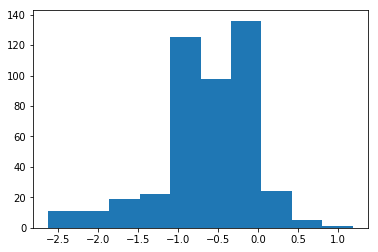

In [48]:
plt.hist(y_pred_low[:,0]-y_test)
plt.show()

In [61]:
q=0.95
model.compile(loss=lambda y,f: tilted_loss(q,y,f),  metrics=['accuracy'], optimizer='adadelta')
model.fit(X_train_fs, y_train, epochs=100, batch_size=32, verbose=1)
y_pred_high = model.predict(X_test_fs)

Epoch 1/100


  32/1805 [..............................] - ETA: 49s - loss: 0.0458 - acc: 0.6875

 160/1805 [=>............................] - ETA: 9s - loss: 0.0826 - acc: 0.5750 

 288/1805 [===>..........................] - ETA: 5s - loss: 0.0727 - acc: 0.5833

 416/1805 [=====>........................] - ETA: 3s - loss: 0.0595 - acc: 0.5913

 544/1805 [========>.....................] - ETA: 2s - loss: 0.0604 - acc: 0.5901

 640/1805 [=========>....................] - ETA: 2s - loss: 0.0582 - acc: 0.5813

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0561 - acc: 0.5815

 800/1805 [============>.................] - ETA: 1s - loss: 0.0543 - acc: 0.5813

 896/1805 [=============>................] - ETA: 1s - loss: 0.0540 - acc: 0.5815

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0544 - acc: 0.5746

1088/1805 [=================>............] - ETA: 1s - loss: 0.0539 - acc: 0.5726

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0531 - acc: 0.5760

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0523 - acc: 0.5785

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0517 - acc: 0.5774

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0514 - acc: 0.5810

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0505 - acc: 0.5824

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0510 - acc: 0.5759

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0514 - acc: 0.5756

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0520 - acc: 0.5766

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0517 - acc: 0.5725

1760/1805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.5739

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0513 - acc: 0.5756


Epoch 2/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0493 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0421 - acc: 0.6458

 160/1805 [=>............................] - ETA: 3s - loss: 0.0446 - acc: 0.6312

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0432 - acc: 0.6027

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0461 - acc: 0.5687

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0459 - acc: 0.5469

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0494 - acc: 0.5271

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0477 - acc: 0.5365

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0472 - acc: 0.5268

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0501 - acc: 0.5312

 800/1805 [============>.................] - ETA: 1s - loss: 0.0496 - acc: 0.5363

 896/1805 [=============>................] - ETA: 0s - loss: 0.0490 - acc: 0.5391

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0497 - acc: 0.5448

1024/1805 [================>.............] - ETA: 0s - loss: 0.0500 - acc: 0.5420

1120/1805 [=================>............] - ETA: 0s - loss: 0.0505 - acc: 0.5420

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0497 - acc: 0.5444

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0492 - acc: 0.5457

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0486 - acc: 0.5469

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0483 - acc: 0.5523

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0482 - acc: 0.5535

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0476 - acc: 0.5547

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0475 - acc: 0.5570

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0478 - acc: 0.5613

1805/1805 [==============================] - 2s 951us/step - loss: 0.0478 - acc: 0.5601


Epoch 3/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0443 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0463 - acc: 0.6484

 160/1805 [=>............................] - ETA: 2s - loss: 0.0511 - acc: 0.6188

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0475 - acc: 0.6161

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0475 - acc: 0.6215

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0448 - acc: 0.6016

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0428 - acc: 0.5938

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0427 - acc: 0.5918

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0426 - acc: 0.6029

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0429 - acc: 0.6069

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0421 - acc: 0.6146

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0431 - acc: 0.6151

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0449 - acc: 0.6159

 800/1805 [============>.................] - ETA: 1s - loss: 0.0451 - acc: 0.6125

 864/1805 [=============>................] - ETA: 1s - loss: 0.0459 - acc: 0.6065

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0481 - acc: 0.6056

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0465 - acc: 0.6169

1024/1805 [================>.............] - ETA: 1s - loss: 0.0463 - acc: 0.6123

1088/1805 [=================>............] - ETA: 1s - loss: 0.0455 - acc: 0.6149

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0455 - acc: 0.6094

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0468 - acc: 0.6069

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0472 - acc: 0.6062

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0471 - acc: 0.6067

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0472 - acc: 0.6083

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0473 - acc: 0.5999

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0472 - acc: 0.5971

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0467 - acc: 0.5976

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0463 - acc: 0.5962

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0472 - acc: 0.5962

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0478 - acc: 0.5938

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0481 - acc: 0.5900


Epoch 4/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0459 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0426 - acc: 0.5938

 128/1805 [=>............................] - ETA: 2s - loss: 0.0403 - acc: 0.5938

 192/1805 [==>...........................] - ETA: 2s - loss: 0.0472 - acc: 0.6042

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0493 - acc: 0.5938

 288/1805 [===>..........................] - ETA: 3s - loss: 0.0498 - acc: 0.5764

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0492 - acc: 0.5682

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0530 - acc: 0.5577

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0553 - acc: 0.5625

 544/1805 [========>.....................] - ETA: 2s - loss: 0.0526 - acc: 0.5717

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0520 - acc: 0.5740

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0519 - acc: 0.5655

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0517 - acc: 0.5639

 800/1805 [============>.................] - ETA: 1s - loss: 0.0531 - acc: 0.5600

 864/1805 [=============>................] - ETA: 1s - loss: 0.0543 - acc: 0.5637

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0549 - acc: 0.5582

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0553 - acc: 0.5575

1056/1805 [================>.............] - ETA: 0s - loss: 0.0542 - acc: 0.5568

1120/1805 [=================>............] - ETA: 0s - loss: 0.0534 - acc: 0.5616

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0526 - acc: 0.5650

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0525 - acc: 0.5641

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0520 - acc: 0.5648

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0515 - acc: 0.5690

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0517 - acc: 0.5667

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0514 - acc: 0.5645

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0521 - acc: 0.5638

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0515 - acc: 0.5637

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0517 - acc: 0.5625

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0513 - acc: 0.5637

1760/1805 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.5659

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0505 - acc: 0.5651


Epoch 5/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0403 - acc: 0.5312

  64/1805 [>.............................] - ETA: 2s - loss: 0.0456 - acc: 0.5469

 160/1805 [=>............................] - ETA: 2s - loss: 0.0421 - acc: 0.5750

 192/1805 [==>...........................] - ETA: 3s - loss: 0.0456 - acc: 0.5833

 256/1805 [===>..........................] - ETA: 3s - loss: 0.0453 - acc: 0.5938

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0447 - acc: 0.5969

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0431 - acc: 0.6068

 448/1805 [======>.......................] - ETA: 2s - loss: 0.0438 - acc: 0.6116

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0424 - acc: 0.6191

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0465 - acc: 0.6163

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0480 - acc: 0.6047

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0463 - acc: 0.6051

 800/1805 [============>.................] - ETA: 1s - loss: 0.0454 - acc: 0.5938

 864/1805 [=============>................] - ETA: 1s - loss: 0.0474 - acc: 0.5984

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0478 - acc: 0.5948

1056/1805 [================>.............] - ETA: 0s - loss: 0.0478 - acc: 0.5947

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0488 - acc: 0.5946

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0482 - acc: 0.5880

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0480 - acc: 0.5938

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0489 - acc: 0.5871

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0485 - acc: 0.5879

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0486 - acc: 0.5888

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0484 - acc: 0.5896

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0484 - acc: 0.5890

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0480 - acc: 0.5879

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0484 - acc: 0.5887

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0495 - acc: 0.5831

1760/1805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.5858

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0482 - acc: 0.5878


Epoch 6/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0568 - acc: 0.6875

  96/1805 [>.............................] - ETA: 5s - loss: 0.0455 - acc: 0.6146

 192/1805 [==>...........................] - ETA: 3s - loss: 0.0411 - acc: 0.6198

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0394 - acc: 0.6319

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0415 - acc: 0.6156

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0420 - acc: 0.5986

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0432 - acc: 0.5996

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0437 - acc: 0.5905

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0446 - acc: 0.5815

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0440 - acc: 0.5820

 864/1805 [=============>................] - ETA: 0s - loss: 0.0445 - acc: 0.5810

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0459 - acc: 0.5819

1056/1805 [================>.............] - ETA: 0s - loss: 0.0482 - acc: 0.5758

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0478 - acc: 0.5764

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0469 - acc: 0.5789

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0462 - acc: 0.5810

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0460 - acc: 0.5771

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0449 - acc: 0.5794

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0462 - acc: 0.5772

1792/1805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.5792

1805/1805 [==============================] - 1s 804us/step - loss: 0.0458 - acc: 0.5784


Epoch 7/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0519 - acc: 0.6250

  96/1805 [>.............................] - ETA: 2s - loss: 0.0432 - acc: 0.6562

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0398 - acc: 0.6406

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0434 - acc: 0.6042

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0406 - acc: 0.6042

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0392 - acc: 0.6154

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0409 - acc: 0.6104

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0424 - acc: 0.6007

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0449 - acc: 0.5833

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0459 - acc: 0.5703

 832/1805 [============>.................] - ETA: 0s - loss: 0.0460 - acc: 0.5661

 896/1805 [=============>................] - ETA: 0s - loss: 0.0468 - acc: 0.5625

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0458 - acc: 0.5667

1024/1805 [================>.............] - ETA: 0s - loss: 0.0452 - acc: 0.5752

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0437 - acc: 0.5755

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0462 - acc: 0.5707

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0470 - acc: 0.5680

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0473 - acc: 0.5668

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0485 - acc: 0.5725

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0490 - acc: 0.5772

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0487 - acc: 0.5764

1805/1805 [==============================] - 2s 846us/step - loss: 0.0491 - acc: 0.5762


Epoch 8/100
  32/1805 [..............................] - ETA: 1s - loss: 0.1367 - acc: 0.4375

 128/1805 [=>............................] - ETA: 1s - loss: 0.0663 - acc: 0.5469

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0586 - acc: 0.5536

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0568 - acc: 0.5500

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0542 - acc: 0.5759

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0529 - acc: 0.5723

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0501 - acc: 0.5888

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0499 - acc: 0.5881

 800/1805 [============>.................] - ETA: 0s - loss: 0.0483 - acc: 0.5863

 896/1805 [=============>................] - ETA: 0s - loss: 0.0479 - acc: 0.5938

1024/1805 [================>.............] - ETA: 0s - loss: 0.0472 - acc: 0.5957

1088/1805 [=================>............] - ETA: 0s - loss: 0.0472 - acc: 0.5910

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0474 - acc: 0.5997

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0475 - acc: 0.5945

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0473 - acc: 0.5896

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0489 - acc: 0.5835

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0488 - acc: 0.5861

1792/1805 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.5848

1805/1805 [==============================] - 1s 589us/step - loss: 0.0479 - acc: 0.5873


Epoch 9/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0581 - acc: 0.6562

  96/1805 [>.............................] - ETA: 1s - loss: 0.0402 - acc: 0.6042

 160/1805 [=>............................] - ETA: 1s - loss: 0.0438 - acc: 0.5625

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0484 - acc: 0.5508

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0484 - acc: 0.5483

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0482 - acc: 0.5547

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0485 - acc: 0.5580

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0486 - acc: 0.5625

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0505 - acc: 0.5773

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0505 - acc: 0.5753

 800/1805 [============>.................] - ETA: 1s - loss: 0.0494 - acc: 0.5687

 896/1805 [=============>................] - ETA: 0s - loss: 0.0490 - acc: 0.5737

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0499 - acc: 0.5792

1056/1805 [================>.............] - ETA: 0s - loss: 0.0487 - acc: 0.5843

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0480 - acc: 0.5794

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0478 - acc: 0.5854

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0493 - acc: 0.5824

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0499 - acc: 0.5778

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0492 - acc: 0.5769

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0489 - acc: 0.5761

1792/1805 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.5765

1805/1805 [==============================] - 1s 804us/step - loss: 0.0481 - acc: 0.5773


Epoch 10/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0287 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.0664 - acc: 0.6354

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0570 - acc: 0.6354

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0508 - acc: 0.6181

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0477 - acc: 0.6146

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0474 - acc: 0.5938

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0517 - acc: 0.5781

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0544 - acc: 0.5804

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0530 - acc: 0.5677

 864/1805 [=============>................] - ETA: 0s - loss: 0.0543 - acc: 0.5683

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0529 - acc: 0.5719

1056/1805 [================>.............] - ETA: 0s - loss: 0.0530 - acc: 0.5653

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0523 - acc: 0.5712

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0534 - acc: 0.5697

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0537 - acc: 0.5714

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0529 - acc: 0.5743

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0524 - acc: 0.5723

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0525 - acc: 0.5711

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0518 - acc: 0.5700

1792/1805 [============================>.] - ETA: 0s - loss: 0.0511 - acc: 0.5709

1805/1805 [==============================] - 1s 826us/step - loss: 0.0514 - acc: 0.5701


Epoch 11/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0216 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0358 - acc: 0.6146

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0395 - acc: 0.5885

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0523 - acc: 0.5521

 384/1805 [=====>........................] - ETA: 0s - loss: 0.0535 - acc: 0.5469

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0529 - acc: 0.5417

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0529 - acc: 0.5365

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0513 - acc: 0.5417

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0501 - acc: 0.5456

 864/1805 [=============>................] - ETA: 0s - loss: 0.0512 - acc: 0.5475

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0491 - acc: 0.5504

1088/1805 [=================>............] - ETA: 0s - loss: 0.0480 - acc: 0.5542

1120/1805 [=================>............] - ETA: 0s - loss: 0.0470 - acc: 0.5616

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0460 - acc: 0.5683

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0479 - acc: 0.5663

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0490 - acc: 0.5675

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0495 - acc: 0.5671

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0491 - acc: 0.5669

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0487 - acc: 0.5684

1760/1805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.5676

1805/1805 [==============================] - 1s 700us/step - loss: 0.0484 - acc: 0.5690


Epoch 12/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0447 - acc: 0.6562

  64/1805 [>.............................] - ETA: 5s - loss: 0.0418 - acc: 0.6406

 160/1805 [=>............................] - ETA: 2s - loss: 0.0501 - acc: 0.5813

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0475 - acc: 0.5586

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0477 - acc: 0.5483

 448/1805 [======>.......................] - ETA: 2s - loss: 0.0510 - acc: 0.5692

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0486 - acc: 0.5643

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0479 - acc: 0.5674

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0471 - acc: 0.5687

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0504 - acc: 0.5682

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0508 - acc: 0.5664

 832/1805 [============>.................] - ETA: 1s - loss: 0.0503 - acc: 0.5661

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0493 - acc: 0.5668

1024/1805 [================>.............] - ETA: 0s - loss: 0.0482 - acc: 0.5723

1120/1805 [=================>............] - ETA: 0s - loss: 0.0486 - acc: 0.5714

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0487 - acc: 0.5732

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0492 - acc: 0.5747

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0493 - acc: 0.5741

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0494 - acc: 0.5750

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0498 - acc: 0.5736

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0498 - acc: 0.5729

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0507 - acc: 0.5741

1805/1805 [==============================] - 2s 965us/step - loss: 0.0513 - acc: 0.5745


Epoch 13/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0905 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0566 - acc: 0.5312

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0464 - acc: 0.5536

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0469 - acc: 0.5625

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0420 - acc: 0.5710

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0433 - acc: 0.5580

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0469 - acc: 0.5515

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0437 - acc: 0.5640

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0450 - acc: 0.5638

 864/1805 [=============>................] - ETA: 0s - loss: 0.0446 - acc: 0.5694

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0446 - acc: 0.5646

1024/1805 [================>.............] - ETA: 0s - loss: 0.0438 - acc: 0.5635

1120/1805 [=================>............] - ETA: 0s - loss: 0.0440 - acc: 0.5607

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0446 - acc: 0.5600

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0450 - acc: 0.5625

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0443 - acc: 0.5678

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0448 - acc: 0.5640

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0456 - acc: 0.5605

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0452 - acc: 0.5638

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0447 - acc: 0.5685

1760/1805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.5705

1805/1805 [==============================] - 2s 850us/step - loss: 0.0444 - acc: 0.5706


Epoch 14/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0527 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0498 - acc: 0.5781

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0432 - acc: 0.5893

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0412 - acc: 0.5813

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0428 - acc: 0.5841

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0467 - acc: 0.5607

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0475 - acc: 0.5500

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0474 - acc: 0.5530

 832/1805 [============>.................] - ETA: 0s - loss: 0.0464 - acc: 0.5541

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0464 - acc: 0.5625

1088/1805 [=================>............] - ETA: 0s - loss: 0.0454 - acc: 0.5708

1120/1805 [=================>............] - ETA: 0s - loss: 0.0451 - acc: 0.5705

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0450 - acc: 0.5681

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0448 - acc: 0.5712

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0454 - acc: 0.5700

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0444 - acc: 0.5708

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0447 - acc: 0.5690

1805/1805 [==============================] - 1s 565us/step - loss: 0.0458 - acc: 0.5695


Epoch 15/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0818 - acc: 0.5625

  64/1805 [>.............................] - ETA: 2s - loss: 0.0589 - acc: 0.5781

 160/1805 [=>............................] - ETA: 1s - loss: 0.0548 - acc: 0.5500

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0548 - acc: 0.5563

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0508 - acc: 0.5755

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0502 - acc: 0.5826

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0514 - acc: 0.5772

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0511 - acc: 0.5851

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0499 - acc: 0.5952

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0489 - acc: 0.5966

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0523 - acc: 0.5977

 864/1805 [=============>................] - ETA: 0s - loss: 0.0522 - acc: 0.6053

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0527 - acc: 0.5958

1056/1805 [================>.............] - ETA: 0s - loss: 0.0507 - acc: 0.6032

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0502 - acc: 0.6076

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0506 - acc: 0.6069

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0501 - acc: 0.6086

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0493 - acc: 0.6061

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0516 - acc: 0.6026

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0510 - acc: 0.6008

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0519 - acc: 0.5943

1792/1805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.5904

1805/1805 [==============================] - 2s 838us/step - loss: 0.0526 - acc: 0.5895


Epoch 16/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0467 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0369 - acc: 0.5833

 160/1805 [=>............................] - ETA: 1s - loss: 0.0360 - acc: 0.6062

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0384 - acc: 0.5781

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0380 - acc: 0.5795

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0411 - acc: 0.5673

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0392 - acc: 0.5729

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0403 - acc: 0.5799

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0402 - acc: 0.5759

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0389 - acc: 0.5846

 864/1805 [=============>................] - ETA: 0s - loss: 0.0398 - acc: 0.5845

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0395 - acc: 0.5873

1024/1805 [================>.............] - ETA: 0s - loss: 0.0399 - acc: 0.5889

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0432 - acc: 0.5825

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0443 - acc: 0.5817

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0440 - acc: 0.5766

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0442 - acc: 0.5756

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0453 - acc: 0.5764

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0456 - acc: 0.5762

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0461 - acc: 0.5717

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0469 - acc: 0.5690

1792/1805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.5698

1805/1805 [==============================] - 2s 863us/step - loss: 0.0472 - acc: 0.5690


Epoch 17/100


  32/1805 [..............................] - ETA: 4s - loss: 0.0308 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0542 - acc: 0.5469

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0588 - acc: 0.5045

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0543 - acc: 0.5156

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0495 - acc: 0.5491

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0488 - acc: 0.5469

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0464 - acc: 0.5486

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0461 - acc: 0.5446

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0476 - acc: 0.5435

 832/1805 [============>.................] - ETA: 0s - loss: 0.0461 - acc: 0.5541

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0444 - acc: 0.5593

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0442 - acc: 0.5594

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0440 - acc: 0.5585

1024/1805 [================>.............] - ETA: 0s - loss: 0.0437 - acc: 0.5596

1088/1805 [=================>............] - ETA: 0s - loss: 0.0453 - acc: 0.5588

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0461 - acc: 0.5608

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0468 - acc: 0.5610

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0470 - acc: 0.5639

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0467 - acc: 0.5658

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0471 - acc: 0.5631

1760/1805 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.5682

1805/1805 [==============================] - 1s 795us/step - loss: 0.0468 - acc: 0.5673


Epoch 18/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0232 - acc: 0.6875

  64/1805 [>.............................] - ETA: 4s - loss: 0.0223 - acc: 0.7188

  96/1805 [>.............................] - ETA: 7s - loss: 0.0272 - acc: 0.6354

 160/1805 [=>............................] - ETA: 4s - loss: 0.0370 - acc: 0.5875

 256/1805 [===>..........................] - ETA: 3s - loss: 0.0391 - acc: 0.5938

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0538 - acc: 0.5795

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0506 - acc: 0.5889

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0536 - acc: 0.5742

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0537 - acc: 0.5822

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0535 - acc: 0.5866

 800/1805 [============>.................] - ETA: 1s - loss: 0.0523 - acc: 0.5863

 832/1805 [============>.................] - ETA: 1s - loss: 0.0518 - acc: 0.5853

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0506 - acc: 0.5873

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0502 - acc: 0.5857

1056/1805 [================>.............] - ETA: 0s - loss: 0.0492 - acc: 0.5833

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0480 - acc: 0.5851

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0476 - acc: 0.5831

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0473 - acc: 0.5859

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0484 - acc: 0.5818

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0483 - acc: 0.5819

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0491 - acc: 0.5788

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0480 - acc: 0.5827

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0483 - acc: 0.5845

1805/1805 [==============================] - 2s 952us/step - loss: 0.0492 - acc: 0.5817


Epoch 19/100


  32/1805 [..............................] - ETA: 6s - loss: 0.0590 - acc: 0.7500

 128/1805 [=>............................] - ETA: 2s - loss: 0.0468 - acc: 0.6094

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0425 - acc: 0.6071

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0434 - acc: 0.6062

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0473 - acc: 0.6094

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0462 - acc: 0.5901

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0469 - acc: 0.5906

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0479 - acc: 0.5781

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0471 - acc: 0.5768

 864/1805 [=============>................] - ETA: 0s - loss: 0.0472 - acc: 0.5718

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0470 - acc: 0.5808

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0462 - acc: 0.5817

1088/1805 [=================>............] - ETA: 0s - loss: 0.0459 - acc: 0.5744

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0458 - acc: 0.5752

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0476 - acc: 0.5711

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0479 - acc: 0.5741

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0476 - acc: 0.5798

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0485 - acc: 0.5750

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0483 - acc: 0.5778

1792/1805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.5804

1805/1805 [==============================] - 1s 822us/step - loss: 0.0475 - acc: 0.5801


Epoch 20/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0428 - acc: 0.5938

  96/1805 [>.............................] - ETA: 1s - loss: 0.0638 - acc: 0.5938

 160/1805 [=>............................] - ETA: 1s - loss: 0.0527 - acc: 0.5938

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0489 - acc: 0.5848

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0469 - acc: 0.5764

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0444 - acc: 0.5824

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0416 - acc: 0.5893

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0426 - acc: 0.5882

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0444 - acc: 0.5851

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0446 - acc: 0.5813

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0457 - acc: 0.5815

 832/1805 [============>.................] - ETA: 0s - loss: 0.0442 - acc: 0.5817

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0453 - acc: 0.5844

1056/1805 [================>.............] - ETA: 0s - loss: 0.0444 - acc: 0.5881

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0447 - acc: 0.5861

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0467 - acc: 0.5828

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0477 - acc: 0.5800

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0493 - acc: 0.5781

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0497 - acc: 0.5785

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0493 - acc: 0.5778

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0492 - acc: 0.5788

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0484 - acc: 0.5807

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0476 - acc: 0.5803

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0472 - acc: 0.5775

1760/1805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.5773

1805/1805 [==============================] - 2s 998us/step - loss: 0.0477 - acc: 0.5751


Epoch 21/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0495 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0505 - acc: 0.6016

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0508 - acc: 0.5938

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0559 - acc: 0.6031

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0524 - acc: 0.5889

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0493 - acc: 0.5859

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0498 - acc: 0.5885

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0506 - acc: 0.5789

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0527 - acc: 0.5820

 864/1805 [=============>................] - ETA: 0s - loss: 0.0551 - acc: 0.5741

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0548 - acc: 0.5667

1056/1805 [================>.............] - ETA: 0s - loss: 0.0546 - acc: 0.5653

1120/1805 [=================>............] - ETA: 0s - loss: 0.0557 - acc: 0.5625

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0553 - acc: 0.5709

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0558 - acc: 0.5734

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0551 - acc: 0.5722

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0551 - acc: 0.5743

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0549 - acc: 0.5762

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0539 - acc: 0.5705

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0544 - acc: 0.5721

1760/1805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.5739

1805/1805 [==============================] - 1s 734us/step - loss: 0.0532 - acc: 0.5706


Epoch 22/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0438 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0624 - acc: 0.5078

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0548 - acc: 0.5670

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0495 - acc: 0.5875

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0476 - acc: 0.5938

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0505 - acc: 0.5804

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0526 - acc: 0.5625

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0550 - acc: 0.5699

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0539 - acc: 0.5768

 896/1805 [=============>................] - ETA: 0s - loss: 0.0517 - acc: 0.5770

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0513 - acc: 0.5736

1056/1805 [================>.............] - ETA: 0s - loss: 0.0509 - acc: 0.5758

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0505 - acc: 0.5755

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0504 - acc: 0.5785

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0493 - acc: 0.5774

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0497 - acc: 0.5806

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0495 - acc: 0.5838

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0499 - acc: 0.5856

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0500 - acc: 0.5871

1760/1805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.5869

1805/1805 [==============================] - 1s 780us/step - loss: 0.0500 - acc: 0.5856


Epoch 23/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0625 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0535 - acc: 0.5938

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0470 - acc: 0.5885

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0430 - acc: 0.5938

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0397 - acc: 0.5990

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0413 - acc: 0.6004

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0430 - acc: 0.5938

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0445 - acc: 0.5868

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0441 - acc: 0.5797

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0442 - acc: 0.5802

 800/1805 [============>.................] - ETA: 0s - loss: 0.0445 - acc: 0.5800

 864/1805 [=============>................] - ETA: 0s - loss: 0.0452 - acc: 0.5741

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0466 - acc: 0.5708

1056/1805 [================>.............] - ETA: 0s - loss: 0.0460 - acc: 0.5767

1088/1805 [=================>............] - ETA: 0s - loss: 0.0470 - acc: 0.5754

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0470 - acc: 0.5668

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0467 - acc: 0.5667

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0465 - acc: 0.5674

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0457 - acc: 0.5687

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0450 - acc: 0.5677

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0447 - acc: 0.5722

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0449 - acc: 0.5716

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0451 - acc: 0.5729

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0450 - acc: 0.5713

1760/1805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.5727

1792/1805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.5714

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0447 - acc: 0.5712


Epoch 24/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0428 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.0398 - acc: 0.5833

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0559 - acc: 0.5938

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0531 - acc: 0.6007

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0527 - acc: 0.5755

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0522 - acc: 0.5729

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0517 - acc: 0.5723

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0494 - acc: 0.5839

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0495 - acc: 0.5838

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0498 - acc: 0.5742

 864/1805 [=============>................] - ETA: 0s - loss: 0.0486 - acc: 0.5810

 896/1805 [=============>................] - ETA: 0s - loss: 0.0479 - acc: 0.5826

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0479 - acc: 0.5771

1024/1805 [================>.............] - ETA: 0s - loss: 0.0463 - acc: 0.5840

1088/1805 [=================>............] - ETA: 0s - loss: 0.0463 - acc: 0.5836

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0448 - acc: 0.5895

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0441 - acc: 0.5938

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0449 - acc: 0.5923

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0452 - acc: 0.5881

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0454 - acc: 0.5883

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0465 - acc: 0.5912

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0465 - acc: 0.5894

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0474 - acc: 0.5882

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0472 - acc: 0.5814

1760/1805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.5847

1805/1805 [==============================] - 2s 975us/step - loss: 0.0467 - acc: 0.5823


Epoch 25/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0841 - acc: 0.5625

  64/1805 [>.............................] - ETA: 2s - loss: 0.1044 - acc: 0.6406

 160/1805 [=>............................] - ETA: 1s - loss: 0.0645 - acc: 0.6062

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0566 - acc: 0.6016

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0531 - acc: 0.6094

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0541 - acc: 0.6120

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0522 - acc: 0.6125

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0534 - acc: 0.6042

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0514 - acc: 0.6086

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0495 - acc: 0.6016

 832/1805 [============>.................] - ETA: 0s - loss: 0.0504 - acc: 0.6010

 896/1805 [=============>................] - ETA: 0s - loss: 0.0493 - acc: 0.6027

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0507 - acc: 0.5958

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0504 - acc: 0.5968

1056/1805 [================>.............] - ETA: 0s - loss: 0.0496 - acc: 0.5975

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0490 - acc: 0.5920

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0490 - acc: 0.5888

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0491 - acc: 0.5884

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0499 - acc: 0.5866

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0502 - acc: 0.5838

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0502 - acc: 0.5856

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0504 - acc: 0.5867

1760/1805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.5886

1805/1805 [==============================] - 2s 835us/step - loss: 0.0499 - acc: 0.5861


Epoch 26/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0265 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0298 - acc: 0.6016

 192/1805 [==>...........................] - ETA: 2s - loss: 0.0370 - acc: 0.6094

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0399 - acc: 0.6205

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0391 - acc: 0.6111

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0411 - acc: 0.6222

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0449 - acc: 0.6130

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0428 - acc: 0.6016

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0432 - acc: 0.5920

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0445 - acc: 0.5906

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0446 - acc: 0.5838

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0466 - acc: 0.5807

 832/1805 [============>.................] - ETA: 1s - loss: 0.0455 - acc: 0.5781

 896/1805 [=============>................] - ETA: 0s - loss: 0.0447 - acc: 0.5781

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0454 - acc: 0.5806

1088/1805 [=================>............] - ETA: 0s - loss: 0.0469 - acc: 0.5827

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0482 - acc: 0.5895

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0473 - acc: 0.5883

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0469 - acc: 0.5872

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0464 - acc: 0.5903

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0465 - acc: 0.5911

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0469 - acc: 0.5876

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0482 - acc: 0.5873

1792/1805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.5826

1805/1805 [==============================] - 2s 899us/step - loss: 0.0491 - acc: 0.5828


Epoch 27/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0440 - acc: 0.6562

  64/1805 [>.............................] - ETA: 2s - loss: 0.0436 - acc: 0.5625

 160/1805 [=>............................] - ETA: 1s - loss: 0.0688 - acc: 0.5125

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0662 - acc: 0.5391

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0631 - acc: 0.5256

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0588 - acc: 0.5357

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0597 - acc: 0.5312

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0588 - acc: 0.5219

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0542 - acc: 0.5476

 832/1805 [============>.................] - ETA: 0s - loss: 0.0526 - acc: 0.5445

 896/1805 [=============>................] - ETA: 0s - loss: 0.0526 - acc: 0.5469

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0516 - acc: 0.5490

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0517 - acc: 0.5514

1056/1805 [================>.............] - ETA: 0s - loss: 0.0520 - acc: 0.5483

1120/1805 [=================>............] - ETA: 0s - loss: 0.0519 - acc: 0.5482

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0523 - acc: 0.5532

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0518 - acc: 0.5567

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0540 - acc: 0.5545

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0522 - acc: 0.5536

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0514 - acc: 0.5535

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0506 - acc: 0.5618

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0512 - acc: 0.5573

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0507 - acc: 0.5576

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0504 - acc: 0.5579

1792/1805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.5603

1805/1805 [==============================] - 2s 960us/step - loss: 0.0500 - acc: 0.5623


Epoch 28/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0570 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0485 - acc: 0.5625

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0742 - acc: 0.5365

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0650 - acc: 0.5820

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0610 - acc: 0.5852

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0604 - acc: 0.5826

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0592 - acc: 0.5827

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0573 - acc: 0.5813

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0540 - acc: 0.5729

 896/1805 [=============>................] - ETA: 0s - loss: 0.0519 - acc: 0.5792

1056/1805 [================>.............] - ETA: 0s - loss: 0.0519 - acc: 0.5748

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0519 - acc: 0.5828

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0523 - acc: 0.5825

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0537 - acc: 0.5811

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0529 - acc: 0.5799

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0537 - acc: 0.5775

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0529 - acc: 0.5784

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0535 - acc: 0.5778

1760/1805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.5778

1792/1805 [============================>.] - ETA: 0s - loss: 0.0527 - acc: 0.5765

1805/1805 [==============================] - 1s 751us/step - loss: 0.0527 - acc: 0.5756


Epoch 29/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0437 - acc: 0.5000

  96/1805 [>.............................] - ETA: 2s - loss: 0.0449 - acc: 0.5625

 128/1805 [=>............................] - ETA: 2s - loss: 0.0462 - acc: 0.5547

 192/1805 [==>...........................] - ETA: 2s - loss: 0.0471 - acc: 0.5469

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0467 - acc: 0.5195

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0507 - acc: 0.5406

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0490 - acc: 0.5443

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0513 - acc: 0.5446

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0515 - acc: 0.5449

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0534 - acc: 0.5428

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0514 - acc: 0.5506

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0516 - acc: 0.5489

 800/1805 [============>.................] - ETA: 0s - loss: 0.0501 - acc: 0.5500

 864/1805 [=============>................] - ETA: 0s - loss: 0.0519 - acc: 0.5521

 896/1805 [=============>................] - ETA: 0s - loss: 0.0526 - acc: 0.5502

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0509 - acc: 0.5514

1088/1805 [=================>............] - ETA: 0s - loss: 0.0520 - acc: 0.5524

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0536 - acc: 0.5495

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0525 - acc: 0.5539

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0514 - acc: 0.5565

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0520 - acc: 0.5582

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0515 - acc: 0.5585

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0508 - acc: 0.5606

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0505 - acc: 0.5643

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0498 - acc: 0.5666

1792/1805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.5675

1805/1805 [==============================] - 2s 873us/step - loss: 0.0497 - acc: 0.5679


Epoch 30/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0562 - acc: 0.5625

  64/1805 [>.............................] - ETA: 2s - loss: 0.0500 - acc: 0.5469

 160/1805 [=>............................] - ETA: 1s - loss: 0.0431 - acc: 0.5312

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0398 - acc: 0.5664

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0444 - acc: 0.5483

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0435 - acc: 0.5443

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0427 - acc: 0.5603

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0449 - acc: 0.5680

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0456 - acc: 0.5687

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0453 - acc: 0.5693

 832/1805 [============>.................] - ETA: 0s - loss: 0.0456 - acc: 0.5793

 896/1805 [=============>................] - ETA: 0s - loss: 0.0462 - acc: 0.5804

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0466 - acc: 0.5813

1024/1805 [================>.............] - ETA: 0s - loss: 0.0470 - acc: 0.5752

1088/1805 [=================>............] - ETA: 0s - loss: 0.0478 - acc: 0.5726

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0484 - acc: 0.5634

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0481 - acc: 0.5625

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0488 - acc: 0.5586

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0489 - acc: 0.5625

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0497 - acc: 0.5625

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0494 - acc: 0.5585

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0504 - acc: 0.5556

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0501 - acc: 0.5531

1805/1805 [==============================] - 2s 928us/step - loss: 0.0495 - acc: 0.5612


Epoch 31/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0532 - acc: 0.5625

 128/1805 [=>............................] - ETA: 0s - loss: 0.0528 - acc: 0.5781

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0551 - acc: 0.5352

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0538 - acc: 0.5398

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0527 - acc: 0.5379

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0500 - acc: 0.5551

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0487 - acc: 0.5609

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0486 - acc: 0.5668

 800/1805 [============>.................] - ETA: 0s - loss: 0.0476 - acc: 0.5687

 896/1805 [=============>................] - ETA: 0s - loss: 0.0522 - acc: 0.5658

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0528 - acc: 0.5595

1088/1805 [=================>............] - ETA: 0s - loss: 0.0514 - acc: 0.5653

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0509 - acc: 0.5658

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0500 - acc: 0.5664

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0499 - acc: 0.5696

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0496 - acc: 0.5698

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0485 - acc: 0.5725

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0486 - acc: 0.5733

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0493 - acc: 0.5735

1760/1805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.5727

1805/1805 [==============================] - 1s 808us/step - loss: 0.0496 - acc: 0.5712


Epoch 32/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0719 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0489 - acc: 0.5547

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0555 - acc: 0.5625

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0587 - acc: 0.5469

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0555 - acc: 0.5443

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0537 - acc: 0.5500

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0523 - acc: 0.5590

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0509 - acc: 0.5609

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0559 - acc: 0.5693

 800/1805 [============>.................] - ETA: 0s - loss: 0.0553 - acc: 0.5750

 864/1805 [=============>................] - ETA: 0s - loss: 0.0539 - acc: 0.5775

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0538 - acc: 0.5792

1024/1805 [================>.............] - ETA: 0s - loss: 0.0526 - acc: 0.5791

1120/1805 [=================>............] - ETA: 0s - loss: 0.0518 - acc: 0.5830

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0510 - acc: 0.5845

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0521 - acc: 0.5817

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0509 - acc: 0.5861

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0508 - acc: 0.5838

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0511 - acc: 0.5798

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0509 - acc: 0.5825

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0516 - acc: 0.5793

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0512 - acc: 0.5781

1805/1805 [==============================] - 1s 796us/step - loss: 0.0510 - acc: 0.5784


Epoch 33/100


  32/1805 [..............................] - ETA: 13s - loss: 0.0367 - acc: 0.5000

 128/1805 [=>............................] - ETA: 3s - loss: 0.0423 - acc: 0.5703 

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0638 - acc: 0.5664

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0565 - acc: 0.5597

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0551 - acc: 0.5649

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0583 - acc: 0.5667

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0543 - acc: 0.5816

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0554 - acc: 0.5818

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0530 - acc: 0.5807

 832/1805 [============>.................] - ETA: 0s - loss: 0.0521 - acc: 0.5817

 864/1805 [=============>................] - ETA: 0s - loss: 0.0522 - acc: 0.5833

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0527 - acc: 0.5813

1056/1805 [================>.............] - ETA: 0s - loss: 0.0519 - acc: 0.5881

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0511 - acc: 0.5833

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0499 - acc: 0.5809

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0496 - acc: 0.5789

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0502 - acc: 0.5804

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0497 - acc: 0.5817

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0501 - acc: 0.5815

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0498 - acc: 0.5755

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0489 - acc: 0.5727

1792/1805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.5759

1805/1805 [==============================] - 2s 910us/step - loss: 0.0493 - acc: 0.5762


Epoch 34/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0335 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0449 - acc: 0.6354

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0399 - acc: 0.6042

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0480 - acc: 0.6031

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0489 - acc: 0.5889

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0522 - acc: 0.5854

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0528 - acc: 0.5772

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0522 - acc: 0.5719

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0514 - acc: 0.5788

 832/1805 [============>.................] - ETA: 0s - loss: 0.0502 - acc: 0.5781

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0497 - acc: 0.5808

1024/1805 [================>.............] - ETA: 0s - loss: 0.0498 - acc: 0.5820

1088/1805 [=================>............] - ETA: 0s - loss: 0.0501 - acc: 0.5846

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0492 - acc: 0.5807

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0491 - acc: 0.5789

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0487 - acc: 0.5797

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0483 - acc: 0.5858

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0471 - acc: 0.5876

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0465 - acc: 0.5886

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0471 - acc: 0.5877

1760/1805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.5864

1805/1805 [==============================] - 2s 839us/step - loss: 0.0478 - acc: 0.5873


Epoch 35/100


  32/1805 [..............................] - ETA: 4s - loss: 0.0523 - acc: 0.4688

 128/1805 [=>............................] - ETA: 2s - loss: 0.0629 - acc: 0.5547

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0614 - acc: 0.6161

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0608 - acc: 0.6281

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0572 - acc: 0.6226

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0529 - acc: 0.6055

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0534 - acc: 0.5987

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0541 - acc: 0.5966

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0532 - acc: 0.5992

 800/1805 [============>.................] - ETA: 0s - loss: 0.0549 - acc: 0.6012

 864/1805 [=============>................] - ETA: 0s - loss: 0.0550 - acc: 0.5949

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0538 - acc: 0.5927

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0519 - acc: 0.5978

1056/1805 [================>.............] - ETA: 0s - loss: 0.0510 - acc: 0.5975

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0529 - acc: 0.5929

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0523 - acc: 0.5905

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0531 - acc: 0.5898

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0537 - acc: 0.5930

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0534 - acc: 0.5916

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0551 - acc: 0.5931

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0551 - acc: 0.5898

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0545 - acc: 0.5886

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0531 - acc: 0.5913

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0524 - acc: 0.5903

1805/1805 [==============================] - 2s 978us/step - loss: 0.0539 - acc: 0.5873


Epoch 36/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0614 - acc: 0.4062

  64/1805 [>.............................] - ETA: 2s - loss: 0.0577 - acc: 0.5156

 160/1805 [=>............................] - ETA: 1s - loss: 0.0574 - acc: 0.5687

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0628 - acc: 0.5179

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0630 - acc: 0.5312

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0624 - acc: 0.5188

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0645 - acc: 0.5182

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0604 - acc: 0.5312

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0599 - acc: 0.5312

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0591 - acc: 0.5331

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0642 - acc: 0.5345

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0628 - acc: 0.5406

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0617 - acc: 0.5432

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0605 - acc: 0.5469

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0589 - acc: 0.5530

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0601 - acc: 0.5456

 800/1805 [============>.................] - ETA: 1s - loss: 0.0591 - acc: 0.5475

 864/1805 [=============>................] - ETA: 1s - loss: 0.0600 - acc: 0.5451

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0594 - acc: 0.5485

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0582 - acc: 0.5504

1088/1805 [=================>............] - ETA: 0s - loss: 0.0586 - acc: 0.5551

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0586 - acc: 0.5556

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0590 - acc: 0.5557

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0577 - acc: 0.5577

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0574 - acc: 0.5610

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0576 - acc: 0.5552

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0569 - acc: 0.5563

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0564 - acc: 0.5565

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0553 - acc: 0.5619

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0552 - acc: 0.5588

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0555 - acc: 0.5601

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0551 - acc: 0.5608

1792/1805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.5647

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0554 - acc: 0.5651


Epoch 37/100


  32/1805 [..............................] - ETA: 3s - loss: 0.1357 - acc: 0.5938

  96/1805 [>.............................] - ETA: 2s - loss: 0.0706 - acc: 0.6042

 128/1805 [=>............................] - ETA: 2s - loss: 0.0616 - acc: 0.5938

 160/1805 [=>............................] - ETA: 2s - loss: 0.0593 - acc: 0.5813

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0566 - acc: 0.5536

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0546 - acc: 0.5417

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0624 - acc: 0.5511

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0573 - acc: 0.5601

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0562 - acc: 0.5580

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0574 - acc: 0.5723

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0562 - acc: 0.5729

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0568 - acc: 0.5719

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0558 - acc: 0.5795

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0554 - acc: 0.5846

 864/1805 [=============>................] - ETA: 1s - loss: 0.0541 - acc: 0.5856

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0537 - acc: 0.5797

1024/1805 [================>.............] - ETA: 0s - loss: 0.0540 - acc: 0.5811

1088/1805 [=================>............] - ETA: 0s - loss: 0.0533 - acc: 0.5744

1120/1805 [=================>............] - ETA: 0s - loss: 0.0527 - acc: 0.5741

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0531 - acc: 0.5726

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0524 - acc: 0.5745

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0530 - acc: 0.5755

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0531 - acc: 0.5741

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0526 - acc: 0.5729

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0518 - acc: 0.5731

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0514 - acc: 0.5749

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0522 - acc: 0.5731

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0518 - acc: 0.5685

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0512 - acc: 0.5723

1792/1805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.5714

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0525 - acc: 0.5712


Epoch 38/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0710 - acc: 0.4062

  96/1805 [>.............................] - ETA: 1s - loss: 0.0828 - acc: 0.5104

 160/1805 [=>............................] - ETA: 1s - loss: 0.0616 - acc: 0.5375

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0574 - acc: 0.5312

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0576 - acc: 0.5382

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0556 - acc: 0.5625

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0609 - acc: 0.5625

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0578 - acc: 0.5604

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0621 - acc: 0.5551

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0617 - acc: 0.5516

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0639 - acc: 0.5551

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0646 - acc: 0.5554

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0638 - acc: 0.5503

 800/1805 [============>.................] - ETA: 1s - loss: 0.0622 - acc: 0.5537

 896/1805 [=============>................] - ETA: 0s - loss: 0.0601 - acc: 0.5513

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0607 - acc: 0.5500

1056/1805 [================>.............] - ETA: 0s - loss: 0.0598 - acc: 0.5455

1120/1805 [=================>............] - ETA: 0s - loss: 0.0591 - acc: 0.5482

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0583 - acc: 0.5473

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0572 - acc: 0.5531

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0568 - acc: 0.5536

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0560 - acc: 0.5604

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0553 - acc: 0.5605

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0553 - acc: 0.5594

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0555 - acc: 0.5578

1792/1805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.5592

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0552 - acc: 0.5590


Epoch 39/100


  32/1805 [..............................] - ETA: 0s - loss: 0.0459 - acc: 0.4688

 160/1805 [=>............................] - ETA: 0s - loss: 0.0607 - acc: 0.4813

 288/1805 [===>..........................] - ETA: 0s - loss: 0.0562 - acc: 0.5278

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0538 - acc: 0.5455

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0532 - acc: 0.5529

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0511 - acc: 0.5521

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0498 - acc: 0.5538

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0497 - acc: 0.5547

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0496 - acc: 0.5536

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0481 - acc: 0.5571

 832/1805 [============>.................] - ETA: 0s - loss: 0.0474 - acc: 0.5613

 896/1805 [=============>................] - ETA: 0s - loss: 0.0470 - acc: 0.5647

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0487 - acc: 0.5698

1024/1805 [================>.............] - ETA: 0s - loss: 0.0523 - acc: 0.5684

1120/1805 [=================>............] - ETA: 0s - loss: 0.0501 - acc: 0.5768

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0497 - acc: 0.5769

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0502 - acc: 0.5695

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0502 - acc: 0.5677

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0505 - acc: 0.5703

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0505 - acc: 0.5686

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0502 - acc: 0.5684

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0499 - acc: 0.5705

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0493 - acc: 0.5723

1760/1805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.5727

1792/1805 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.5703

1805/1805 [==============================] - 2s 949us/step - loss: 0.0495 - acc: 0.5729


Epoch 40/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0454 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0508 - acc: 0.5208

 160/1805 [=>............................] - ETA: 1s - loss: 0.0430 - acc: 0.5563

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0387 - acc: 0.5804

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0370 - acc: 0.5719

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0468 - acc: 0.5865

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0466 - acc: 0.5957

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0531 - acc: 0.5987

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0511 - acc: 0.5980

 800/1805 [============>.................] - ETA: 0s - loss: 0.0502 - acc: 0.6000

 864/1805 [=============>................] - ETA: 0s - loss: 0.0528 - acc: 0.5903

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0540 - acc: 0.5830

1024/1805 [================>.............] - ETA: 0s - loss: 0.0531 - acc: 0.5879

1056/1805 [================>.............] - ETA: 0s - loss: 0.0535 - acc: 0.5900

1120/1805 [=================>............] - ETA: 0s - loss: 0.0535 - acc: 0.5920

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0528 - acc: 0.5912

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0523 - acc: 0.5930

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0515 - acc: 0.5915

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0516 - acc: 0.5882

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0515 - acc: 0.5833

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0512 - acc: 0.5837

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0521 - acc: 0.5805

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0521 - acc: 0.5775

1792/1805 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.5748

1805/1805 [==============================] - 2s 835us/step - loss: 0.0522 - acc: 0.5751


Epoch 41/100


  32/1805 [..............................] - ETA: 0s - loss: 0.0446 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0415 - acc: 0.6250

 160/1805 [=>............................] - ETA: 1s - loss: 0.0374 - acc: 0.6062

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0383 - acc: 0.6071

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0402 - acc: 0.6062

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0429 - acc: 0.6120

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0443 - acc: 0.6034

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0478 - acc: 0.5917

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0479 - acc: 0.5827

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0463 - acc: 0.5855

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0479 - acc: 0.5810

 800/1805 [============>.................] - ETA: 1s - loss: 0.0484 - acc: 0.5750

 864/1805 [=============>................] - ETA: 1s - loss: 0.0504 - acc: 0.5671

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0498 - acc: 0.5625

1024/1805 [================>.............] - ETA: 0s - loss: 0.0508 - acc: 0.5654

1088/1805 [=================>............] - ETA: 0s - loss: 0.0496 - acc: 0.5653

1120/1805 [=================>............] - ETA: 0s - loss: 0.0492 - acc: 0.5661

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0496 - acc: 0.5693

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0495 - acc: 0.5729

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0491 - acc: 0.5755

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0486 - acc: 0.5799

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0486 - acc: 0.5792

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0482 - acc: 0.5824

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0480 - acc: 0.5816

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0483 - acc: 0.5794

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0477 - acc: 0.5811

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0488 - acc: 0.5752

1792/1805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.5753

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0486 - acc: 0.5762


Epoch 42/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0804 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0542 - acc: 0.6146

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0532 - acc: 0.6198

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0525 - acc: 0.6133

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0505 - acc: 0.5938

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0496 - acc: 0.5938

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0507 - acc: 0.5913

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0478 - acc: 0.5958

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0467 - acc: 0.5996

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0489 - acc: 0.5990

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0487 - acc: 0.5891

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0470 - acc: 0.5992

 800/1805 [============>.................] - ETA: 1s - loss: 0.0464 - acc: 0.6000

 896/1805 [=============>................] - ETA: 0s - loss: 0.0461 - acc: 0.6004

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0469 - acc: 0.5968

1088/1805 [=================>............] - ETA: 0s - loss: 0.0498 - acc: 0.5901

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0490 - acc: 0.5861

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0477 - acc: 0.5914

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0484 - acc: 0.5908

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0486 - acc: 0.5909

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0485 - acc: 0.5904

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0482 - acc: 0.5899

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0480 - acc: 0.5883

1760/1805 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.5892

1805/1805 [==============================] - 2s 887us/step - loss: 0.0480 - acc: 0.5906


Epoch 43/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0352 - acc: 0.7812

  64/1805 [>.............................] - ETA: 2s - loss: 0.0418 - acc: 0.6719

 128/1805 [=>............................] - ETA: 2s - loss: 0.0429 - acc: 0.6406

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0431 - acc: 0.6146

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0418 - acc: 0.6389

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0477 - acc: 0.5859

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0452 - acc: 0.5833

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0467 - acc: 0.5772

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0495 - acc: 0.5766

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0484 - acc: 0.5788

 800/1805 [============>.................] - ETA: 0s - loss: 0.0478 - acc: 0.5787

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0499 - acc: 0.5711

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0499 - acc: 0.5716

1088/1805 [=================>............] - ETA: 0s - loss: 0.0485 - acc: 0.5781

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0502 - acc: 0.5701

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0496 - acc: 0.5734

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0490 - acc: 0.5770

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0487 - acc: 0.5760

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0489 - acc: 0.5720

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0484 - acc: 0.5729

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0487 - acc: 0.5769

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0483 - acc: 0.5767

1792/1805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.5781

1805/1805 [==============================] - 2s 837us/step - loss: 0.0485 - acc: 0.5784


Epoch 44/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0378 - acc: 0.5938

 128/1805 [=>............................] - ETA: 1s - loss: 0.0342 - acc: 0.6172

 160/1805 [=>............................] - ETA: 1s - loss: 0.0415 - acc: 0.6000

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0408 - acc: 0.5938

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0411 - acc: 0.6172

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0448 - acc: 0.6138

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0436 - acc: 0.6250

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0446 - acc: 0.6076

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0435 - acc: 0.6047

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0423 - acc: 0.6065

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0421 - acc: 0.6107

 832/1805 [============>.................] - ETA: 0s - loss: 0.0415 - acc: 0.6142

 896/1805 [=============>................] - ETA: 0s - loss: 0.0401 - acc: 0.6239

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0412 - acc: 0.6229

1056/1805 [================>.............] - ETA: 0s - loss: 0.0403 - acc: 0.6203

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0420 - acc: 0.6146

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0424 - acc: 0.6106

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0422 - acc: 0.6114

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0424 - acc: 0.6027

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0428 - acc: 0.6000

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0444 - acc: 0.5970

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0442 - acc: 0.5931

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0442 - acc: 0.5908

1792/1805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.5893

1805/1805 [==============================] - 1s 805us/step - loss: 0.0437 - acc: 0.5906


Epoch 45/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0380 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0600 - acc: 0.5833

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0471 - acc: 0.5990

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0485 - acc: 0.6116

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0471 - acc: 0.5868

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0519 - acc: 0.5966

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0500 - acc: 0.5986

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0521 - acc: 0.5879

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0517 - acc: 0.5806

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0523 - acc: 0.5766

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0527 - acc: 0.5720

 832/1805 [============>.................] - ETA: 1s - loss: 0.0533 - acc: 0.5757

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0538 - acc: 0.5708

1088/1805 [=================>............] - ETA: 0s - loss: 0.0539 - acc: 0.5699

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0537 - acc: 0.5752

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0533 - acc: 0.5703

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0525 - acc: 0.5722

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0517 - acc: 0.5770

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0527 - acc: 0.5713

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0516 - acc: 0.5740

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0522 - acc: 0.5721

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0515 - acc: 0.5712

1792/1805 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.5742

1805/1805 [==============================] - 2s 871us/step - loss: 0.0512 - acc: 0.5751


Epoch 46/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0458 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0404 - acc: 0.5417

 160/1805 [=>............................] - ETA: 1s - loss: 0.0455 - acc: 0.5563

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0477 - acc: 0.5982

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0434 - acc: 0.6215

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0424 - acc: 0.6222

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0400 - acc: 0.6205

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0410 - acc: 0.6172

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0422 - acc: 0.6201

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0447 - acc: 0.6065

 800/1805 [============>.................] - ETA: 0s - loss: 0.0451 - acc: 0.6038

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0463 - acc: 0.5959

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0460 - acc: 0.5969

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0460 - acc: 0.5988

1056/1805 [================>.............] - ETA: 0s - loss: 0.0454 - acc: 0.6004

1088/1805 [=================>............] - ETA: 0s - loss: 0.0447 - acc: 0.6029

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0454 - acc: 0.6016

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0479 - acc: 0.5938

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0478 - acc: 0.5907

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0484 - acc: 0.5916

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0479 - acc: 0.5911

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0475 - acc: 0.5925

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0488 - acc: 0.5895

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0495 - acc: 0.5879

1760/1805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.5807

1805/1805 [==============================] - 2s 975us/step - loss: 0.0498 - acc: 0.5801


Epoch 47/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0322 - acc: 0.6875

  96/1805 [>.............................] - ETA: 1s - loss: 0.0489 - acc: 0.6562

 160/1805 [=>............................] - ETA: 1s - loss: 0.0471 - acc: 0.6312

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0423 - acc: 0.6205

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0483 - acc: 0.6146

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0469 - acc: 0.5881

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0461 - acc: 0.5697

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0484 - acc: 0.5813

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0468 - acc: 0.5809

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0482 - acc: 0.5757

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0471 - acc: 0.5739

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0472 - acc: 0.5666

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0469 - acc: 0.5690

 800/1805 [============>.................] - ETA: 0s - loss: 0.0460 - acc: 0.5737

 864/1805 [=============>................] - ETA: 0s - loss: 0.0455 - acc: 0.5752

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0459 - acc: 0.5744

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0471 - acc: 0.5726

1056/1805 [================>.............] - ETA: 0s - loss: 0.0475 - acc: 0.5729

1120/1805 [=================>............] - ETA: 0s - loss: 0.0480 - acc: 0.5679

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0483 - acc: 0.5765

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0489 - acc: 0.5753

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0486 - acc: 0.5694

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0491 - acc: 0.5640

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0485 - acc: 0.5625

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0483 - acc: 0.5658

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0491 - acc: 0.5644

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0487 - acc: 0.5631

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0485 - acc: 0.5625

1760/1805 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.5648

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0482 - acc: 0.5645


Epoch 48/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0601 - acc: 0.3750

 128/1805 [=>............................] - ETA: 1s - loss: 0.0713 - acc: 0.5312

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0584 - acc: 0.5357

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0504 - acc: 0.5625

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0480 - acc: 0.5697

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0475 - acc: 0.5875

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0457 - acc: 0.5864

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0451 - acc: 0.5839

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0503 - acc: 0.5710

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0491 - acc: 0.5781

 832/1805 [============>.................] - ETA: 0s - loss: 0.0480 - acc: 0.5889

 896/1805 [=============>................] - ETA: 0s - loss: 0.0492 - acc: 0.5859

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0488 - acc: 0.5851

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0506 - acc: 0.5806

1056/1805 [================>.............] - ETA: 0s - loss: 0.0510 - acc: 0.5758

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0502 - acc: 0.5807

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0496 - acc: 0.5777

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0503 - acc: 0.5732

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0494 - acc: 0.5764

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0490 - acc: 0.5762

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0489 - acc: 0.5781

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0490 - acc: 0.5816

1760/1805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.5807

1792/1805 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.5781

1805/1805 [==============================] - 2s 900us/step - loss: 0.0495 - acc: 0.5784


Epoch 49/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0762 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0707 - acc: 0.6016

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0686 - acc: 0.5714

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0663 - acc: 0.5508

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0636 - acc: 0.5437

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0638 - acc: 0.5573

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0629 - acc: 0.5491

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0647 - acc: 0.5469

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0638 - acc: 0.5573

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0622 - acc: 0.5576

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0591 - acc: 0.5625

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0629 - acc: 0.5586

 832/1805 [============>.................] - ETA: 0s - loss: 0.0616 - acc: 0.5613

 896/1805 [=============>................] - ETA: 0s - loss: 0.0608 - acc: 0.5592

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0596 - acc: 0.5542

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0600 - acc: 0.5565

1088/1805 [=================>............] - ETA: 0s - loss: 0.0584 - acc: 0.5551

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0573 - acc: 0.5625

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0572 - acc: 0.5609

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0553 - acc: 0.5595

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0547 - acc: 0.5574

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0542 - acc: 0.5530

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0543 - acc: 0.5560

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0543 - acc: 0.5570

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0538 - acc: 0.5571

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0545 - acc: 0.5572

1760/1805 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.5591

1792/1805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.5586

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0531 - acc: 0.5584


Epoch 50/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0379 - acc: 0.4375

  96/1805 [>.............................] - ETA: 1s - loss: 0.0393 - acc: 0.5208

 160/1805 [=>............................] - ETA: 1s - loss: 0.0358 - acc: 0.5938

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0456 - acc: 0.5893

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0434 - acc: 0.5875

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0455 - acc: 0.5885

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0439 - acc: 0.5896

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0451 - acc: 0.5764

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0437 - acc: 0.5813

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0428 - acc: 0.5810

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0421 - acc: 0.5807

 832/1805 [============>.................] - ETA: 0s - loss: 0.0416 - acc: 0.5781

 896/1805 [=============>................] - ETA: 0s - loss: 0.0419 - acc: 0.5770

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0465 - acc: 0.5685

1024/1805 [================>.............] - ETA: 0s - loss: 0.0466 - acc: 0.5693

1088/1805 [=================>............] - ETA: 0s - loss: 0.0470 - acc: 0.5708

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0466 - acc: 0.5738

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0471 - acc: 0.5745

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0469 - acc: 0.5751

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0466 - acc: 0.5732

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0463 - acc: 0.5758

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0475 - acc: 0.5778

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0473 - acc: 0.5772

1760/1805 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.5761

1805/1805 [==============================] - 1s 784us/step - loss: 0.0485 - acc: 0.5756


Epoch 51/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0311 - acc: 0.5938

 128/1805 [=>............................] - ETA: 0s - loss: 0.0470 - acc: 0.5469

 256/1805 [===>..........................] - ETA: 0s - loss: 0.0458 - acc: 0.6133

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0445 - acc: 0.6023

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0568 - acc: 0.5692

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0556 - acc: 0.5723

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0531 - acc: 0.5773

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0556 - acc: 0.5753

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0541 - acc: 0.5755

 832/1805 [============>.................] - ETA: 0s - loss: 0.0530 - acc: 0.5817

 896/1805 [=============>................] - ETA: 0s - loss: 0.0514 - acc: 0.5893

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0503 - acc: 0.5854

1024/1805 [================>.............] - ETA: 0s - loss: 0.0505 - acc: 0.5850

1120/1805 [=================>............] - ETA: 0s - loss: 0.0513 - acc: 0.5750

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0515 - acc: 0.5715

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0507 - acc: 0.5711

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0514 - acc: 0.5699

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0518 - acc: 0.5675

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0521 - acc: 0.5666

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0523 - acc: 0.5651

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0522 - acc: 0.5675

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0518 - acc: 0.5667

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0517 - acc: 0.5689

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0508 - acc: 0.5729


Epoch 52/100


  32/1805 [..............................] - ETA: 5s - loss: 0.0325 - acc: 0.6875

  96/1805 [>.............................] - ETA: 3s - loss: 0.0352 - acc: 0.6042

 128/1805 [=>............................] - ETA: 3s - loss: 0.0327 - acc: 0.6250

 160/1805 [=>............................] - ETA: 3s - loss: 0.0361 - acc: 0.6250

 192/1805 [==>...........................] - ETA: 3s - loss: 0.0362 - acc: 0.5990

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0346 - acc: 0.6027

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0371 - acc: 0.6076

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0406 - acc: 0.5881

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0430 - acc: 0.5938

 480/1805 [======>.......................] - ETA: 2s - loss: 0.0417 - acc: 0.6062

 512/1805 [=======>......................] - ETA: 2s - loss: 0.0416 - acc: 0.6016

 576/1805 [========>.....................] - ETA: 2s - loss: 0.0408 - acc: 0.6042

 640/1805 [=========>....................] - ETA: 2s - loss: 0.0437 - acc: 0.5953

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0439 - acc: 0.5938

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0438 - acc: 0.5951

 864/1805 [=============>................] - ETA: 1s - loss: 0.0455 - acc: 0.5880

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0446 - acc: 0.5833

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0444 - acc: 0.5817

1024/1805 [================>.............] - ETA: 1s - loss: 0.0451 - acc: 0.5850

1056/1805 [================>.............] - ETA: 1s - loss: 0.0447 - acc: 0.5881

1120/1805 [=================>............] - ETA: 1s - loss: 0.0468 - acc: 0.5813

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0480 - acc: 0.5720

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0482 - acc: 0.5693

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0474 - acc: 0.5721

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0477 - acc: 0.5732

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0472 - acc: 0.5734

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0473 - acc: 0.5750

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0468 - acc: 0.5762

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0470 - acc: 0.5750

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0469 - acc: 0.5739

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0463 - acc: 0.5729

1792/1805 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.5731

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0460 - acc: 0.5740


Epoch 53/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0633 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.0622 - acc: 0.6250

 128/1805 [=>............................] - ETA: 2s - loss: 0.0582 - acc: 0.5703

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0525 - acc: 0.5625

 256/1805 [===>..........................] - ETA: 3s - loss: 0.0484 - acc: 0.5586

 288/1805 [===>..........................] - ETA: 3s - loss: 0.0459 - acc: 0.5694

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0463 - acc: 0.5521

 448/1805 [======>.......................] - ETA: 2s - loss: 0.0449 - acc: 0.5625

 512/1805 [=======>......................] - ETA: 2s - loss: 0.0429 - acc: 0.5723

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0420 - acc: 0.5781

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0419 - acc: 0.5774

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0409 - acc: 0.5815

 832/1805 [============>.................] - ETA: 1s - loss: 0.0411 - acc: 0.5829

 896/1805 [=============>................] - ETA: 1s - loss: 0.0432 - acc: 0.5859

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0454 - acc: 0.5854

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0452 - acc: 0.5817

1088/1805 [=================>............] - ETA: 0s - loss: 0.0469 - acc: 0.5781

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0474 - acc: 0.5743

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0489 - acc: 0.5721

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0502 - acc: 0.5647

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0498 - acc: 0.5674

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0494 - acc: 0.5690

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0489 - acc: 0.5706

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0484 - acc: 0.5749

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0481 - acc: 0.5741

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0473 - acc: 0.5778


Epoch 54/100
  32/1805 [..............................] - ETA: 3s - loss: 0.0262 - acc: 0.6562

  96/1805 [>.............................] - ETA: 2s - loss: 0.0347 - acc: 0.6354

 160/1805 [=>............................] - ETA: 1s - loss: 0.0400 - acc: 0.5875

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0397 - acc: 0.6094

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0399 - acc: 0.6076

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0412 - acc: 0.5875

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0408 - acc: 0.5859

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0522 - acc: 0.5771

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0512 - acc: 0.5820

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0517 - acc: 0.5781

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0501 - acc: 0.5859

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0496 - acc: 0.5923

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0490 - acc: 0.5833

 832/1805 [============>.................] - ETA: 1s - loss: 0.0491 - acc: 0.5865

 896/1805 [=============>................] - ETA: 1s - loss: 0.0487 - acc: 0.5915

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0484 - acc: 0.5844

1024/1805 [================>.............] - ETA: 0s - loss: 0.0478 - acc: 0.5869

1088/1805 [=================>............] - ETA: 0s - loss: 0.0468 - acc: 0.5882

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0475 - acc: 0.5868

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0476 - acc: 0.5798

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0492 - acc: 0.5836

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0508 - acc: 0.5878

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0514 - acc: 0.5881

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0508 - acc: 0.5876

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0507 - acc: 0.5814

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0514 - acc: 0.5831

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0502 - acc: 0.5837

1760/1805 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.5852

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0498 - acc: 0.5828


Epoch 55/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0579 - acc: 0.5000

 128/1805 [=>............................] - ETA: 1s - loss: 0.0468 - acc: 0.6094

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0459 - acc: 0.5625

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0474 - acc: 0.5719

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0504 - acc: 0.5573

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0552 - acc: 0.5542

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0544 - acc: 0.5533

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0583 - acc: 0.5547

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0572 - acc: 0.5469

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0570 - acc: 0.5339

 832/1805 [============>.................] - ETA: 1s - loss: 0.0564 - acc: 0.5397

 864/1805 [=============>................] - ETA: 1s - loss: 0.0561 - acc: 0.5428

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0551 - acc: 0.5463

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0540 - acc: 0.5444

1056/1805 [================>.............] - ETA: 0s - loss: 0.0543 - acc: 0.5445

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0533 - acc: 0.5512

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0544 - acc: 0.5553

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0539 - acc: 0.5549

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0531 - acc: 0.5526

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0529 - acc: 0.5485

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0519 - acc: 0.5513

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0516 - acc: 0.5565

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0512 - acc: 0.5556

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0509 - acc: 0.5618


Epoch 56/100


  32/1805 [..............................] - ETA: 4s - loss: 0.0320 - acc: 0.5938

  96/1805 [>.............................] - ETA: 2s - loss: 0.0420 - acc: 0.5625

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0507 - acc: 0.5938

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0538 - acc: 0.5547

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0499 - acc: 0.5597

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0505 - acc: 0.5625

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0492 - acc: 0.5647

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0472 - acc: 0.5762

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0468 - acc: 0.5735

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0475 - acc: 0.5625

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0485 - acc: 0.5714

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0502 - acc: 0.5807

 864/1805 [=============>................] - ETA: 0s - loss: 0.0486 - acc: 0.5868

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0482 - acc: 0.5877

1056/1805 [================>.............] - ETA: 0s - loss: 0.0491 - acc: 0.5824

1120/1805 [=================>............] - ETA: 0s - loss: 0.0491 - acc: 0.5830

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0483 - acc: 0.5851

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0478 - acc: 0.5806

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0484 - acc: 0.5816

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0479 - acc: 0.5803

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0474 - acc: 0.5798

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0476 - acc: 0.5823

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0485 - acc: 0.5839

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0489 - acc: 0.5802

1760/1805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.5807

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0484 - acc: 0.5789


Epoch 57/100


  32/1805 [..............................] - ETA: 6s - loss: 0.0423 - acc: 0.5938

  96/1805 [>.............................] - ETA: 3s - loss: 0.0360 - acc: 0.5729

 160/1805 [=>............................] - ETA: 2s - loss: 0.0385 - acc: 0.5437

 224/1805 [==>...........................] - ETA: 2s - loss: 0.0429 - acc: 0.5179

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0395 - acc: 0.5469

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0421 - acc: 0.5625

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0423 - acc: 0.5625

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0430 - acc: 0.5772

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0439 - acc: 0.5707

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0457 - acc: 0.5729

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0465 - acc: 0.5682

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0463 - acc: 0.5742

 800/1805 [============>.................] - ETA: 1s - loss: 0.0460 - acc: 0.5713

 864/1805 [=============>................] - ETA: 0s - loss: 0.0460 - acc: 0.5706

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0459 - acc: 0.5636

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0450 - acc: 0.5685

1056/1805 [================>.............] - ETA: 0s - loss: 0.0444 - acc: 0.5795

1120/1805 [=================>............] - ETA: 0s - loss: 0.0458 - acc: 0.5750

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0455 - acc: 0.5785

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0461 - acc: 0.5817

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0467 - acc: 0.5793

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0461 - acc: 0.5763

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0460 - acc: 0.5806

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0458 - acc: 0.5851

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0462 - acc: 0.5835

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0462 - acc: 0.5833

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0454 - acc: 0.5839

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0470 - acc: 0.5784


Epoch 58/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0612 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0370 - acc: 0.6094

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0410 - acc: 0.6027

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0410 - acc: 0.5909

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0431 - acc: 0.5915

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0434 - acc: 0.5919

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0424 - acc: 0.5906

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0407 - acc: 0.5938

 800/1805 [============>.................] - ETA: 0s - loss: 0.0431 - acc: 0.5887

 864/1805 [=============>................] - ETA: 0s - loss: 0.0432 - acc: 0.5833

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0433 - acc: 0.5797

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0433 - acc: 0.5796

1024/1805 [================>.............] - ETA: 0s - loss: 0.0455 - acc: 0.5801

1088/1805 [=================>............] - ETA: 0s - loss: 0.0471 - acc: 0.5781

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0463 - acc: 0.5822

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0462 - acc: 0.5808

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0456 - acc: 0.5817

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0455 - acc: 0.5798

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0463 - acc: 0.5797

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0464 - acc: 0.5809

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0472 - acc: 0.5814

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0469 - acc: 0.5833

1792/1805 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.5848

1805/1805 [==============================] - 2s 895us/step - loss: 0.0477 - acc: 0.5856


Epoch 59/100
  32/1805 [..............................] - ETA: 3s - loss: 0.0539 - acc: 0.4688

  64/1805 [>.............................] - ETA: 3s - loss: 0.0565 - acc: 0.5156

 160/1805 [=>............................] - ETA: 2s - loss: 0.0626 - acc: 0.5375

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0597 - acc: 0.5357

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0630 - acc: 0.5312

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0654 - acc: 0.5426

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0600 - acc: 0.5601

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0569 - acc: 0.5729

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0535 - acc: 0.5677

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0543 - acc: 0.5759

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0544 - acc: 0.5755

 832/1805 [============>.................] - ETA: 0s - loss: 0.0519 - acc: 0.5865

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0545 - acc: 0.5862

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0537 - acc: 0.5867

1056/1805 [================>.............] - ETA: 0s - loss: 0.0525 - acc: 0.5833

1088/1805 [=================>............] - ETA: 0s - loss: 0.0519 - acc: 0.5846

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0516 - acc: 0.5790

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0515 - acc: 0.5732

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0505 - acc: 0.5797

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0506 - acc: 0.5826

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0506 - acc: 0.5788

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0507 - acc: 0.5795

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0504 - acc: 0.5794

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0501 - acc: 0.5769

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0496 - acc: 0.5761

1805/1805 [==============================] - 2s 878us/step - loss: 0.0493 - acc: 0.5756


Epoch 60/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0402 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0767 - acc: 0.6250

 160/1805 [=>............................] - ETA: 1s - loss: 0.0674 - acc: 0.5938

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0582 - acc: 0.6071

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0534 - acc: 0.6042

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0530 - acc: 0.5885

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0553 - acc: 0.5750

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0504 - acc: 0.5990

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0497 - acc: 0.5953

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0490 - acc: 0.5872

 864/1805 [=============>................] - ETA: 0s - loss: 0.0502 - acc: 0.5914

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0512 - acc: 0.5830

1024/1805 [================>.............] - ETA: 0s - loss: 0.0506 - acc: 0.5752

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0497 - acc: 0.5833

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0514 - acc: 0.5789

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0517 - acc: 0.5785

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0509 - acc: 0.5781

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0500 - acc: 0.5763

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0492 - acc: 0.5778

1792/1805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.5809

1805/1805 [==============================] - 1s 750us/step - loss: 0.0515 - acc: 0.5806


Epoch 61/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0282 - acc: 0.5312

  96/1805 [>.............................] - ETA: 2s - loss: 0.0269 - acc: 0.6146

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0416 - acc: 0.5885

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0392 - acc: 0.5972

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0391 - acc: 0.5909

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0384 - acc: 0.6027

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0418 - acc: 0.5938

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0416 - acc: 0.5954

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0420 - acc: 0.5997

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0414 - acc: 0.5978

 864/1805 [=============>................] - ETA: 0s - loss: 0.0451 - acc: 0.5972

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0450 - acc: 0.5938

1024/1805 [================>.............] - ETA: 0s - loss: 0.0443 - acc: 0.5947

1120/1805 [=================>............] - ETA: 0s - loss: 0.0477 - acc: 0.5938

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0474 - acc: 0.5896

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0474 - acc: 0.5881

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0475 - acc: 0.5877

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0474 - acc: 0.5908

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0469 - acc: 0.5910

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0485 - acc: 0.5858

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0489 - acc: 0.5846

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0484 - acc: 0.5900

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0483 - acc: 0.5877

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0479 - acc: 0.5897

1792/1805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.5865

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0487 - acc: 0.5867


Epoch 62/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0383 - acc: 0.6250

  64/1805 [>.............................] - ETA: 2s - loss: 0.0451 - acc: 0.5781

 128/1805 [=>............................] - ETA: 2s - loss: 0.0603 - acc: 0.5938

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0592 - acc: 0.5781

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0632 - acc: 0.5352

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0613 - acc: 0.5344

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0567 - acc: 0.5391

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0545 - acc: 0.5580

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0532 - acc: 0.5547

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0536 - acc: 0.5608

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0527 - acc: 0.5594

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0513 - acc: 0.5682

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0497 - acc: 0.5690

 800/1805 [============>.................] - ETA: 1s - loss: 0.0495 - acc: 0.5700

 864/1805 [=============>................] - ETA: 1s - loss: 0.0501 - acc: 0.5706

 896/1805 [=============>................] - ETA: 1s - loss: 0.0496 - acc: 0.5670

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0490 - acc: 0.5635

1024/1805 [================>.............] - ETA: 0s - loss: 0.0484 - acc: 0.5693

1088/1805 [=================>............] - ETA: 0s - loss: 0.0471 - acc: 0.5708

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0460 - acc: 0.5773

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0467 - acc: 0.5748

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0458 - acc: 0.5785

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0456 - acc: 0.5828

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0467 - acc: 0.5788

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0468 - acc: 0.5822

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0465 - acc: 0.5846

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0464 - acc: 0.5844

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0469 - acc: 0.5861

1792/1805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.5854

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0470 - acc: 0.5845


Epoch 63/100


  32/1805 [..............................] - ETA: 1s - loss: 0.1043 - acc: 0.5312

 160/1805 [=>............................] - ETA: 1s - loss: 0.0583 - acc: 0.5500

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0551 - acc: 0.5491

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0512 - acc: 0.5486

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0487 - acc: 0.5682

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0476 - acc: 0.5893

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0458 - acc: 0.5901

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0499 - acc: 0.5789

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0494 - acc: 0.5789

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0483 - acc: 0.5802

 800/1805 [============>.................] - ETA: 0s - loss: 0.0472 - acc: 0.5800

 864/1805 [=============>................] - ETA: 0s - loss: 0.0465 - acc: 0.5799

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0467 - acc: 0.5765

1024/1805 [================>.............] - ETA: 0s - loss: 0.0481 - acc: 0.5752

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0475 - acc: 0.5842

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0479 - acc: 0.5833

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0486 - acc: 0.5811

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0482 - acc: 0.5774

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0486 - acc: 0.5658

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0476 - acc: 0.5663

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0476 - acc: 0.5718

1792/1805 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.5720

1805/1805 [==============================] - 1s 745us/step - loss: 0.0476 - acc: 0.5712


Epoch 64/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0367 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0459 - acc: 0.6146

 128/1805 [=>............................] - ETA: 4s - loss: 0.0424 - acc: 0.6250

 160/1805 [=>............................] - ETA: 4s - loss: 0.0398 - acc: 0.6312

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0468 - acc: 0.6071

 288/1805 [===>..........................] - ETA: 3s - loss: 0.0651 - acc: 0.5799

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0563 - acc: 0.5833

 448/1805 [======>.......................] - ETA: 2s - loss: 0.0548 - acc: 0.5804

 512/1805 [=======>......................] - ETA: 2s - loss: 0.0532 - acc: 0.5957

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0521 - acc: 0.5789

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0539 - acc: 0.5797

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0526 - acc: 0.5810

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0516 - acc: 0.5859

 832/1805 [============>.................] - ETA: 1s - loss: 0.0526 - acc: 0.5877

 896/1805 [=============>................] - ETA: 1s - loss: 0.0515 - acc: 0.5848

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0505 - acc: 0.5827

1056/1805 [================>.............] - ETA: 0s - loss: 0.0510 - acc: 0.5786

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0503 - acc: 0.5747

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0494 - acc: 0.5839

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0508 - acc: 0.5836

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0497 - acc: 0.5828

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0492 - acc: 0.5875

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0501 - acc: 0.5846

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0498 - acc: 0.5833

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0496 - acc: 0.5814

1760/1805 [============================>.] - ETA: 0s - loss: 0.0493 - acc: 0.5818

1792/1805 [============================>.] - ETA: 0s - loss: 0.0493 - acc: 0.5809

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0492 - acc: 0.5801


Epoch 65/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0512 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0411 - acc: 0.5938

 160/1805 [=>............................] - ETA: 1s - loss: 0.0470 - acc: 0.5687

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0459 - acc: 0.5446

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0465 - acc: 0.5312

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0436 - acc: 0.5398

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0445 - acc: 0.5529

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0441 - acc: 0.5563

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0440 - acc: 0.5566

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0448 - acc: 0.5590

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0462 - acc: 0.5563

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0448 - acc: 0.5611

 800/1805 [============>.................] - ETA: 1s - loss: 0.0440 - acc: 0.5687

 864/1805 [=============>................] - ETA: 1s - loss: 0.0450 - acc: 0.5752

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0452 - acc: 0.5776

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0457 - acc: 0.5806

1056/1805 [================>.............] - ETA: 0s - loss: 0.0444 - acc: 0.5843

1120/1805 [=================>............] - ETA: 0s - loss: 0.0444 - acc: 0.5795

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0444 - acc: 0.5740

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0455 - acc: 0.5732

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0448 - acc: 0.5788

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0450 - acc: 0.5802

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0447 - acc: 0.5827

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0449 - acc: 0.5800

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0444 - acc: 0.5799

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0446 - acc: 0.5787

1792/1805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.5781

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0448 - acc: 0.5789


Epoch 66/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0462 - acc: 0.5000

  96/1805 [>.............................] - ETA: 1s - loss: 0.0515 - acc: 0.5104

 160/1805 [=>............................] - ETA: 1s - loss: 0.0431 - acc: 0.5375

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0397 - acc: 0.5625

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0442 - acc: 0.5972

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0432 - acc: 0.5938

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0421 - acc: 0.6058

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0402 - acc: 0.6183

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0419 - acc: 0.6229

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0420 - acc: 0.6230

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0425 - acc: 0.6299

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0435 - acc: 0.6131

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0438 - acc: 0.6087

 832/1805 [============>.................] - ETA: 1s - loss: 0.0455 - acc: 0.5986

 896/1805 [=============>................] - ETA: 1s - loss: 0.0477 - acc: 0.5893

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0481 - acc: 0.5884

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0487 - acc: 0.5806

1056/1805 [================>.............] - ETA: 0s - loss: 0.0478 - acc: 0.5786

1120/1805 [=================>............] - ETA: 0s - loss: 0.0487 - acc: 0.5777

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0480 - acc: 0.5811

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0475 - acc: 0.5809

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0477 - acc: 0.5816

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0474 - acc: 0.5811

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0470 - acc: 0.5819

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0465 - acc: 0.5824

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0465 - acc: 0.5866

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0460 - acc: 0.5886

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0455 - acc: 0.5907

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0458 - acc: 0.5914

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0463 - acc: 0.5917


Epoch 67/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0381 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0457 - acc: 0.6042

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0430 - acc: 0.5990

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0446 - acc: 0.5764

 384/1805 [=====>........................] - ETA: 0s - loss: 0.0472 - acc: 0.5781

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0467 - acc: 0.5737

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0452 - acc: 0.5735

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0453 - acc: 0.5766

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0450 - acc: 0.5734

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0444 - acc: 0.5768

 800/1805 [============>.................] - ETA: 0s - loss: 0.0439 - acc: 0.5875

 864/1805 [=============>................] - ETA: 0s - loss: 0.0442 - acc: 0.5891

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0444 - acc: 0.5927

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0449 - acc: 0.5927

1056/1805 [================>.............] - ETA: 0s - loss: 0.0450 - acc: 0.5919

1088/1805 [=================>............] - ETA: 0s - loss: 0.0447 - acc: 0.5919

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0450 - acc: 0.5894

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0453 - acc: 0.5878

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0466 - acc: 0.5825

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0479 - acc: 0.5808

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0477 - acc: 0.5807

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0481 - acc: 0.5736

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0489 - acc: 0.5685

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0481 - acc: 0.5681

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0476 - acc: 0.5733

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0473 - acc: 0.5718

1792/1805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.5737

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0469 - acc: 0.5729


Epoch 68/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0351 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0630 - acc: 0.5547

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0590 - acc: 0.5833

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0537 - acc: 0.5586

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0567 - acc: 0.5406

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0529 - acc: 0.5361

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0549 - acc: 0.5333

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0501 - acc: 0.5451

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0484 - acc: 0.5639

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0485 - acc: 0.5612

 832/1805 [============>.................] - ETA: 0s - loss: 0.0471 - acc: 0.5709

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0477 - acc: 0.5765

1056/1805 [================>.............] - ETA: 0s - loss: 0.0454 - acc: 0.5919

1120/1805 [=================>............] - ETA: 0s - loss: 0.0454 - acc: 0.5946

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0458 - acc: 0.5946

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0469 - acc: 0.5946

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0481 - acc: 0.5938

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0474 - acc: 0.5959

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0476 - acc: 0.5965

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0471 - acc: 0.5950

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0471 - acc: 0.5907

1760/1805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.5915

1805/1805 [==============================] - 2s 927us/step - loss: 0.0469 - acc: 0.5900


Epoch 69/100


  32/1805 [..............................] - ETA: 3s - loss: 0.0244 - acc: 0.6875

 128/1805 [=>............................] - ETA: 1s - loss: 0.0395 - acc: 0.5781

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0360 - acc: 0.6295

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0414 - acc: 0.5813

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0423 - acc: 0.5911

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0427 - acc: 0.5804

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0451 - acc: 0.5723

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0445 - acc: 0.5764

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0436 - acc: 0.5813

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0454 - acc: 0.5759

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0484 - acc: 0.5679

 800/1805 [============>.................] - ETA: 0s - loss: 0.0475 - acc: 0.5663

 864/1805 [=============>................] - ETA: 0s - loss: 0.0474 - acc: 0.5602

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0466 - acc: 0.5552

1056/1805 [================>.............] - ETA: 0s - loss: 0.0467 - acc: 0.5644

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0482 - acc: 0.5694

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0483 - acc: 0.5691

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0478 - acc: 0.5711

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0488 - acc: 0.5719

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0485 - acc: 0.5718

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0480 - acc: 0.5714

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0473 - acc: 0.5723

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0476 - acc: 0.5749

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0474 - acc: 0.5741

1792/1805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.5742

1805/1805 [==============================] - 2s 990us/step - loss: 0.0481 - acc: 0.5734


Epoch 70/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0464 - acc: 0.5312

 128/1805 [=>............................] - ETA: 1s - loss: 0.0526 - acc: 0.5156

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0594 - acc: 0.5491

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0598 - acc: 0.5590

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0576 - acc: 0.5656

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0541 - acc: 0.5729

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0498 - acc: 0.5792

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0478 - acc: 0.5757

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0475 - acc: 0.5761

 832/1805 [============>.................] - ETA: 0s - loss: 0.0464 - acc: 0.5865

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0457 - acc: 0.5841

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0458 - acc: 0.5897

1056/1805 [================>.............] - ETA: 0s - loss: 0.0460 - acc: 0.5862

1120/1805 [=================>............] - ETA: 0s - loss: 0.0457 - acc: 0.5848

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0461 - acc: 0.5773

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0455 - acc: 0.5797

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0452 - acc: 0.5826

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0448 - acc: 0.5817

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0458 - acc: 0.5802

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0460 - acc: 0.5791

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0457 - acc: 0.5821

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0465 - acc: 0.5778

1760/1805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.5801

1805/1805 [==============================] - 1s 800us/step - loss: 0.0459 - acc: 0.5784


Epoch 71/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0411 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0640 - acc: 0.5078

 160/1805 [=>............................] - ETA: 1s - loss: 0.0601 - acc: 0.4938

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0565 - acc: 0.5234

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0501 - acc: 0.5483

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0465 - acc: 0.5745

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0460 - acc: 0.5781

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0467 - acc: 0.5735

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0475 - acc: 0.5773

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0463 - acc: 0.5729

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0460 - acc: 0.5781

 864/1805 [=============>................] - ETA: 0s - loss: 0.0459 - acc: 0.5718

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0454 - acc: 0.5760

1088/1805 [=================>............] - ETA: 0s - loss: 0.0442 - acc: 0.5735

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0433 - acc: 0.5747

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0439 - acc: 0.5769

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0445 - acc: 0.5843

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0450 - acc: 0.5847

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0452 - acc: 0.5864

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0460 - acc: 0.5861

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0455 - acc: 0.5833

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0464 - acc: 0.5831

1760/1805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.5830

1805/1805 [==============================] - 2s 902us/step - loss: 0.0461 - acc: 0.5839


Epoch 72/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0466 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0511 - acc: 0.5078

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0614 - acc: 0.5179

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0582 - acc: 0.5312

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0549 - acc: 0.5426

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0588 - acc: 0.5505

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0599 - acc: 0.5479

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0620 - acc: 0.5312

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0593 - acc: 0.5406

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0579 - acc: 0.5440

 800/1805 [============>.................] - ETA: 0s - loss: 0.0559 - acc: 0.5550

 832/1805 [============>.................] - ETA: 0s - loss: 0.0555 - acc: 0.5529

 896/1805 [=============>................] - ETA: 0s - loss: 0.0557 - acc: 0.5625

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0551 - acc: 0.5679

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0561 - acc: 0.5656

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0565 - acc: 0.5645

1056/1805 [================>.............] - ETA: 0s - loss: 0.0561 - acc: 0.5597

1088/1805 [=================>............] - ETA: 0s - loss: 0.0553 - acc: 0.5588

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0550 - acc: 0.5616

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0559 - acc: 0.5559

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0549 - acc: 0.5555

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0545 - acc: 0.5543

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0543 - acc: 0.5560

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0542 - acc: 0.5598

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0536 - acc: 0.5619

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0531 - acc: 0.5594

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0536 - acc: 0.5601

1760/1805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.5563

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0538 - acc: 0.5573


Epoch 73/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0464 - acc: 0.7188

  96/1805 [>.............................] - ETA: 1s - loss: 0.0428 - acc: 0.5938

 160/1805 [=>............................] - ETA: 1s - loss: 0.0572 - acc: 0.5875

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0560 - acc: 0.6055

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0571 - acc: 0.5909

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0576 - acc: 0.5871

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0559 - acc: 0.5859

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0565 - acc: 0.5764

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0536 - acc: 0.5789

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0535 - acc: 0.5768

 832/1805 [============>.................] - ETA: 0s - loss: 0.0527 - acc: 0.5745

 896/1805 [=============>................] - ETA: 0s - loss: 0.0527 - acc: 0.5770

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0538 - acc: 0.5719

1024/1805 [================>.............] - ETA: 0s - loss: 0.0535 - acc: 0.5762

1088/1805 [=================>............] - ETA: 0s - loss: 0.0532 - acc: 0.5735

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0521 - acc: 0.5773

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0519 - acc: 0.5748

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0509 - acc: 0.5732

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0503 - acc: 0.5712

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0514 - acc: 0.5674

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0511 - acc: 0.5691

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0506 - acc: 0.5703

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0515 - acc: 0.5694

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0516 - acc: 0.5719

1760/1805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.5693

1805/1805 [==============================] - 2s 990us/step - loss: 0.0512 - acc: 0.5690


Epoch 74/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0425 - acc: 0.4062

  96/1805 [>.............................] - ETA: 1s - loss: 0.0520 - acc: 0.4896

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0439 - acc: 0.5573

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0458 - acc: 0.5556

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0477 - acc: 0.5469

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0451 - acc: 0.5625

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0452 - acc: 0.5667

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0440 - acc: 0.5717

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0465 - acc: 0.5625

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0481 - acc: 0.5625

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0508 - acc: 0.5625

 800/1805 [============>.................] - ETA: 0s - loss: 0.0499 - acc: 0.5613

 896/1805 [=============>................] - ETA: 0s - loss: 0.0513 - acc: 0.5446

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0504 - acc: 0.5417

1024/1805 [================>.............] - ETA: 0s - loss: 0.0499 - acc: 0.5459

1120/1805 [=================>............] - ETA: 0s - loss: 0.0498 - acc: 0.5509

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0518 - acc: 0.5518

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0514 - acc: 0.5561

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0519 - acc: 0.5579

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0510 - acc: 0.5660

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0502 - acc: 0.5672

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0500 - acc: 0.5681

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0500 - acc: 0.5703

1760/1805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.5699

1792/1805 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.5698

1805/1805 [==============================] - 2s 921us/step - loss: 0.0502 - acc: 0.5690


Epoch 75/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0487 - acc: 0.4688

 128/1805 [=>............................] - ETA: 1s - loss: 0.0500 - acc: 0.5625

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0549 - acc: 0.5536

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0503 - acc: 0.5625

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0524 - acc: 0.5889

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0501 - acc: 0.5833

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0479 - acc: 0.5799

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0465 - acc: 0.5906

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0475 - acc: 0.5909

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0480 - acc: 0.5883

 800/1805 [============>.................] - ETA: 0s - loss: 0.0476 - acc: 0.5925

 832/1805 [============>.................] - ETA: 0s - loss: 0.0490 - acc: 0.5853

 896/1805 [=============>................] - ETA: 0s - loss: 0.0491 - acc: 0.5737

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0488 - acc: 0.5708

1024/1805 [================>.............] - ETA: 0s - loss: 0.0486 - acc: 0.5684

1088/1805 [=================>............] - ETA: 0s - loss: 0.0475 - acc: 0.5717

1120/1805 [=================>............] - ETA: 0s - loss: 0.0473 - acc: 0.5714

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0466 - acc: 0.5765

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0482 - acc: 0.5758

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0480 - acc: 0.5766

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0479 - acc: 0.5729

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0486 - acc: 0.5738

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0479 - acc: 0.5781

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0500 - acc: 0.5784

1760/1805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.5744

1805/1805 [==============================] - 2s 883us/step - loss: 0.0515 - acc: 0.5723


Epoch 76/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0528 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0425 - acc: 0.5521

 128/1805 [=>............................] - ETA: 1s - loss: 0.0427 - acc: 0.5078

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0439 - acc: 0.5357

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0436 - acc: 0.5531

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0435 - acc: 0.5547

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0481 - acc: 0.5513

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0499 - acc: 0.5547

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0512 - acc: 0.5428

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0511 - acc: 0.5402

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0520 - acc: 0.5435

 832/1805 [============>.................] - ETA: 0s - loss: 0.0517 - acc: 0.5397

 896/1805 [=============>................] - ETA: 0s - loss: 0.0511 - acc: 0.5391

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0500 - acc: 0.5427

1024/1805 [================>.............] - ETA: 0s - loss: 0.0497 - acc: 0.5449

1088/1805 [=================>............] - ETA: 0s - loss: 0.0489 - acc: 0.5469

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0493 - acc: 0.5521

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0485 - acc: 0.5543

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0480 - acc: 0.5547

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0481 - acc: 0.5513

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0473 - acc: 0.5549

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0474 - acc: 0.5559

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0473 - acc: 0.5555

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0486 - acc: 0.5547

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0488 - acc: 0.5548

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0486 - acc: 0.5561

1792/1805 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.5569

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0482 - acc: 0.5568


Epoch 77/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0438 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0600 - acc: 0.5625

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0536 - acc: 0.5804

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0521 - acc: 0.5781

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0524 - acc: 0.5745

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0534 - acc: 0.5625

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0520 - acc: 0.5592

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0506 - acc: 0.5595

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0542 - acc: 0.5417

 832/1805 [============>.................] - ETA: 0s - loss: 0.0555 - acc: 0.5469

 896/1805 [=============>................] - ETA: 0s - loss: 0.0535 - acc: 0.5558

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0532 - acc: 0.5528

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0527 - acc: 0.5615

1024/1805 [================>.............] - ETA: 0s - loss: 0.0523 - acc: 0.5625

1088/1805 [=================>............] - ETA: 0s - loss: 0.0523 - acc: 0.5634

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0529 - acc: 0.5634

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0524 - acc: 0.5659

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0518 - acc: 0.5689

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0517 - acc: 0.5678

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0513 - acc: 0.5640

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0513 - acc: 0.5660

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0514 - acc: 0.5685

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0520 - acc: 0.5682

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0531 - acc: 0.5637

1760/1805 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.5642

1805/1805 [==============================] - 2s 960us/step - loss: 0.0522 - acc: 0.5657


Epoch 78/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0330 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0438 - acc: 0.6146

 160/1805 [=>............................] - ETA: 1s - loss: 0.0410 - acc: 0.5938

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0410 - acc: 0.5677

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0448 - acc: 0.5694

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0432 - acc: 0.5739

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0481 - acc: 0.5673

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0473 - acc: 0.5664

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0476 - acc: 0.5699

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0505 - acc: 0.5707

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0492 - acc: 0.5729

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0519 - acc: 0.5716

 800/1805 [============>.................] - ETA: 1s - loss: 0.0536 - acc: 0.5663

 864/1805 [=============>................] - ETA: 0s - loss: 0.0524 - acc: 0.5671

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0513 - acc: 0.5656

1056/1805 [================>.............] - ETA: 0s - loss: 0.0502 - acc: 0.5701

1088/1805 [=================>............] - ETA: 0s - loss: 0.0498 - acc: 0.5699

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0502 - acc: 0.5677

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0500 - acc: 0.5650

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0497 - acc: 0.5648

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0496 - acc: 0.5662

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0493 - acc: 0.5675

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0488 - acc: 0.5720

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0488 - acc: 0.5771

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0501 - acc: 0.5741

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0499 - acc: 0.5708

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0501 - acc: 0.5694

1760/1805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.5693

1792/1805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.5698

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0498 - acc: 0.5695


Epoch 79/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0407 - acc: 0.7500

  96/1805 [>.............................] - ETA: 1s - loss: 0.0372 - acc: 0.6042

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0465 - acc: 0.5521

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0446 - acc: 0.5764

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0441 - acc: 0.5852

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0424 - acc: 0.5964

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0424 - acc: 0.5915

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0439 - acc: 0.5820

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0439 - acc: 0.5903

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0448 - acc: 0.5781

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0456 - acc: 0.5734

 800/1805 [============>.................] - ETA: 0s - loss: 0.0446 - acc: 0.5737

 864/1805 [=============>................] - ETA: 0s - loss: 0.0439 - acc: 0.5764

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0445 - acc: 0.5667

1024/1805 [================>.............] - ETA: 0s - loss: 0.0450 - acc: 0.5674

1056/1805 [================>.............] - ETA: 0s - loss: 0.0454 - acc: 0.5672

1120/1805 [=================>............] - ETA: 0s - loss: 0.0461 - acc: 0.5714

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0470 - acc: 0.5703

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0470 - acc: 0.5701

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0467 - acc: 0.5641

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0467 - acc: 0.5648

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0462 - acc: 0.5705

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0459 - acc: 0.5703

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0458 - acc: 0.5708

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0465 - acc: 0.5729

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0468 - acc: 0.5700

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0462 - acc: 0.5715

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0458 - acc: 0.5729

1792/1805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.5714

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0469 - acc: 0.5712


Epoch 80/100


  32/1805 [..............................] - ETA: 0s - loss: 0.0470 - acc: 0.5938

 128/1805 [=>............................] - ETA: 0s - loss: 0.0351 - acc: 0.6719

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0374 - acc: 0.6042

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0449 - acc: 0.5833

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0520 - acc: 0.5795

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0523 - acc: 0.5649

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0517 - acc: 0.5437

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0513 - acc: 0.5527

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0507 - acc: 0.5538

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0519 - acc: 0.5491

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0502 - acc: 0.5599

 864/1805 [=============>................] - ETA: 0s - loss: 0.0503 - acc: 0.5579

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0491 - acc: 0.5582

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0491 - acc: 0.5575

1088/1805 [=================>............] - ETA: 0s - loss: 0.0489 - acc: 0.5570

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0484 - acc: 0.5599

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0477 - acc: 0.5592

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0468 - acc: 0.5617

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0478 - acc: 0.5654

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0494 - acc: 0.5660

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0489 - acc: 0.5678

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0489 - acc: 0.5638

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0486 - acc: 0.5649

1792/1805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.5658

1805/1805 [==============================] - 2s 897us/step - loss: 0.0477 - acc: 0.5679


Epoch 81/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0751 - acc: 0.4688

 128/1805 [=>............................] - ETA: 1s - loss: 0.0541 - acc: 0.5859

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0578 - acc: 0.5417

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0568 - acc: 0.6000

 416/1805 [=====>........................] - ETA: 0s - loss: 0.0590 - acc: 0.5841

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0581 - acc: 0.5684

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0563 - acc: 0.5576

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0556 - acc: 0.5540

 736/1805 [===========>..................] - ETA: 0s - loss: 0.0547 - acc: 0.5584

 832/1805 [============>.................] - ETA: 0s - loss: 0.0542 - acc: 0.5625

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0535 - acc: 0.5625

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0531 - acc: 0.5645

1088/1805 [=================>............] - ETA: 0s - loss: 0.0509 - acc: 0.5754

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0529 - acc: 0.5729

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0526 - acc: 0.5715

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0525 - acc: 0.5640

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0517 - acc: 0.5591

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0503 - acc: 0.5650

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0506 - acc: 0.5660

1805/1805 [==============================] - 1s 638us/step - loss: 0.0500 - acc: 0.5668


Epoch 82/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0805 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0494 - acc: 0.5729

 160/1805 [=>............................] - ETA: 1s - loss: 0.0528 - acc: 0.5813

 288/1805 [===>..........................] - ETA: 0s - loss: 0.0481 - acc: 0.5625

 384/1805 [=====>........................] - ETA: 0s - loss: 0.0456 - acc: 0.5859

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0431 - acc: 0.5871

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0432 - acc: 0.5918

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0428 - acc: 0.6007

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0432 - acc: 0.5969

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0470 - acc: 0.5852

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0493 - acc: 0.5742

 832/1805 [============>.................] - ETA: 1s - loss: 0.0495 - acc: 0.5697

 864/1805 [=============>................] - ETA: 1s - loss: 0.0509 - acc: 0.5694

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0495 - acc: 0.5722

1024/1805 [================>.............] - ETA: 0s - loss: 0.0489 - acc: 0.5674

1120/1805 [=================>............] - ETA: 0s - loss: 0.0479 - acc: 0.5670

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0474 - acc: 0.5724

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0473 - acc: 0.5719

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0473 - acc: 0.5727

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0506 - acc: 0.5708

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0509 - acc: 0.5685

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0522 - acc: 0.5668

1760/1805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.5716

1805/1805 [==============================] - 2s 868us/step - loss: 0.0511 - acc: 0.5717


Epoch 83/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0253 - acc: 0.5938

  64/1805 [>.............................] - ETA: 1s - loss: 0.0268 - acc: 0.5938

 160/1805 [=>............................] - ETA: 1s - loss: 0.0377 - acc: 0.5938

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0411 - acc: 0.5742

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0382 - acc: 0.5966

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0379 - acc: 0.6178

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0392 - acc: 0.6104

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0461 - acc: 0.5920

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0479 - acc: 0.5781

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0491 - acc: 0.5651

 832/1805 [============>.................] - ETA: 0s - loss: 0.0471 - acc: 0.5805

 896/1805 [=============>................] - ETA: 0s - loss: 0.0480 - acc: 0.5804

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0480 - acc: 0.5813

1024/1805 [================>.............] - ETA: 0s - loss: 0.0486 - acc: 0.5781

1120/1805 [=================>............] - ETA: 0s - loss: 0.0474 - acc: 0.5804

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0470 - acc: 0.5833

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0478 - acc: 0.5825

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0472 - acc: 0.5854

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0473 - acc: 0.5817

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0470 - acc: 0.5806

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0474 - acc: 0.5822

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0471 - acc: 0.5833

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0477 - acc: 0.5837

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0478 - acc: 0.5823

1760/1805 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.5795

1805/1805 [==============================] - 2s 934us/step - loss: 0.0485 - acc: 0.5806


Epoch 84/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0234 - acc: 0.6250

 128/1805 [=>............................] - ETA: 1s - loss: 0.0384 - acc: 0.6328

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0380 - acc: 0.6027

 320/1805 [====>.........................] - ETA: 0s - loss: 0.0420 - acc: 0.6062

 384/1805 [=====>........................] - ETA: 0s - loss: 0.0401 - acc: 0.6146

 480/1805 [======>.......................] - ETA: 0s - loss: 0.0400 - acc: 0.6062

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0407 - acc: 0.6011

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0412 - acc: 0.6003

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0434 - acc: 0.5980

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0433 - acc: 0.5951

 832/1805 [============>.................] - ETA: 0s - loss: 0.0440 - acc: 0.5950

 896/1805 [=============>................] - ETA: 0s - loss: 0.0440 - acc: 0.5960

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0443 - acc: 0.5854

1056/1805 [================>.............] - ETA: 0s - loss: 0.0452 - acc: 0.5900

1120/1805 [=================>............] - ETA: 0s - loss: 0.0466 - acc: 0.5875

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0461 - acc: 0.5839

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0463 - acc: 0.5891

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0462 - acc: 0.5856

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0460 - acc: 0.5817

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0461 - acc: 0.5822

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0458 - acc: 0.5820

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0460 - acc: 0.5819

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0461 - acc: 0.5784

1760/1805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.5813

1792/1805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.5815

1805/1805 [==============================] - 1s 805us/step - loss: 0.0456 - acc: 0.5817


Epoch 85/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0497 - acc: 0.4688

  96/1805 [>.............................] - ETA: 1s - loss: 0.0332 - acc: 0.6250

 128/1805 [=>............................] - ETA: 4s - loss: 0.0480 - acc: 0.6172

 160/1805 [=>............................] - ETA: 4s - loss: 0.0488 - acc: 0.6312

 224/1805 [==>...........................] - ETA: 3s - loss: 0.0536 - acc: 0.5759

 288/1805 [===>..........................] - ETA: 2s - loss: 0.0507 - acc: 0.5729

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0474 - acc: 0.5739

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0458 - acc: 0.5841

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0467 - acc: 0.5896

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0463 - acc: 0.5918

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0455 - acc: 0.5868

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0471 - acc: 0.5855

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0506 - acc: 0.5759

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0506 - acc: 0.5829

 800/1805 [============>.................] - ETA: 1s - loss: 0.0493 - acc: 0.5875

 864/1805 [=============>................] - ETA: 1s - loss: 0.0488 - acc: 0.5926

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0512 - acc: 0.5991

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0511 - acc: 0.5907

1056/1805 [================>.............] - ETA: 0s - loss: 0.0521 - acc: 0.5919

1120/1805 [=================>............] - ETA: 0s - loss: 0.0513 - acc: 0.5902

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0498 - acc: 0.5921

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0496 - acc: 0.5914

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0493 - acc: 0.5923

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0484 - acc: 0.5938

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0482 - acc: 0.5931

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0485 - acc: 0.5967

1792/1805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.5926

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0482 - acc: 0.5922


Epoch 86/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0356 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0343 - acc: 0.5521

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0453 - acc: 0.5312

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0462 - acc: 0.5402

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0436 - acc: 0.5556

 352/1805 [====>.........................] - ETA: 2s - loss: 0.0454 - acc: 0.5653

 416/1805 [=====>........................] - ETA: 2s - loss: 0.0491 - acc: 0.5673

 448/1805 [======>.......................] - ETA: 2s - loss: 0.0479 - acc: 0.5647

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0473 - acc: 0.5801

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0468 - acc: 0.5872

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0457 - acc: 0.5891

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0485 - acc: 0.5881

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0484 - acc: 0.5820

 832/1805 [============>.................] - ETA: 1s - loss: 0.0480 - acc: 0.5841

 896/1805 [=============>................] - ETA: 1s - loss: 0.0493 - acc: 0.5871

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0478 - acc: 0.5827

1088/1805 [=================>............] - ETA: 0s - loss: 0.0465 - acc: 0.5827

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0463 - acc: 0.5833

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0470 - acc: 0.5833

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0480 - acc: 0.5766

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0489 - acc: 0.5751

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0478 - acc: 0.5778

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0477 - acc: 0.5807

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0472 - acc: 0.5784

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0480 - acc: 0.5787

1792/1805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.5770

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0476 - acc: 0.5773


Epoch 87/100


  32/1805 [..............................] - ETA: 5s - loss: 0.0484 - acc: 0.5312

  96/1805 [>.............................] - ETA: 3s - loss: 0.0483 - acc: 0.5729

 160/1805 [=>............................] - ETA: 2s - loss: 0.0469 - acc: 0.5813

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0448 - acc: 0.5586

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0505 - acc: 0.5625

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0537 - acc: 0.5601

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0531 - acc: 0.5586

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0511 - acc: 0.5594

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0517 - acc: 0.5595

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0506 - acc: 0.5653

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0492 - acc: 0.5690

 864/1805 [=============>................] - ETA: 1s - loss: 0.0477 - acc: 0.5787

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0471 - acc: 0.5813

1088/1805 [=================>............] - ETA: 0s - loss: 0.0482 - acc: 0.5836

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0479 - acc: 0.5748

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0497 - acc: 0.5671

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0497 - acc: 0.5710

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0508 - acc: 0.5678

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0502 - acc: 0.5676

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0495 - acc: 0.5709

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0500 - acc: 0.5712

1792/1805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.5698

1805/1805 [==============================] - 2s 940us/step - loss: 0.0501 - acc: 0.5695


Epoch 88/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0309 - acc: 0.5938

 128/1805 [=>............................] - ETA: 1s - loss: 0.0447 - acc: 0.5391

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0460 - acc: 0.5402

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0471 - acc: 0.5594

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0471 - acc: 0.5568

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0473 - acc: 0.5673

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0480 - acc: 0.5566

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0491 - acc: 0.5451

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0493 - acc: 0.5422

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0476 - acc: 0.5511

 832/1805 [============>.................] - ETA: 0s - loss: 0.0464 - acc: 0.5625

 896/1805 [=============>................] - ETA: 0s - loss: 0.0464 - acc: 0.5625

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0460 - acc: 0.5615

1056/1805 [================>.............] - ETA: 0s - loss: 0.0466 - acc: 0.5587

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0480 - acc: 0.5616

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0474 - acc: 0.5625

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0470 - acc: 0.5640

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0470 - acc: 0.5618

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0473 - acc: 0.5597

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0474 - acc: 0.5591

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0469 - acc: 0.5605

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0469 - acc: 0.5594

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0466 - acc: 0.5619

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0461 - acc: 0.5631

1805/1805 [==============================] - 2s 949us/step - loss: 0.0454 - acc: 0.5662


Epoch 89/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0180 - acc: 0.8125

  96/1805 [>.............................] - ETA: 1s - loss: 0.0303 - acc: 0.5521

 160/1805 [=>............................] - ETA: 1s - loss: 0.0409 - acc: 0.5687

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0401 - acc: 0.5938

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0384 - acc: 0.5938

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0403 - acc: 0.6051

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0403 - acc: 0.5962

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0425 - acc: 0.5854

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0424 - acc: 0.5846

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0422 - acc: 0.5833

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0429 - acc: 0.5691

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0429 - acc: 0.5625

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0428 - acc: 0.5696

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0412 - acc: 0.5755

 832/1805 [============>.................] - ETA: 1s - loss: 0.0414 - acc: 0.5793

 896/1805 [=============>................] - ETA: 1s - loss: 0.0413 - acc: 0.5804

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0412 - acc: 0.5792

1024/1805 [================>.............] - ETA: 0s - loss: 0.0408 - acc: 0.5752

1088/1805 [=================>............] - ETA: 0s - loss: 0.0412 - acc: 0.5781

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0411 - acc: 0.5781

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0416 - acc: 0.5806

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0425 - acc: 0.5805

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0422 - acc: 0.5831

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0418 - acc: 0.5856

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0424 - acc: 0.5817

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0426 - acc: 0.5799

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0425 - acc: 0.5811

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0438 - acc: 0.5765

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0446 - acc: 0.5709

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0445 - acc: 0.5712

1792/1805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.5742

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0453 - acc: 0.5767


Epoch 90/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0443 - acc: 0.5938

  96/1805 [>.............................] - ETA: 1s - loss: 0.0441 - acc: 0.6042

 160/1805 [=>............................] - ETA: 2s - loss: 0.0497 - acc: 0.5687

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0496 - acc: 0.5742

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0521 - acc: 0.5881

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0493 - acc: 0.5865

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0521 - acc: 0.5875

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0534 - acc: 0.5809

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0516 - acc: 0.5855

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0501 - acc: 0.5863

 800/1805 [============>.................] - ETA: 0s - loss: 0.0481 - acc: 0.5887

 896/1805 [=============>................] - ETA: 0s - loss: 0.0480 - acc: 0.5871

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0468 - acc: 0.5906

1024/1805 [================>.............] - ETA: 0s - loss: 0.0474 - acc: 0.5830

1088/1805 [=================>............] - ETA: 0s - loss: 0.0473 - acc: 0.5846

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0469 - acc: 0.5868

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0468 - acc: 0.5905

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0471 - acc: 0.5878

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0482 - acc: 0.5859

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0481 - acc: 0.5876

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0474 - acc: 0.5859

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0469 - acc: 0.5880

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0469 - acc: 0.5875

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0468 - acc: 0.5859

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0476 - acc: 0.5831

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0477 - acc: 0.5833

1792/1805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.5815

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0472 - acc: 0.5801


Epoch 91/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0733 - acc: 0.5938

  96/1805 [>.............................] - ETA: 1s - loss: 0.0433 - acc: 0.6146

 160/1805 [=>............................] - ETA: 1s - loss: 0.0462 - acc: 0.6125

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0466 - acc: 0.6071

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0430 - acc: 0.6215

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0404 - acc: 0.6172

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0392 - acc: 0.6250

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0432 - acc: 0.6208

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0455 - acc: 0.6085

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0446 - acc: 0.6053

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0435 - acc: 0.6027

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0434 - acc: 0.6033

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0433 - acc: 0.6029

 864/1805 [=============>................] - ETA: 0s - loss: 0.0432 - acc: 0.5984

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0440 - acc: 0.5981

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0437 - acc: 0.6008

1056/1805 [================>.............] - ETA: 0s - loss: 0.0451 - acc: 0.5985

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0459 - acc: 0.5911

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0463 - acc: 0.5817

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0461 - acc: 0.5816

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0462 - acc: 0.5811

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0459 - acc: 0.5850

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0478 - acc: 0.5802

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0469 - acc: 0.5835

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0469 - acc: 0.5844

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0469 - acc: 0.5805

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0478 - acc: 0.5804

1792/1805 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.5787

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0475 - acc: 0.5784


Epoch 92/100
  32/1805 [..............................] - ETA: 2s - loss: 0.0468 - acc: 0.4375

  96/1805 [>.............................] - ETA: 2s - loss: 0.0495 - acc: 0.4688

 160/1805 [=>............................] - ETA: 1s - loss: 0.0456 - acc: 0.5062

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0443 - acc: 0.5402

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0498 - acc: 0.5208

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0482 - acc: 0.5341

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0473 - acc: 0.5335

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0467 - acc: 0.5312

 544/1805 [========>.....................] - ETA: 1s - loss: 0.0457 - acc: 0.5368

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0438 - acc: 0.5477

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0436 - acc: 0.5491

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0428 - acc: 0.5664

 896/1805 [=============>................] - ETA: 0s - loss: 0.0420 - acc: 0.5725

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0418 - acc: 0.5740

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0425 - acc: 0.5786

1056/1805 [================>.............] - ETA: 0s - loss: 0.0469 - acc: 0.5795

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0466 - acc: 0.5816

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0459 - acc: 0.5809

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0458 - acc: 0.5777

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0477 - acc: 0.5719

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0479 - acc: 0.5667

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0479 - acc: 0.5664

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0475 - acc: 0.5717

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0472 - acc: 0.5735

1805/1805 [==============================] - 2s 847us/step - loss: 0.0468 - acc: 0.5756


Epoch 93/100


  32/1805 [..............................] - ETA: 1s - loss: 0.0287 - acc: 0.5312

  96/1805 [>.............................] - ETA: 1s - loss: 0.0322 - acc: 0.6667

 160/1805 [=>............................] - ETA: 1s - loss: 0.0313 - acc: 0.6562

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0374 - acc: 0.6071

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0458 - acc: 0.5938

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0464 - acc: 0.5750

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0457 - acc: 0.5859

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0455 - acc: 0.5826

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0450 - acc: 0.5801

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0427 - acc: 0.5903

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0448 - acc: 0.5750

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0455 - acc: 0.5710

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0454 - acc: 0.5690

 800/1805 [============>.................] - ETA: 1s - loss: 0.0462 - acc: 0.5713

 864/1805 [=============>................] - ETA: 1s - loss: 0.0453 - acc: 0.5706

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0493 - acc: 0.5636

 960/1805 [==============>...............] - ETA: 1s - loss: 0.0485 - acc: 0.5708

 992/1805 [===============>..............] - ETA: 1s - loss: 0.0479 - acc: 0.5736

1024/1805 [================>.............] - ETA: 1s - loss: 0.0484 - acc: 0.5713

1056/1805 [================>.............] - ETA: 0s - loss: 0.0480 - acc: 0.5720

1088/1805 [=================>............] - ETA: 0s - loss: 0.0478 - acc: 0.5726

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0480 - acc: 0.5729

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0491 - acc: 0.5740

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0495 - acc: 0.5747

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0492 - acc: 0.5734

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0498 - acc: 0.5736

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0497 - acc: 0.5738

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0489 - acc: 0.5740

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0486 - acc: 0.5763

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0480 - acc: 0.5757

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0477 - acc: 0.5743

1792/1805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.5753

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0471 - acc: 0.5767


Epoch 94/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0588 - acc: 0.6250

  96/1805 [>.............................] - ETA: 1s - loss: 0.0491 - acc: 0.6042

 192/1805 [==>...........................] - ETA: 1s - loss: 0.0437 - acc: 0.5990

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0470 - acc: 0.6111

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0493 - acc: 0.5966

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0490 - acc: 0.5833

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0515 - acc: 0.5603

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0518 - acc: 0.5488

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0515 - acc: 0.5469

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0545 - acc: 0.5531

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0541 - acc: 0.5440

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0544 - acc: 0.5462

 800/1805 [============>.................] - ETA: 1s - loss: 0.0535 - acc: 0.5513

 896/1805 [=============>................] - ETA: 0s - loss: 0.0536 - acc: 0.5513

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0529 - acc: 0.5504

1056/1805 [================>.............] - ETA: 0s - loss: 0.0516 - acc: 0.5559

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0506 - acc: 0.5608

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0495 - acc: 0.5649

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0491 - acc: 0.5656

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0488 - acc: 0.5677

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0485 - acc: 0.5703

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0485 - acc: 0.5686

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0484 - acc: 0.5691

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0480 - acc: 0.5708

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0485 - acc: 0.5725

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0486 - acc: 0.5760

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0490 - acc: 0.5772

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0491 - acc: 0.5741

1805/1805 [==============================] - 2s 1ms/step - loss: 0.0493 - acc: 0.5729


Epoch 95/100


  32/1805 [..............................] - ETA: 2s - loss: 0.0372 - acc: 0.5625

 128/1805 [=>............................] - ETA: 1s - loss: 0.0406 - acc: 0.5703

 256/1805 [===>..........................] - ETA: 1s - loss: 0.0420 - acc: 0.5195

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0451 - acc: 0.5455

 448/1805 [======>.......................] - ETA: 0s - loss: 0.0440 - acc: 0.5558

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0439 - acc: 0.5607

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0441 - acc: 0.5625

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0435 - acc: 0.5641

 672/1805 [==========>...................] - ETA: 1s - loss: 0.0438 - acc: 0.5714

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0428 - acc: 0.5781

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0426 - acc: 0.5761

 800/1805 [============>.................] - ETA: 1s - loss: 0.0433 - acc: 0.5637

 896/1805 [=============>................] - ETA: 0s - loss: 0.0446 - acc: 0.5603

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0444 - acc: 0.5573

1056/1805 [================>.............] - ETA: 0s - loss: 0.0440 - acc: 0.5549

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0428 - acc: 0.5600

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0416 - acc: 0.5705

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0416 - acc: 0.5729

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0416 - acc: 0.5696

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0417 - acc: 0.5700

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0417 - acc: 0.5685

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0423 - acc: 0.5714

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0426 - acc: 0.5705

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0426 - acc: 0.5706

1805/1805 [==============================] - 2s 909us/step - loss: 0.0426 - acc: 0.5712


Epoch 96/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0466 - acc: 0.5000

 128/1805 [=>............................] - ETA: 0s - loss: 0.0375 - acc: 0.5938

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0442 - acc: 0.6295

 288/1805 [===>..........................] - ETA: 0s - loss: 0.0429 - acc: 0.6007

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0410 - acc: 0.6080

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0418 - acc: 0.6082

 512/1805 [=======>......................] - ETA: 0s - loss: 0.0423 - acc: 0.5957

 576/1805 [========>.....................] - ETA: 0s - loss: 0.0440 - acc: 0.5868

 608/1805 [=========>....................] - ETA: 0s - loss: 0.0441 - acc: 0.5806

 672/1805 [==========>...................] - ETA: 0s - loss: 0.0443 - acc: 0.5699

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0436 - acc: 0.5677

 832/1805 [============>.................] - ETA: 0s - loss: 0.0434 - acc: 0.5685

 896/1805 [=============>................] - ETA: 0s - loss: 0.0453 - acc: 0.5748

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0445 - acc: 0.5833

1024/1805 [================>.............] - ETA: 0s - loss: 0.0440 - acc: 0.5811

1088/1805 [=================>............] - ETA: 0s - loss: 0.0440 - acc: 0.5809

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0459 - acc: 0.5833

1184/1805 [==================>...........] - ETA: 0s - loss: 0.0457 - acc: 0.5811

1248/1805 [===================>..........] - ETA: 0s - loss: 0.0461 - acc: 0.5793

1312/1805 [====================>.........] - ETA: 0s - loss: 0.0475 - acc: 0.5755

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0472 - acc: 0.5689

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0492 - acc: 0.5725

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0488 - acc: 0.5695

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0483 - acc: 0.5717

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0480 - acc: 0.5718

1805/1805 [==============================] - 2s 950us/step - loss: 0.0481 - acc: 0.5712


Epoch 97/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0383 - acc: 0.7188

 128/1805 [=>............................] - ETA: 1s - loss: 0.0377 - acc: 0.5703

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0385 - acc: 0.5893

 320/1805 [====>.........................] - ETA: 1s - loss: 0.0525 - acc: 0.5625

 384/1805 [=====>........................] - ETA: 1s - loss: 0.0493 - acc: 0.5703

 448/1805 [======>.......................] - ETA: 1s - loss: 0.0526 - acc: 0.5647

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0495 - acc: 0.5840

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0474 - acc: 0.5833

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0462 - acc: 0.5922

 704/1805 [==========>...................] - ETA: 0s - loss: 0.0457 - acc: 0.6009

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0452 - acc: 0.6003

 896/1805 [=============>................] - ETA: 0s - loss: 0.0461 - acc: 0.5982

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0446 - acc: 0.6028

1120/1805 [=================>............] - ETA: 0s - loss: 0.0458 - acc: 0.5973

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0462 - acc: 0.5981

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0459 - acc: 0.5938

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0456 - acc: 0.5938

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0460 - acc: 0.5945

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0461 - acc: 0.5923

1504/1805 [=======================>......] - ETA: 0s - loss: 0.0460 - acc: 0.5918

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0458 - acc: 0.5906

1664/1805 [==========================>...] - ETA: 0s - loss: 0.0453 - acc: 0.5865

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0450 - acc: 0.5845

1792/1805 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.5848

1805/1805 [==============================] - 2s 989us/step - loss: 0.0451 - acc: 0.5856


Epoch 98/100
  32/1805 [..............................] - ETA: 1s - loss: 0.0274 - acc: 0.5625

  96/1805 [>.............................] - ETA: 1s - loss: 0.0320 - acc: 0.6042

 160/1805 [=>............................] - ETA: 1s - loss: 0.0399 - acc: 0.6000

 224/1805 [==>...........................] - ETA: 1s - loss: 0.0503 - acc: 0.5893

 288/1805 [===>..........................] - ETA: 1s - loss: 0.0497 - acc: 0.5660

 352/1805 [====>.........................] - ETA: 1s - loss: 0.0484 - acc: 0.5625

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0484 - acc: 0.5649

 480/1805 [======>.......................] - ETA: 1s - loss: 0.0479 - acc: 0.5729

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0483 - acc: 0.5723

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0473 - acc: 0.5781

 608/1805 [=========>....................] - ETA: 1s - loss: 0.0471 - acc: 0.5773

 704/1805 [==========>...................] - ETA: 1s - loss: 0.0463 - acc: 0.5767

 768/1805 [===========>..................] - ETA: 1s - loss: 0.0454 - acc: 0.5781

 832/1805 [============>.................] - ETA: 1s - loss: 0.0460 - acc: 0.5745

 864/1805 [=============>................] - ETA: 1s - loss: 0.0457 - acc: 0.5706

 928/1805 [==============>...............] - ETA: 1s - loss: 0.0489 - acc: 0.5647

 992/1805 [===============>..............] - ETA: 0s - loss: 0.0485 - acc: 0.5615

1088/1805 [=================>............] - ETA: 0s - loss: 0.0480 - acc: 0.5662

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0474 - acc: 0.5686

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0474 - acc: 0.5740

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0474 - acc: 0.5703

1344/1805 [=====================>........] - ETA: 0s - loss: 0.0475 - acc: 0.5722

1440/1805 [======================>.......] - ETA: 0s - loss: 0.0475 - acc: 0.5736

1568/1805 [=========================>....] - ETA: 0s - loss: 0.0479 - acc: 0.5727

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0476 - acc: 0.5723

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0476 - acc: 0.5737

1792/1805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.5759

1805/1805 [==============================] - 2s 979us/step - loss: 0.0480 - acc: 0.5767


Epoch 99/100


  32/1805 [..............................] - ETA: 12s - loss: 0.0601 - acc: 0.4688

 128/1805 [=>............................] - ETA: 3s - loss: 0.0484 - acc: 0.5625 

 160/1805 [=>............................] - ETA: 3s - loss: 0.0450 - acc: 0.5813

 256/1805 [===>..........................] - ETA: 2s - loss: 0.0408 - acc: 0.5820

 320/1805 [====>.........................] - ETA: 2s - loss: 0.0426 - acc: 0.5719

 384/1805 [=====>........................] - ETA: 2s - loss: 0.0413 - acc: 0.5781

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0410 - acc: 0.5865

 512/1805 [=======>......................] - ETA: 1s - loss: 0.0417 - acc: 0.5781

 576/1805 [========>.....................] - ETA: 1s - loss: 0.0439 - acc: 0.5799

 640/1805 [=========>....................] - ETA: 1s - loss: 0.0453 - acc: 0.5813

 736/1805 [===========>..................] - ETA: 1s - loss: 0.0479 - acc: 0.5856

 800/1805 [============>.................] - ETA: 1s - loss: 0.0479 - acc: 0.5837

 864/1805 [=============>................] - ETA: 1s - loss: 0.0480 - acc: 0.5845

 896/1805 [=============>................] - ETA: 1s - loss: 0.0499 - acc: 0.5826

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0502 - acc: 0.5844

1088/1805 [=================>............] - ETA: 0s - loss: 0.0489 - acc: 0.5836

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0496 - acc: 0.5851

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0492 - acc: 0.5875

1408/1805 [======================>.......] - ETA: 0s - loss: 0.0493 - acc: 0.5859

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0508 - acc: 0.5788

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0500 - acc: 0.5837

1696/1805 [===========================>..] - ETA: 0s - loss: 0.0510 - acc: 0.5820

1760/1805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.5813

1805/1805 [==============================] - 2s 878us/step - loss: 0.0513 - acc: 0.5773


Epoch 100/100
  32/1805 [..............................] - ETA: 0s - loss: 0.0441 - acc: 0.5312

 128/1805 [=>............................] - ETA: 0s - loss: 0.0504 - acc: 0.5625

 224/1805 [==>...........................] - ETA: 0s - loss: 0.0434 - acc: 0.5714

 352/1805 [====>.........................] - ETA: 0s - loss: 0.0460 - acc: 0.5568

 416/1805 [=====>........................] - ETA: 1s - loss: 0.0432 - acc: 0.5697

 544/1805 [========>.....................] - ETA: 0s - loss: 0.0426 - acc: 0.5680

 640/1805 [=========>....................] - ETA: 0s - loss: 0.0418 - acc: 0.5797

 768/1805 [===========>..................] - ETA: 0s - loss: 0.0443 - acc: 0.5690

 832/1805 [============>.................] - ETA: 0s - loss: 0.0434 - acc: 0.5697

 928/1805 [==============>...............] - ETA: 0s - loss: 0.0457 - acc: 0.5636

 960/1805 [==============>...............] - ETA: 0s - loss: 0.0458 - acc: 0.5594

1024/1805 [================>.............] - ETA: 0s - loss: 0.0454 - acc: 0.5547

1088/1805 [=================>............] - ETA: 0s - loss: 0.0449 - acc: 0.5570

1152/1805 [==================>...........] - ETA: 0s - loss: 0.0448 - acc: 0.5590

1216/1805 [===================>..........] - ETA: 0s - loss: 0.0469 - acc: 0.5559

1280/1805 [====================>.........] - ETA: 0s - loss: 0.0468 - acc: 0.5508

1376/1805 [=====================>........] - ETA: 0s - loss: 0.0470 - acc: 0.5552

1472/1805 [=======================>......] - ETA: 0s - loss: 0.0463 - acc: 0.5625

1536/1805 [========================>.....] - ETA: 0s - loss: 0.0462 - acc: 0.5651

1600/1805 [=========================>....] - ETA: 0s - loss: 0.0461 - acc: 0.5644

1632/1805 [==========================>...] - ETA: 0s - loss: 0.0465 - acc: 0.5643

1728/1805 [===========================>..] - ETA: 0s - loss: 0.0464 - acc: 0.5642

1805/1805 [==============================] - 2s 893us/step - loss: 0.0460 - acc: 0.5673


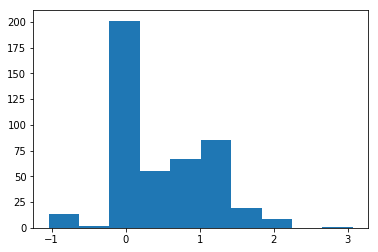

In [50]:
plt.hist(y_pred_high[:,0]-y_test)
plt.show()

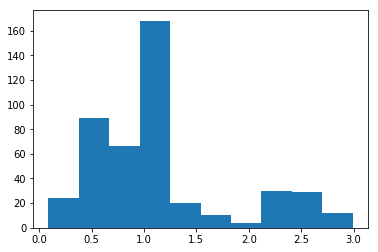

In [51]:
plt.hist(y_pred_high[:,0]-y_pred_low[:,0])
plt.show()

Q: 0.05
0.8561946902654868


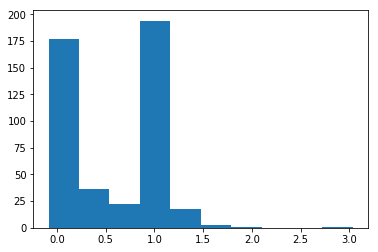

0.915929203539823


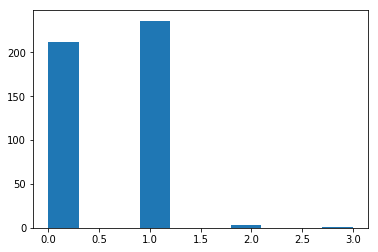

Q: 0.025
0.9446902654867256


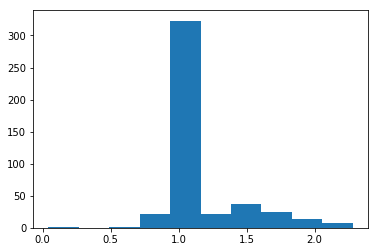

0.9690265486725663


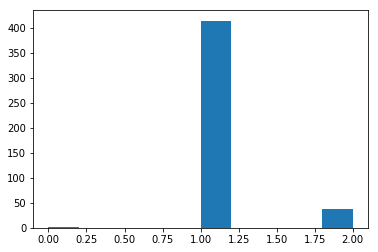

Q: 0.01
0.9601769911504425


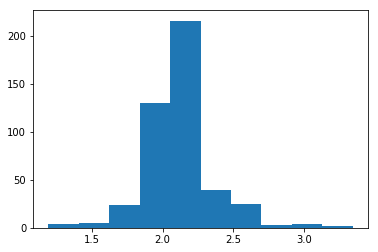

0.995575221238938


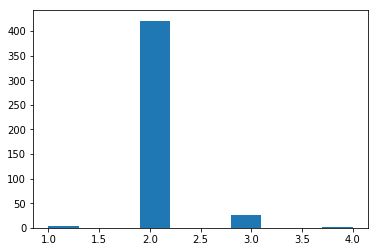

In [69]:
def within_window_acc(y,y_high,y_low):
    return(np.sum((y <= y_high) & (y >= y_low))/len(y))


for q in [0.05, 0.025, 0.01]:
    q_low = q
    q_high = 1-q
    model.compile(loss=lambda y,f: tilted_loss(q_low,y,f),  metrics=['accuracy'], optimizer='adadelta')
    model.fit(X_train_fs, y_train, epochs=100, batch_size=32, verbose=0)
    y_pred_low = model.predict(X_test_fs)
    model.compile(loss=lambda y,f: tilted_loss(q_high,y,f),  metrics=['accuracy'], optimizer='adadelta')
    model.fit(X_train_fs, y_train, epochs=100, batch_size=32, verbose=0)
    y_pred_high = model.predict(X_test_fs)
    
    print("Q: "+str(q))
    print(within_window_acc(y_test, y_pred_high[:,0], y_pred_low[:,0]))
    plt.hist(y_pred_high[:,0]-y_pred_low[:,0])
    plt.show()
    y_pred_high_ints = np.rint(y_pred_high[:,0])
    y_pred_low_ints = np.rint(y_pred_low[:,0])
    print(within_window_acc(y_test, y_pred_high_ints, y_pred_low_ints))
    plt.hist(y_pred_high_ints-y_pred_low_ints)
    plt.show()
   
    

In [56]:
def rounded_within_window_acc(y,y_high,y_low):
    return(np.sum((y <= np.rint(y_high)) & (y >= np.rint(y_low)))/len(y))

155279